In [1]:
import numpy as np
import pandas as pd

def Ackley(x1, x2):
    term1 = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x1**2 + x2**2)))
    term2 = -np.exp(0.5 * (np.cos(2 * np.pi * x1) + np.cos(2 * np.pi * x2)))
    return term1 + term2 + np.e + 20

def GetGrid(grid):
    x1 = np.linspace(-2, 2, grid)
    x2 = np.linspace(-2, 2, grid)
    x1, x2 = np.meshgrid(x1, x2)
    z = Ackley(x1, x2)
    return x1, x2, z

def create_dataframe(grid):
   x1, x2, z = GetGrid(grid)
   data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': z.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Exponential")

/tmp/ipykernel_48200/1212429102.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


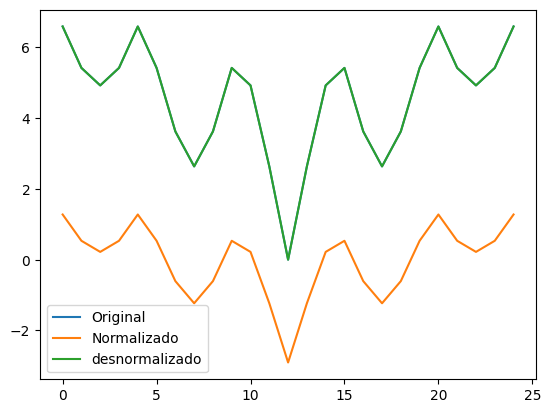

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 563.00 KiB/s, done.
Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-09-14 12:39:11.271799: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-14 12:39:11.271863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 12:39:11.273265: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-14 12:39:11.307441: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-14 12:39:18.103337: W tensorflow/compiler/tf2

In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[4], [8], [12], [24], [36],
                            [4, 2], [8, 4], [12, 6], [24, 12], [36, 18]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[4], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 29ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 25ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/st

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_1,0.643428,-0.162026,-1.737376,0.762797,0.485828,2.329501,2.018577,0.129666,2.381300e+14,0.697014,0.514456,0.707991,35.443802,72.408385
model_1_2_0,0.638271,-0.163613,-1.747062,0.758280,0.492855,2.332682,2.025719,0.132136,2.389695e+14,0.702037,0.507432,0.713093,35.415079,72.379663


DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 22ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_3] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_9,0.760080,-0.125929,-1.499961,0.564323,0.326891,2.257138,1.843504,0.856421,2.177158e+14,0.571744,0.673300,0.580748,36.236258,73.200841
model_1_3_8,0.753601,-0.127362,-1.512027,0.557340,0.335718,2.260012,1.852401,0.870147,2.190498e+14,0.579412,0.664478,0.588537,36.182969,73.147553
model_1_3_7,0.746746,-0.128978,-1.524892,0.550016,0.345059,2.263250,1.861888,0.884543,2.204279e+14,0.587417,0.655143,0.596668,36.128082,73.092665
model_1_3_6,0.744373,-0.129558,-1.529378,0.547497,0.348291,2.264414,1.865196,0.889497,2.208970e+14,0.590162,0.651912,0.599457,36.109432,73.074015
model_1_3_5,0.741956,-0.130158,-1.533985,0.544939,0.351585,2.265615,1.868593,0.894525,2.213703e+14,0.592946,0.648621,0.602284,36.090609,73.055193
model_1_3_4,0.739492,-0.130780,-1.538691,0.542338,0.354942,2.266864,1.872064,0.899637,2.218489e+14,0.595770,0.645266,0.605152,36.071604,73.036188
model_1_3_3,0.734423,-0.132092,-1.548453,0.537013,0.361848,2.269494,1.879262,0.910105,2.228203e+14,0.601538,0.638364,0.611011,36.033065,72.997648
model_1_3_2,0.731816,-0.132785,-1.553501,0.534285,0.365400,2.270883,1.882984,0.915467,2.233139e+14,0.604483,0.634814,0.614003,36.013527,72.978111
model_1_3_1,0.709087,-0.139272,-1.598407,0.510815,0.396368,2.283887,1.916099,0.961602,2.274525e+14,0.629578,0.603863,0.639493,35.850824,72.815407
model_1_3_0,0.702848,-0.141183,-1.611054,0.504460,0.404869,2.287718,1.925425,0.974094,2.285409e+14,0.636293,0.595367,0.646314,35.808382,72.772966


DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_4] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_4] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_4] | 9 +++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_2,0.832911,-0.117762,-1.484107,0.880299,0.227658,2.240766,1.831813,0.148451,1.928173e+14,0.477135,0.772475,0.484650,36.959822,73.924405
model_1_4_1,0.807590,-0.118025,-1.476036,0.868860,0.262158,2.241293,1.825861,0.162638,2.032532e+14,0.512014,0.737995,0.520078,36.677614,73.642198
model_1_4_3,0.841890,-0.119632,-1.493484,0.880549,0.215425,2.244514,1.838728,0.148142,1.882143e+14,0.464139,0.784701,0.471449,37.070286,74.034870
model_1_4_4,0.843626,-0.120189,-1.495818,0.880295,0.213059,2.245631,1.840448,0.148457,1.872439e+14,0.461583,0.787065,0.468853,37.092373,74.056957
model_1_4_5,0.846075,-0.121107,-1.499429,0.879749,0.209723,2.247471,1.843112,0.149134,1.858226e+14,0.457955,0.790400,0.465167,37.123938,74.088521
model_1_4_0,0.785583,-0.121266,-1.483397,0.850499,0.292142,2.247790,1.831289,0.185409,2.104982e+14,0.540502,0.708028,0.549014,36.461028,73.425612
model_1_4_6,0.848348,-0.122112,-1.503150,0.879030,0.206626,2.249486,1.845855,0.150026,1.844419e+14,0.454562,0.793494,0.461720,37.153688,74.118272
model_1_4_7,0.849068,-0.122465,-1.504409,0.878756,0.205644,2.250195,1.846784,0.150365,1.839905e+14,0.453480,0.794476,0.460622,37.163217,74.127801
model_1_4_8,0.849771,-0.122827,-1.505674,0.878467,0.204686,2.250919,1.847717,0.150723,1.835435e+14,0.452423,0.795433,0.459548,37.172555,74.137139
model_1_4_9,0.850459,-0.123203,-1.506921,0.878174,0.203750,2.251673,1.848636,0.151088,1.831016e+14,0.451387,0.796369,0.458495,37.181725,74.146308


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_5] | 9 +++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_9,0.860157,-0.104132,-1.430234,0.740503,0.190536,2.213442,1.792086,0.687299,1.822996e+14,0.436504,0.809575,0.443379,37.315830,74.280413
model_1_5_8,0.859934,-0.104648,-1.432241,0.740482,0.190840,2.214477,1.793566,0.687355,1.823215e+14,0.436853,0.809271,0.443733,37.312638,74.277222
model_1_5_7,0.859705,-0.105171,-1.434279,0.740459,0.191152,2.215525,1.795069,0.687417,1.823437e+14,0.437209,0.808960,0.444095,37.309374,74.273957
model_1_5_6,0.859470,-0.105701,-1.436351,0.740433,0.191471,2.216588,1.796597,0.687486,1.823662e+14,0.437575,0.808640,0.444466,37.306033,74.270616
model_1_5_5,0.859230,-0.106239,-1.438456,0.740404,0.191799,2.217666,1.798149,0.687563,1.823889e+14,0.437949,0.808313,0.444846,37.302616,74.267199
model_1_5_4,0.858984,-0.106784,-1.440595,0.740372,0.192134,2.218759,1.799726,0.687647,1.824119e+14,0.438331,0.807978,0.445234,37.299122,74.263705
model_1_5_3,0.855516,-0.113951,-1.469108,0.739738,0.196859,2.233127,1.820752,0.689327,1.827117e+14,0.443688,0.803256,0.450675,37.250539,74.215123
model_1_5_2,0.854483,-0.115938,-1.477141,0.739493,0.198267,2.237110,1.826676,0.689975,1.827948e+14,0.445272,0.801849,0.452284,37.236282,74.200865
model_1_5_1,0.852182,-0.120173,-1.494425,0.738877,0.201401,2.245599,1.839421,0.691607,1.829730e+14,0.448778,0.798716,0.455846,37.204910,74.169494
model_1_5_0,0.851766,-0.120914,-1.497472,0.738757,0.201968,2.247085,1.841669,0.691926,1.830043e+14,0.449409,0.798150,0.456486,37.199290,74.163874


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_6] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_0,0.860712,-0.104629,-1.431019,0.926587,0.189780,2.214439,1.792665,0.062952,1.819398e+14,0.435637,0.810331,0.442498,37.323784,74.288367
model_1_6_1,0.861253,-0.105129,-1.431809,0.925646,0.189042,2.215441,1.793247,0.063759,1.815836e+14,0.434789,0.811069,0.441637,37.331574,74.296157
model_1_6_2,0.861782,-0.105631,-1.432604,0.924699,0.188322,2.216446,1.793833,0.064571,1.812308e+14,0.433961,0.811788,0.440796,37.339202,74.303785
model_1_6_3,0.862297,-0.106134,-1.433404,0.923748,0.187620,2.217455,1.794424,0.065388,1.808815e+14,0.433151,0.812489,0.439973,37.346671,74.311255
model_1_6_4,0.862799,-0.106639,-1.434212,0.922790,0.186936,2.218468,1.795019,0.066208,1.805355e+14,0.432360,0.813174,0.439170,37.353982,74.318566
model_1_6_5,0.864687,-0.108673,-1.437494,0.918919,0.184363,2.222545,1.797440,0.069528,1.791856e+14,0.429376,0.815744,0.436138,37.381692,74.346276
model_1_6_6,0.865130,-0.109184,-1.438327,0.917941,0.183760,2.223570,1.798054,0.070366,1.788563e+14,0.428673,0.816347,0.435424,37.388247,74.352831
model_1_6_7,0.865561,-0.109696,-1.439166,0.916960,0.183172,2.224595,1.798672,0.071208,1.785301e+14,0.427986,0.816935,0.434727,37.394657,74.359240
model_1_6_8,0.867180,-0.111748,-1.442572,0.913008,0.180967,2.228709,1.801184,0.074596,1.772575e+14,0.425402,0.819139,0.432101,37.418886,74.383469
model_1_6_9,0.867559,-0.112262,-1.443429,0.912015,0.180450,2.229739,1.801816,0.075448,1.769471e+14,0.424794,0.819655,0.431484,37.424603,74.389187


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_7] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_9,0.873103,-0.107230,-1.439030,0.895344,0.172896,2.219652,1.798572,0.095445,1.735818e+14,0.415808,0.827204,0.422357,37.510124,74.474708
model_1_7_8,0.872797,-0.107515,-1.439231,0.895578,0.173313,2.220225,1.798721,0.095232,1.737907e+14,0.416309,0.826788,0.422866,37.505308,74.469892
model_1_7_7,0.872483,-0.107807,-1.439444,0.895803,0.173741,2.220810,1.798877,0.095027,1.740016e+14,0.416823,0.826360,0.423387,37.500376,74.464959
model_1_7_6,0.872161,-0.108107,-1.439669,0.896019,0.174181,2.221410,1.799044,0.094830,1.742147e+14,0.417350,0.825921,0.423922,37.495325,74.459908
model_1_7_5,0.871830,-0.108412,-1.439908,0.896226,0.174632,2.222022,1.799219,0.094641,1.744300e+14,0.417890,0.825470,0.424471,37.490151,74.454735
model_1_7_4,0.871490,-0.108724,-1.440158,0.896423,0.175095,2.222648,1.799404,0.094462,1.746474e+14,0.418443,0.825007,0.425033,37.484854,74.449438
model_1_7_3,0.871141,-0.109044,-1.440421,0.896609,0.175570,2.223289,1.799598,0.094291,1.748671e+14,0.419011,0.824532,0.425610,37.479432,74.444016
model_1_7_2,0.870783,-0.109371,-1.440697,0.896785,0.176058,2.223944,1.799802,0.094131,1.750889e+14,0.419593,0.824045,0.426201,37.473882,74.438466
model_1_7_1,0.870038,-0.110046,-1.441293,0.897105,0.177073,2.225297,1.800241,0.093840,1.755394e+14,0.420800,0.823031,0.427427,37.462389,74.426972
model_1_7_0,0.867999,-0.111871,-1.443035,0.897693,0.179851,2.228957,1.801526,0.093303,1.767064e+14,0.424088,0.820254,0.430767,37.431258,74.395842


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_8] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_0,0.873415,-0.107597,-1.440515,0.837058,0.172472,2.220389,1.799667,0.073318,1.732901e+14,0.415297,0.827629,0.421838,37.515044,74.479627
model_1_8_1,0.873719,-0.107967,-1.441991,0.835745,0.172058,2.221129,1.800756,0.073909,1.730014e+14,0.414798,0.828043,0.421331,37.519853,74.484436
model_1_8_2,0.874015,-0.108336,-1.443458,0.834435,0.171654,2.221870,1.801837,0.074499,1.727157e+14,0.414311,0.828446,0.420836,37.524552,74.489135
model_1_8_3,0.874304,-0.108706,-1.444916,0.833128,0.171260,2.222612,1.802913,0.075087,1.724328e+14,0.413836,0.828840,0.420353,37.529143,74.493727
model_1_8_4,0.874586,-0.109077,-1.446366,0.831826,0.170877,2.223355,1.803982,0.075673,1.721528e+14,0.413372,0.829223,0.419882,37.533628,74.498211
model_1_8_5,0.874860,-0.109448,-1.447807,0.830527,0.170503,2.224098,1.805045,0.076258,1.718756e+14,0.412920,0.829597,0.419423,37.538008,74.502592
model_1_8_6,0.875128,-0.109818,-1.449240,0.829231,0.170138,2.224842,1.806101,0.076840,1.716012e+14,0.412478,0.829961,0.418974,37.542286,74.506870
model_1_8_7,0.875388,-0.110189,-1.450663,0.827941,0.169783,2.225584,1.807150,0.077421,1.713297e+14,0.412048,0.830316,0.418537,37.546464,74.511047
model_1_8_8,0.875642,-0.110560,-1.452078,0.826654,0.169437,2.226327,1.808194,0.078000,1.710608e+14,0.411628,0.830661,0.418111,37.550542,74.515126
model_1_8_9,0.875889,-0.110929,-1.453485,0.825371,0.169101,2.227069,1.809231,0.078577,1.707946e+14,0.411218,0.830998,0.417695,37.554524,74.519108


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [1_9] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_0,0.876087,-0.111208,-1.454060,0.941236,0.168831,2.227628,1.809656,0.088097,1.706026e+14,0.410890,0.831268,0.417362,37.557714,74.522298
model_1_9_1,0.876280,-0.111487,-1.454634,0.941152,0.168568,2.228186,1.810079,0.088222,1.704124e+14,0.410570,0.831531,0.417036,37.560834,74.525418
model_1_9_2,0.876469,-0.111763,-1.455207,0.941067,0.168311,2.228741,1.810502,0.088351,1.702241e+14,0.410257,0.831787,0.416718,37.563884,74.528467
model_1_9_3,0.876653,-0.112039,-1.455777,0.940979,0.168060,2.229293,1.810922,0.088482,1.700376e+14,0.409952,0.832038,0.416408,37.566865,74.531448
model_1_9_4,0.876832,-0.112313,-1.456346,0.940890,0.167816,2.229843,1.811341,0.088616,1.698529e+14,0.409653,0.832282,0.416105,37.569778,74.534362
model_1_9_5,0.877008,-0.112586,-1.456912,0.940799,0.167577,2.230391,1.811759,0.088753,1.696700e+14,0.409362,0.832521,0.415809,37.572626,74.537209
model_1_9_6,0.877179,-0.112858,-1.457476,0.940705,0.167344,2.230934,1.812175,0.088892,1.694889e+14,0.409077,0.832754,0.415519,37.575410,74.539993
model_1_9_7,0.877345,-0.113128,-1.458037,0.940611,0.167117,2.231476,1.812589,0.089034,1.693096e+14,0.408799,0.832981,0.415237,37.578128,74.542712
model_1_9_8,0.877822,-0.113930,-1.459712,0.940316,0.166467,2.233085,1.813823,0.089476,1.687819e+14,0.408004,0.833630,0.414429,37.585916,74.550499
model_1_9_9,0.877973,-0.114195,-1.460265,0.940215,0.166261,2.233616,1.814232,0.089628,1.686094e+14,0.407751,0.833836,0.414173,37.588392,74.552976


DataFrame salvo em ../results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 25ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_10] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_0,0.878157,-0.114554,-1.460353,0.946885,0.166011,2.234334,1.814296,0.039171,1.684357e+14,0.407445,0.834085,0.413862,37.591397,74.555980
model_1_10_1,0.878335,-0.114909,-1.460445,0.946940,0.165768,2.235046,1.814364,0.039131,1.682635e+14,0.407146,0.834329,0.413558,37.594337,74.558921
model_1_10_2,0.878510,-0.115260,-1.460544,0.946989,0.165529,2.235751,1.814437,0.039095,1.680929e+14,0.406853,0.834567,0.413260,37.597216,74.561799
model_1_10_3,0.878682,-0.115610,-1.460647,0.947033,0.165296,2.236452,1.814513,0.039063,1.679240e+14,0.406566,0.834800,0.412969,37.600033,74.564617
model_1_10_4,0.878849,-0.115957,-1.460756,0.947071,0.165068,2.237147,1.814593,0.039034,1.677566e+14,0.406286,0.835028,0.412685,37.602790,74.567374
model_1_10_5,0.879012,-0.116301,-1.460870,0.947104,0.164846,2.237838,1.814678,0.039010,1.675908e+14,0.406012,0.835250,0.412406,37.605488,74.570072
model_1_10_6,0.879172,-0.116643,-1.460988,0.947133,0.164628,2.238522,1.814764,0.038989,1.674266e+14,0.405744,0.835468,0.412134,37.608129,74.572712
model_1_10_7,0.879328,-0.116982,-1.461111,0.947156,0.164416,2.239202,1.814855,0.038972,1.672639e+14,0.405482,0.835680,0.411868,37.610712,74.575296
model_1_10_8,0.879480,-0.117318,-1.461238,0.947175,0.164208,2.239876,1.814949,0.038958,1.671028e+14,0.405226,0.835888,0.411608,37.613240,74.577824
model_1_10_9,0.879629,-0.117652,-1.461369,0.947190,0.164005,2.240545,1.815046,0.038947,1.669432e+14,0.404976,0.836090,0.411354,37.615712,74.580296


DataFrame salvo em ../results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [1_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_11] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_0,0.879669,-0.117681,-1.461509,0.922848,0.163951,2.240603,1.815149,0.133389,1.668467e+14,0.404908,0.836145,0.411285,37.616379,74.580963
model_1_11_1,0.880001,-0.118275,-1.464484,0.916538,0.163498,2.241794,1.817342,0.144299,1.654017e+14,0.404349,0.836597,0.410717,37.621909,74.586493
model_1_11_2,0.880005,-0.118319,-1.464713,0.916132,0.163492,2.241883,1.817511,0.145001,1.653169e+14,0.404342,0.836603,0.410710,37.621978,74.586562
model_1_11_3,0.880009,-0.118409,-1.465183,0.915316,0.163488,2.242063,1.817858,0.146410,1.651495e+14,0.404336,0.836608,0.410704,37.622032,74.586616
model_1_11_4,0.880008,-0.118455,-1.465424,0.914907,0.163489,2.242155,1.818035,0.147117,1.650667e+14,0.404338,0.836607,0.410705,37.622021,74.586604
model_1_11_5,0.880006,-0.118502,-1.465669,0.914498,0.163492,2.242248,1.818217,0.147826,1.649845e+14,0.404342,0.836603,0.410710,37.621981,74.586565
model_1_11_6,0.880002,-0.118549,-1.465919,0.914087,0.163497,2.242343,1.818401,0.148536,1.649029e+14,0.404348,0.836598,0.410716,37.621918,74.586501
model_1_11_7,0.879996,-0.118596,-1.466172,0.913675,0.163505,2.242438,1.818587,0.149247,1.648219e+14,0.404357,0.836591,0.410725,37.621829,74.586412
model_1_11_8,0.879990,-0.118644,-1.466430,0.913263,0.163514,2.242535,1.818777,0.149960,1.647415e+14,0.404368,0.836582,0.410737,37.621716,74.586300
model_1_11_9,0.879982,-0.118693,-1.466690,0.912851,0.163525,2.242632,1.818969,0.150673,1.646617e+14,0.404382,0.836571,0.410751,37.621581,74.586165


DataFrame salvo em ../results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_12] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_0,0.880149,-0.119112,-1.466400,0.923691,0.163296,2.243472,1.818755,0.070864,1.645207e+14,0.404099,0.836799,0.410463,37.624379,74.588963
model_1_12_1,0.880312,-0.119530,-1.466124,0.923032,0.163074,2.244310,1.818552,0.071476,1.643811e+14,0.403825,0.837021,0.410185,37.627098,74.591681
model_1_12_2,0.880470,-0.119945,-1.465862,0.922375,0.162859,2.245142,1.818359,0.072086,1.642430e+14,0.403558,0.837236,0.409914,37.629735,74.594319
model_1_12_3,0.880623,-0.120358,-1.465613,0.921718,0.162651,2.245970,1.818175,0.072696,1.641061e+14,0.403300,0.837444,0.409652,37.632297,74.596881
model_1_12_4,0.880771,-0.120768,-1.465375,0.921063,0.162449,2.246792,1.818000,0.073305,1.639708e+14,0.403050,0.837646,0.409397,37.634783,74.599366
model_1_12_5,0.880915,-0.121176,-1.465151,0.920409,0.162253,2.247610,1.817834,0.073912,1.638366e+14,0.402807,0.837842,0.409150,37.637196,74.601779
model_1_12_6,0.881054,-0.121582,-1.464937,0.919757,0.162063,2.248423,1.817677,0.074517,1.637040e+14,0.402571,0.838031,0.408911,37.639535,74.604119
model_1_12_7,0.881189,-0.121985,-1.464738,0.919106,0.161880,2.249232,1.817529,0.075122,1.635726e+14,0.402343,0.838215,0.408679,37.641804,74.606388
model_1_12_8,0.881320,-0.122386,-1.464548,0.918458,0.161702,2.250035,1.817390,0.075724,1.634426e+14,0.402122,0.838393,0.408455,37.644003,74.608586
model_1_12_9,0.881446,-0.122784,-1.464369,0.917810,0.161530,2.250834,1.817258,0.076325,1.633139e+14,0.401907,0.838565,0.408237,37.646134,74.610717


DataFrame salvo em ../results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_13] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_1,0.881780,-0.122778,-1.464061,0.959354,0.161075,2.250822,1.817031,0.033321,1.629247e+14,0.401341,0.839019,0.407662,37.651771,74.616355
model_1_13_2,0.881938,-0.122779,-1.463927,0.958570,0.160859,2.250824,1.816932,0.033964,1.627330e+14,0.401073,0.839235,0.407389,37.654450,74.619034
model_1_13_0,0.881616,-0.122780,-1.464208,0.960135,0.161298,2.250826,1.817139,0.032682,1.631183e+14,0.401620,0.838796,0.407945,37.649000,74.613584
model_1_13_3,0.882090,-0.122783,-1.463807,0.957782,0.160652,2.250831,1.816843,0.034610,1.625434e+14,0.400814,0.839442,0.407126,37.657035,74.621619
model_1_13_4,0.882238,-0.122788,-1.463698,0.956991,0.160451,2.250842,1.816763,0.035258,1.623556e+14,0.400563,0.839643,0.406872,37.659534,74.624117
model_1_13_5,0.882379,-0.122796,-1.463600,0.956197,0.160258,2.250857,1.816691,0.035909,1.621697e+14,0.400322,0.839836,0.406627,37.661943,74.626527
model_1_13_6,0.882516,-0.122806,-1.463516,0.955401,0.160072,2.250877,1.816629,0.036563,1.619857e+14,0.400089,0.840022,0.406390,37.664269,74.628853
model_1_13_7,0.882648,-0.122818,-1.463442,0.954601,0.159892,2.250901,1.816574,0.037218,1.618035e+14,0.399865,0.840201,0.406163,37.666511,74.631095
model_1_13_8,0.882774,-0.122832,-1.463379,0.953800,0.159720,2.250930,1.816527,0.037875,1.616232e+14,0.399649,0.840374,0.405943,37.668672,74.633256
model_1_13_9,0.882896,-0.122848,-1.463327,0.952996,0.159553,2.250962,1.816489,0.038533,1.614447e+14,0.399441,0.840540,0.405732,37.670753,74.635337


DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_14] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_0,0.882973,-0.123130,-1.463549,0.936803,0.159449,2.251527,1.816653,0.059990,1.613714e+14,0.399311,0.840644,0.405600,37.672058,74.636642
model_1_14_1,0.883047,-0.123410,-1.463773,0.936719,0.159348,2.252088,1.816818,0.060069,1.612989e+14,0.399184,0.840745,0.405471,37.673333,74.637917
model_1_14_2,0.883120,-0.123686,-1.463996,0.936634,0.159249,2.252642,1.816982,0.060149,1.612271e+14,0.399060,0.840844,0.405344,37.674578,74.639162
model_1_14_3,0.883261,-0.124233,-1.464444,0.936464,0.159057,2.253739,1.817313,0.060311,1.610855e+14,0.398820,0.841036,0.405101,37.676983,74.641567
model_1_14_4,0.883328,-0.124503,-1.464670,0.936378,0.158965,2.254281,1.817479,0.060393,1.610157e+14,0.398704,0.841128,0.404983,37.678143,74.642727
model_1_14_5,0.883394,-0.124771,-1.464895,0.936292,0.158875,2.254818,1.817645,0.060474,1.609467e+14,0.398591,0.841218,0.404868,37.679277,74.643861
model_1_14_6,0.883459,-0.125037,-1.465120,0.936205,0.158787,2.255350,1.817812,0.060557,1.608783e+14,0.398481,0.841306,0.404756,37.680384,74.644968
model_1_14_7,0.883522,-0.125300,-1.465346,0.936118,0.158701,2.255877,1.817978,0.060639,1.608107e+14,0.398373,0.841392,0.404647,37.681465,74.646048
model_1_14_8,0.883583,-0.125561,-1.465572,0.936031,0.158617,2.256400,1.818144,0.060722,1.607437e+14,0.398268,0.841475,0.404540,37.682521,74.647105
model_1_14_9,0.883643,-0.125819,-1.465797,0.935943,0.158536,2.256919,1.818311,0.060805,1.606773e+14,0.398165,0.841557,0.404436,37.683551,74.648135


DataFrame salvo em ../results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [1_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_15] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_15] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_0,0.883725,-0.126314,-1.465355,0.962039,0.158424,2.257911,1.817984,0.048686,1.605335e+14,0.398025,0.841669,0.404294,37.684961,74.649545
model_1_15_1,0.883804,-0.126805,-1.464931,0.961529,0.158317,2.258893,1.817672,0.049341,1.603911e+14,0.397891,0.841775,0.404157,37.686311,74.650894
model_1_15_2,0.883879,-0.127290,-1.464524,0.961018,0.158215,2.259867,1.817372,0.049996,1.602500e+14,0.397762,0.841878,0.404027,37.687604,74.652188
model_1_15_3,0.883951,-0.127771,-1.464134,0.960505,0.158117,2.260832,1.817084,0.050654,1.601101e+14,0.397639,0.841975,0.403902,37.688841,74.653425
model_1_15_4,0.884019,-0.128248,-1.463760,0.959992,0.158023,2.261787,1.816809,0.051312,1.599714e+14,0.397522,0.842069,0.403782,37.690024,74.654607
model_1_15_5,0.884085,-0.128720,-1.463404,0.959477,0.157934,2.262733,1.816546,0.051972,1.598341e+14,0.397409,0.842158,0.403668,37.691153,74.655737
model_1_15_6,0.884462,-0.131892,-1.461346,0.955854,0.157420,2.269092,1.815029,0.056620,1.589051e+14,0.396762,0.842672,0.403011,37.697674,74.662258
model_1_15_7,0.884505,-0.132327,-1.461113,0.955333,0.157361,2.269965,1.814857,0.057287,1.587770e+14,0.396688,0.842731,0.402935,37.698421,74.663005
model_1_15_8,0.884546,-0.132758,-1.460894,0.954812,0.157306,2.270828,1.814695,0.057955,1.586499e+14,0.396618,0.842786,0.402864,37.699126,74.663709
model_1_15_9,0.884584,-0.133184,-1.460688,0.954291,0.157254,2.271682,1.814543,0.058623,1.585240e+14,0.396552,0.842838,0.402798,37.699790,74.664373


DataFrame salvo em ../results/metrics_1_15
+++++++++++ [1_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_16] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_16] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_16] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_0,0.884641,-0.133841,-1.461726,0.918848,0.157176,2.273000,1.815309,0.068615,1.583862e+14,0.396454,0.842916,0.402698,37.700779,74.665362
model_1_16_1,0.884696,-0.134493,-1.462758,0.918232,0.157101,2.274307,1.816070,0.069136,1.582498e+14,0.396360,0.842990,0.402603,37.701727,74.666310
model_1_16_2,0.884892,-0.137048,-1.466809,0.915796,0.156834,2.279429,1.819057,0.071195,1.577184e+14,0.396023,0.843258,0.402260,37.705137,74.669720
model_1_16_3,0.884936,-0.137674,-1.467803,0.915195,0.156774,2.280683,1.819790,0.071704,1.575890e+14,0.395947,0.843317,0.402183,37.705896,74.670479
model_1_16_4,0.885125,-0.140724,-1.472670,0.912230,0.156516,2.286797,1.823379,0.074210,1.569615e+14,0.395621,0.843575,0.401852,37.709191,74.673774
model_1_16_5,0.885158,-0.141319,-1.473622,0.911646,0.156472,2.287991,1.824081,0.074704,1.568398e+14,0.395566,0.843619,0.401795,37.709755,74.674338
model_1_16_6,0.885189,-0.141909,-1.474567,0.911066,0.156430,2.289173,1.824778,0.075195,1.567195e+14,0.395513,0.843661,0.401742,37.710289,74.674872
model_1_16_7,0.885217,-0.142494,-1.475506,0.910488,0.156391,2.290345,1.825470,0.075684,1.566004e+14,0.395463,0.843700,0.401691,37.710792,74.675376
model_1_16_8,0.885245,-0.143074,-1.476437,0.909913,0.156354,2.291508,1.826156,0.076169,1.564825e+14,0.395416,0.843738,0.401643,37.711269,74.675853
model_1_16_9,0.885271,-0.143649,-1.477362,0.909342,0.156319,2.292662,1.826839,0.076652,1.563658e+14,0.395371,0.843773,0.401598,37.711718,74.676302


DataFrame salvo em ../results/metrics_1_16
+++++++++++ [1_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_17] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_17] | 4 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_17] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_17] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_17] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_17] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_0,0.885277,-0.143832,-1.479221,0.941587,0.156309,2.293028,1.828210,0.086490,1.562070e+14,0.395360,0.843782,0.401586,37.711835,74.676419
model_1_17_1,0.885223,-0.145285,-1.493751,0.936618,0.156384,2.295942,1.838924,0.093848,1.549929e+14,0.395454,0.843708,0.401682,37.710886,74.675470
model_1_17_2,0.885204,-0.145461,-1.495533,0.935987,0.156410,2.296294,1.840238,0.094781,1.548468e+14,0.395487,0.843681,0.401715,37.710550,74.675134
model_1_17_3,0.884715,-0.147832,-1.519427,0.927179,0.157076,2.301046,1.857858,0.107824,1.529421e+14,0.396328,0.843016,0.402570,37.702054,74.666637
model_1_17_4,0.884618,-0.148158,-1.522672,0.925933,0.157208,2.301700,1.860251,0.109668,1.526900e+14,0.396495,0.842884,0.402739,37.700370,74.664953
model_1_17_5,0.884354,-0.148956,-1.530577,0.922860,0.157567,2.303300,1.866080,0.114218,1.520813e+14,0.396947,0.842525,0.403198,37.695812,74.660396
model_1_17_6,0.884299,-0.149113,-1.532123,0.922252,0.157643,2.303615,1.867220,0.115119,1.519631e+14,0.397043,0.842449,0.403296,37.694846,74.659429
model_1_17_7,0.884184,-0.149426,-1.535187,0.921042,0.157799,2.304243,1.869479,0.116911,1.517300e+14,0.397240,0.842293,0.403496,37.692861,74.657445
model_1_17_8,0.884065,-0.149735,-1.538198,0.919842,0.157961,2.304862,1.871700,0.118687,1.515014e+14,0.397443,0.842132,0.403702,37.690818,74.655402
model_1_17_9,0.884005,-0.149888,-1.539688,0.919246,0.158043,2.305168,1.872799,0.119569,1.513888e+14,0.397546,0.842049,0.403807,37.689777,74.654361


DataFrame salvo em ../results/metrics_1_17
+++++++++++ [1_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_18] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_18] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_18] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_9,0.884430,-0.147990,-1.521059,0.936046,0.157464,2.301364,1.859062,0.073602,1.512017e+14,0.396817,0.842628,0.403066,37.697122,74.661706
model_1_18_8,0.884412,-0.148097,-1.522119,0.936281,0.157488,2.301578,1.859843,0.073332,1.512125e+14,0.396848,0.842604,0.403098,37.696808,74.661391
model_1_18_7,0.884393,-0.148206,-1.523191,0.936517,0.157514,2.301796,1.860634,0.073060,1.512232e+14,0.396881,0.842578,0.403131,37.696476,74.661060
model_1_18_6,0.884373,-0.148316,-1.524280,0.936755,0.157542,2.302018,1.861437,0.072787,1.512342e+14,0.396916,0.842550,0.403167,37.696125,74.660709
model_1_18_5,0.884351,-0.148428,-1.525381,0.936994,0.157571,2.302243,1.862249,0.072512,1.512452e+14,0.396952,0.842521,0.403204,37.695759,74.660342
model_1_18_4,0.884329,-0.148541,-1.526495,0.937234,0.157601,2.302469,1.863070,0.072236,1.512565e+14,0.396990,0.842491,0.403243,37.695373,74.659957
model_1_18_3,0.884281,-0.148771,-1.528761,0.937717,0.157667,2.302930,1.864741,0.071680,1.512793e+14,0.397073,0.842425,0.403326,37.694544,74.659128
model_1_18_2,0.884255,-0.148889,-1.529917,0.937960,0.157702,2.303166,1.865594,0.071400,1.512909e+14,0.397117,0.842390,0.403371,37.694100,74.658684
model_1_18_1,0.884076,-0.149628,-1.537152,0.939443,0.157947,2.304647,1.870929,0.069693,1.513635e+14,0.397425,0.842146,0.403684,37.690996,74.655579
model_1_18_0,0.884041,-0.149756,-1.538409,0.939694,0.157994,2.304904,1.871856,0.069404,1.513761e+14,0.397484,0.842098,0.403744,37.690398,74.654982


DataFrame salvo em ../results/metrics_1_18
+++++++++++ [1_19] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_19] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_0,0.884388,-0.156270,-1.537097,0.883087,0.157521,2.317962,1.870888,0.093466,1.502031e+14,0.396889,0.842571,0.403140,37.696392,74.660976
model_1_19_1,0.884378,-0.156824,-1.538179,0.882442,0.157535,2.319073,1.871686,0.093983,1.501372e+14,0.396907,0.842557,0.403158,37.696215,74.660798
model_1_19_2,0.884366,-0.157375,-1.539255,0.881798,0.157550,2.320178,1.872480,0.094497,1.500721e+14,0.396926,0.842542,0.403177,37.696019,74.660603
model_1_19_3,0.884354,-0.157920,-1.540321,0.881158,0.157567,2.321270,1.873266,0.095009,1.500077e+14,0.396947,0.842525,0.403199,37.695810,74.660393
model_1_19_4,0.884341,-0.158461,-1.541380,0.880521,0.157585,2.322355,1.874047,0.095518,1.499440e+14,0.396969,0.842507,0.403221,37.695586,74.660170
model_1_19_5,0.884328,-0.158996,-1.542430,0.879888,0.157603,2.323428,1.874821,0.096024,1.498809e+14,0.396993,0.842489,0.403245,37.695351,74.659935
model_1_19_6,0.884313,-0.159529,-1.543477,0.879257,0.157623,2.324496,1.875593,0.096529,1.498185e+14,0.397017,0.842469,0.403270,37.695102,74.659686
model_1_19_7,0.884298,-0.160058,-1.544515,0.878629,0.157643,2.325556,1.876358,0.097030,1.497567e+14,0.397043,0.842449,0.403296,37.694842,74.659426
model_1_19_8,0.884283,-0.160581,-1.545543,0.878005,0.157665,2.326605,1.877117,0.097529,1.496956e+14,0.397070,0.842427,0.403324,37.694570,74.659154
model_1_19_9,0.884266,-0.161099,-1.546564,0.877384,0.157687,2.327644,1.877869,0.098026,1.496352e+14,0.397098,0.842405,0.403352,37.694285,74.658869


DataFrame salvo em ../results/metrics_1_19
+++++++++++ [1_20] | 1 ++++++++++++++++++
Stopped at epoch:  104
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_20] | 2 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_20] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_20] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_20] | 8 ++++++++++++++++++
Stopped at epoch:  31
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_20

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_9,0.876481,-0.122952,-1.602054,0.849936,0.168294,2.251169,1.918788,0.233481,1.496362e+14,0.410237,0.831804,0.416698,37.564080,74.528664
model_1_20_8,0.876750,-0.123665,-1.600419,0.851264,0.167928,2.252599,1.917583,0.231415,1.496466e+14,0.409790,0.832170,0.416244,37.568441,74.533025
model_1_20_7,0.876945,-0.124199,-1.599240,0.852238,0.167662,2.253670,1.916713,0.229900,1.496533e+14,0.409465,0.832436,0.415914,37.571615,74.536199
model_1_20_6,0.877681,-0.126307,-1.594800,0.855978,0.166660,2.257896,1.913439,0.224081,1.496739e+14,0.408240,0.833438,0.414669,37.583602,74.548185
model_1_20_5,0.877712,-0.126401,-1.594606,0.856142,0.166617,2.258084,1.913296,0.223826,1.496747e+14,0.408187,0.833481,0.414616,37.584118,74.548702
model_1_20_4,0.878112,-0.127616,-1.592173,0.858232,0.166073,2.260520,1.911502,0.220575,1.496833e+14,0.407520,0.834024,0.413938,37.590661,74.555245
model_1_20_3,0.878400,-0.128525,-1.590410,0.859765,0.165680,2.262343,1.910202,0.218189,1.496884e+14,0.407038,0.834417,0.413449,37.595392,74.559976
model_1_20_2,0.878437,-0.128646,-1.590183,0.859966,0.165629,2.262584,1.910034,0.217877,1.496890e+14,0.406976,0.834467,0.413385,37.596006,74.560590
model_1_20_1,0.878474,-0.128767,-1.589953,0.860167,0.165578,2.262827,1.909865,0.217563,1.496897e+14,0.406913,0.834518,0.413322,37.596623,74.561206
model_1_20_0,0.879330,-0.131668,-1.584653,0.864891,0.164413,2.268643,1.905957,0.210214,1.496997e+14,0.405479,0.835683,0.411865,37.610746,74.575330


DataFrame salvo em ../results/metrics_1_20
+++++++++++ [1_21] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_21] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_21] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [1_21] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_21] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_21] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_0,0.877113,-0.124021,-1.596308,0.925752,0.167433,2.253314,1.914552,0.073503,1.497256e+14,0.409186,0.832665,0.415630,37.574341,74.538925
model_1_21_1,0.877314,-0.124373,-1.594456,0.925638,0.167160,2.254018,1.913185,0.073616,1.497548e+14,0.408851,0.832938,0.415290,37.577613,74.542197
model_1_21_2,0.877702,-0.125069,-1.590841,0.925400,0.166631,2.255414,1.910520,0.073852,1.498121e+14,0.408205,0.833466,0.414634,37.583944,74.548527
model_1_21_3,0.878071,-0.125754,-1.587341,0.925149,0.166128,2.256788,1.907939,0.074101,1.498681e+14,0.407588,0.833969,0.414007,37.589997,74.554581
model_1_21_4,0.878249,-0.126093,-1.585633,0.925018,0.165885,2.257467,1.906679,0.074230,1.498957e+14,0.407290,0.834212,0.413704,37.592923,74.557507
model_1_21_5,0.878424,-0.126429,-1.583951,0.924885,0.165647,2.258140,1.905439,0.074362,1.499229e+14,0.406998,0.834449,0.413408,37.595787,74.560370
model_1_21_6,0.878922,-0.127420,-1.579069,0.924468,0.164969,2.260127,1.901839,0.074775,1.500026e+14,0.406164,0.835127,0.412561,37.603993,74.568577
model_1_21_7,0.880085,-0.129948,-1.567153,0.923252,0.163383,2.265195,1.893052,0.075978,1.502006e+14,0.404207,0.836712,0.410573,37.623313,74.587897
model_1_21_8,0.880216,-0.130252,-1.565768,0.923092,0.163206,2.265805,1.892031,0.076137,1.502238e+14,0.403987,0.836890,0.410350,37.625487,74.590071
model_1_21_9,0.881043,-0.132302,-1.556664,0.921926,0.162078,2.269915,1.885317,0.077291,1.503784e+14,0.402589,0.838016,0.408930,37.639351,74.603935


DataFrame salvo em ../results/metrics_1_21
+++++++++++ [1_22] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_22] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_22] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [1_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_22] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_9,0.883324,-0.127006,-1.512379,0.907279,0.158971,2.259298,1.852661,0.110226,1.517174e+14,0.398711,0.841122,0.404991,37.678069,74.642652
model_1_22_8,0.883279,-0.127141,-1.513497,0.907419,0.159031,2.259568,1.853485,0.110059,1.516812e+14,0.398787,0.841061,0.405068,37.677307,74.641890
model_1_22_7,0.883234,-0.127277,-1.514626,0.907560,0.159094,2.259840,1.854318,0.109891,1.516447e+14,0.398866,0.840999,0.405147,37.676523,74.641106
model_1_22_6,0.883186,-0.127415,-1.515773,0.907701,0.159158,2.260116,1.855164,0.109724,1.516079e+14,0.398946,0.840935,0.405229,37.675713,74.640297
model_1_22_5,0.883138,-0.127555,-1.516937,0.907841,0.159224,2.260397,1.856022,0.109558,1.515705e+14,0.399029,0.840869,0.405314,37.674882,74.639466
model_1_22_4,0.883088,-0.127696,-1.518114,0.907980,0.159293,2.260680,1.856890,0.109392,1.515330e+14,0.399115,0.840800,0.405401,37.674023,74.638607
model_1_22_3,0.882983,-0.127985,-1.520521,0.908258,0.159435,2.261260,1.858665,0.109061,1.514568e+14,0.399294,0.840658,0.405582,37.672232,74.636816
model_1_22_2,0.882928,-0.128131,-1.521744,0.908396,0.159510,2.261553,1.859567,0.108897,1.514182e+14,0.399387,0.840583,0.405677,37.671298,74.635881
model_1_22_1,0.882213,-0.129883,-1.536374,0.909872,0.160485,2.265065,1.870355,0.107143,1.509696e+14,0.400606,0.839609,0.406915,37.659108,74.623692
model_1_22_0,0.882136,-0.130055,-1.537813,0.910001,0.160589,2.265410,1.871416,0.106990,1.509265e+14,0.400736,0.839505,0.407047,37.657811,74.622394


DataFrame salvo em ../results/metrics_1_22
+++++++++++ [1_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_23] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_23] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_23] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_23] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_0,0.883354,-0.127050,-1.511715,0.894873,0.158930,2.259385,1.852171,0.121325,1.517299e+14,0.398660,0.841163,0.404939,37.678584,74.643168
model_1_23_1,0.883382,-0.127094,-1.511066,0.894407,0.158891,2.259474,1.851692,0.121863,1.517422e+14,0.398612,0.841202,0.404889,37.679070,74.643654
model_1_23_2,0.883409,-0.127138,-1.510427,0.893944,0.158855,2.259561,1.851221,0.122397,1.517545e+14,0.398566,0.841238,0.404843,37.679526,74.644110
model_1_23_3,0.883500,-0.127317,-1.508008,0.892121,0.158731,2.259920,1.849437,0.124502,1.518023e+14,0.398411,0.841361,0.404686,37.681084,74.645667
model_1_23_4,0.883536,-0.127408,-1.506874,0.891226,0.158682,2.260103,1.848602,0.125534,1.518257e+14,0.398349,0.841411,0.404623,37.681707,74.646291
model_1_23_5,0.883552,-0.127453,-1.506323,0.890783,0.158660,2.260194,1.848195,0.126045,1.518373e+14,0.398321,0.841433,0.404595,37.681984,74.646568
model_1_23_6,0.883567,-0.127498,-1.505781,0.890343,0.158640,2.260284,1.847796,0.126553,1.518488e+14,0.398296,0.841453,0.404569,37.682238,74.646821
model_1_23_7,0.883652,-0.128003,-1.500529,0.885698,0.158524,2.261296,1.843922,0.131914,1.519685e+14,0.398151,0.841569,0.404421,37.683699,74.648283
model_1_23_8,0.883654,-0.128050,-1.500110,0.885294,0.158522,2.261390,1.843613,0.132380,1.519787e+14,0.398148,0.841571,0.404418,37.683726,74.648310
model_1_23_9,0.883654,-0.128096,-1.499699,0.884893,0.158521,2.261483,1.843310,0.132843,1.519890e+14,0.398147,0.841572,0.404417,37.683737,74.648321


DataFrame salvo em ../results/metrics_1_23
+++++++++++ [1_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 25ms/step
+++++++++++ [1_24] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_24] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_24] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_24] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_24] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_0,0.883708,-0.128538,-1.498829,0.918560,0.158447,2.262368,1.842669,0.077863,1.520223e+14,0.398054,0.841645,0.404323,37.684667,74.649250
model_1_24_1,0.883760,-0.128976,-1.497973,0.918102,0.158377,2.263246,1.842037,0.078301,1.520555e+14,0.397967,0.841715,0.404234,37.685550,74.650133
model_1_24_2,0.883899,-0.130265,-1.495481,0.916721,0.158187,2.265830,1.840200,0.079621,1.521537e+14,0.397728,0.841905,0.403992,37.687950,74.652533
model_1_24_3,0.883980,-0.131105,-1.493881,0.915799,0.158077,2.267514,1.839021,0.080503,1.522182e+14,0.397588,0.842016,0.403850,37.689352,74.653935
model_1_24_4,0.884147,-0.133139,-1.490085,0.913488,0.157850,2.271593,1.836221,0.082712,1.523757e+14,0.397303,0.842243,0.403560,37.692225,74.656808
model_1_24_5,0.884174,-0.133534,-1.489356,0.913026,0.157812,2.272384,1.835683,0.083154,1.524067e+14,0.397256,0.842280,0.403512,37.692699,74.657282
model_1_24_6,0.884200,-0.133926,-1.488638,0.912564,0.157777,2.273169,1.835154,0.083596,1.524374e+14,0.397212,0.842315,0.403468,37.693142,74.657725
model_1_24_7,0.884266,-0.135080,-1.486545,0.911177,0.157687,2.275484,1.833611,0.084921,1.525283e+14,0.397098,0.842405,0.403352,37.694290,74.658874
model_1_24_8,0.884367,-0.137657,-1.481984,0.907954,0.157550,2.280648,1.830247,0.088003,1.527329e+14,0.396925,0.842542,0.403177,37.696027,74.660611
model_1_24_9,0.884376,-0.138011,-1.481365,0.907495,0.157538,2.281359,1.829791,0.088442,1.527614e+14,0.396910,0.842554,0.403161,37.696178,74.660762


DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_25] | 6 ++++++++++++++++++
Stopped at epoch:  30
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_25] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_25] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_9,0.884729,-0.127005,-1.476039,0.909330,0.157056,2.259294,1.825863,0.080447,1.548457e+14,0.396303,0.843036,0.402544,37.702308,74.666891
model_1_25_8,0.884747,-0.127320,-1.476039,0.909951,0.157031,2.259927,1.825863,0.079895,1.547902e+14,0.396272,0.843060,0.402513,37.702620,74.667203
model_1_25_7,0.884839,-0.130462,-1.476539,0.915957,0.156906,2.266225,1.826232,0.074567,1.542256e+14,0.396114,0.843185,0.402352,37.704214,74.668798
model_1_25_6,0.884840,-0.130651,-1.476595,0.916312,0.156906,2.266604,1.826273,0.074252,1.541906e+14,0.396113,0.843186,0.402352,37.704220,74.668803
model_1_25_5,0.884837,-0.131231,-1.476787,0.917391,0.156909,2.267767,1.826415,0.073294,1.540830e+14,0.396118,0.843182,0.402356,37.704177,74.668760
model_1_25_4,0.884524,-0.136752,-1.480193,0.927114,0.157336,2.278835,1.828927,0.064668,1.530163e+14,0.396656,0.842756,0.402903,37.698739,74.663322
model_1_25_3,0.884497,-0.136999,-1.480411,0.927527,0.157373,2.279331,1.829087,0.064301,1.529666e+14,0.396703,0.842719,0.402950,37.698274,74.662858
model_1_25_2,0.884469,-0.137249,-1.480638,0.927942,0.157411,2.279831,1.829255,0.063934,1.529162e+14,0.396751,0.842681,0.402999,37.697787,74.662371
model_1_25_1,0.884439,-0.137500,-1.480872,0.928358,0.157451,2.280335,1.829427,0.063565,1.528652e+14,0.396801,0.842641,0.403051,37.697277,74.661861
model_1_25_0,0.884408,-0.137755,-1.481114,0.928775,0.157494,2.280845,1.829605,0.063194,1.528136e+14,0.396855,0.842598,0.403105,37.696741,74.661325


DataFrame salvo em ../results/metrics_1_25
+++++++++++ [1_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_26] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 26ms/step
+++++++++++ [1_26] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_9,0.884834,-0.124691,-1.448689,0.791330,0.156913,2.254657,1.805695,0.458123,1.581133e+14,0.396123,0.843178,0.402361,37.704123,74.668707
model_1_26_8,0.884843,-0.124840,-1.450637,0.791907,0.156901,2.254955,1.807131,0.456857,1.578757e+14,0.396107,0.843191,0.402345,37.704284,74.668868
model_1_26_7,0.884850,-0.124992,-1.452606,0.792486,0.156892,2.255260,1.808584,0.455585,1.576361e+14,0.396096,0.843200,0.402334,37.704398,74.668981
model_1_26_6,0.884854,-0.125150,-1.454604,0.793069,0.156887,2.255576,1.810057,0.454307,1.573942e+14,0.396089,0.843205,0.402327,37.704465,74.669049
model_1_26_5,0.884855,-0.125311,-1.456625,0.793654,0.156885,2.255900,1.811547,0.453021,1.571500e+14,0.396087,0.843207,0.402325,37.704486,74.669070
model_1_26_4,0.884853,-0.125478,-1.458673,0.794243,0.156887,2.256235,1.813057,0.451729,1.569034e+14,0.396090,0.843205,0.402328,37.704460,74.669043
model_1_26_3,0.884849,-0.125649,-1.460745,0.794834,0.156893,2.256578,1.814585,0.450431,1.566546e+14,0.396097,0.843199,0.402335,37.704382,74.668966
model_1_26_2,0.884842,-0.125827,-1.462849,0.795429,0.156903,2.256934,1.816137,0.449126,1.564034e+14,0.396110,0.843189,0.402348,37.704254,74.668837
model_1_26_1,0.884831,-0.126010,-1.464977,0.796026,0.156917,2.257301,1.817706,0.447814,1.561498e+14,0.396128,0.843174,0.402367,37.704072,74.668656
model_1_26_0,0.884757,-0.126795,-1.473772,0.798443,0.157019,2.258874,1.824191,0.442507,1.551113e+14,0.396256,0.843073,0.402497,37.702780,74.667364


DataFrame salvo em ../results/metrics_1_26
+++++++++++ [1_27] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_27] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_27] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_27] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_0,0.885032,-0.130342,-1.459597,0.909897,0.156644,2.265984,1.813739,0.084884,1.568727e+14,0.395782,0.843448,0.402015,37.707565,74.672149
model_1_27_1,0.885040,-0.130829,-1.460565,0.909218,0.156632,2.266961,1.814452,0.085524,1.567660e+14,0.395768,0.843459,0.402001,37.707708,74.672292
model_1_27_2,0.885047,-0.131310,-1.461533,0.908541,0.156623,2.267925,1.815166,0.086162,1.566602e+14,0.395756,0.843468,0.401989,37.707826,74.672410
model_1_27_3,0.885060,-0.133648,-1.466312,0.905196,0.156605,2.272612,1.818690,0.089313,1.561451e+14,0.395734,0.843486,0.401966,37.708055,74.672639
model_1_27_4,0.885053,-0.134997,-1.469131,0.903222,0.156615,2.275317,1.820769,0.091173,1.558471e+14,0.395746,0.843476,0.401979,37.707929,74.672513
model_1_27_5,0.885048,-0.135438,-1.470063,0.902569,0.156621,2.276200,1.821456,0.091788,1.557496e+14,0.395754,0.843470,0.401987,37.707847,74.672430
model_1_27_6,0.885042,-0.135874,-1.470988,0.901920,0.156629,2.277075,1.822139,0.092400,1.556530e+14,0.395764,0.843462,0.401997,37.707745,74.672329
model_1_27_7,0.885036,-0.136306,-1.471911,0.901273,0.156639,2.277942,1.822819,0.093009,1.555573e+14,0.395776,0.843453,0.402009,37.707625,74.672209
model_1_27_8,0.885027,-0.136736,-1.472831,0.900629,0.156650,2.278802,1.823498,0.093616,1.554624e+14,0.395790,0.843442,0.402023,37.707485,74.672069
model_1_27_9,0.884945,-0.139624,-1.479153,0.896200,0.156763,2.284592,1.828160,0.097788,1.548217e+14,0.395933,0.843329,0.402168,37.706046,74.670629


DataFrame salvo em ../results/metrics_1_27
+++++++++++ [1_28] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 15ms/step
+++++++++++ [1_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_28] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_28] | 5 ++++++++++++++++++
Stopped at epoch:  39
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_28] | 6 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_28] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_28] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_9,0.879735,-0.097606,-1.500778,0.844572,0.163861,2.200359,1.844106,0.183867,1.469041e+14,0.404797,0.836235,0.411172,37.617476,74.582060
model_1_28_8,0.880649,-0.100458,-1.498708,0.851998,0.162615,2.206076,1.842580,0.175083,1.474866e+14,0.403256,0.837480,0.409607,37.632737,74.597321
model_1_28_7,0.880750,-0.100791,-1.498470,0.852840,0.162478,2.206744,1.842404,0.174086,1.475540e+14,0.403086,0.837617,0.409434,37.634425,74.599009
model_1_28_6,0.881836,-0.104692,-1.495778,0.862317,0.160998,2.214565,1.840419,0.162875,1.483323e+14,0.401246,0.839096,0.407565,37.652723,74.617307
model_1_28_5,0.881932,-0.105069,-1.495528,0.863196,0.160867,2.215321,1.840235,0.161835,1.484065e+14,0.401083,0.839226,0.407400,37.654349,74.618932
model_1_28_4,0.883287,-0.111184,-1.491636,0.876655,0.159022,2.227579,1.837365,0.145913,1.495904e+14,0.398775,0.841071,0.405055,37.677430,74.642014
model_1_28_3,0.885189,-0.128383,-1.482783,0.907552,0.156429,2.262057,1.830836,0.109364,1.527780e+14,0.395511,0.843662,0.401740,37.710303,74.674886
model_1_28_2,0.885231,-0.130105,-1.482093,0.910166,0.156373,2.265509,1.830327,0.106271,1.530907e+14,0.395440,0.843719,0.401668,37.711025,74.675609
model_1_28_1,0.885239,-0.130684,-1.481869,0.911029,0.156362,2.266671,1.830163,0.105251,1.531959e+14,0.395426,0.843729,0.401654,37.711162,74.675745
model_1_28_0,0.885243,-0.131267,-1.481652,0.911887,0.156356,2.267839,1.830002,0.104235,1.533015e+14,0.395418,0.843736,0.401646,37.711244,74.675828


DataFrame salvo em ../results/metrics_1_28
+++++++++++ [1_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_29] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_29] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_9,0.882207,-0.096271,-1.461503,0.799941,0.160492,2.197684,1.815144,0.443713,1.526381e+14,0.400615,0.839601,0.406924,37.659017,74.623600
model_1_29_8,0.882011,-0.096353,-1.465613,0.801206,0.160760,2.197847,1.818175,0.440906,1.520121e+14,0.400949,0.839334,0.407264,37.655683,74.620267
model_1_29_7,0.881904,-0.096400,-1.467715,0.801841,0.160905,2.197942,1.819725,0.439498,1.516944e+14,0.401130,0.839189,0.407448,37.653877,74.618461
model_1_29_6,0.881792,-0.096452,-1.469849,0.802477,0.161058,2.198045,1.821299,0.438087,1.513736e+14,0.401321,0.839036,0.407641,37.651975,74.616559
model_1_29_5,0.881673,-0.096508,-1.472015,0.803115,0.161220,2.198158,1.822896,0.436673,1.510496e+14,0.401522,0.838875,0.407845,37.649976,74.614559
model_1_29_4,0.881549,-0.096569,-1.474214,0.803753,0.161389,2.198280,1.824517,0.435257,1.507224e+14,0.401732,0.838705,0.408059,37.647877,74.612460
model_1_29_3,0.881419,-0.096636,-1.476450,0.804393,0.161567,2.198414,1.826166,0.433839,1.503920e+14,0.401954,0.838528,0.408284,37.645674,74.610258
model_1_29_2,0.881282,-0.096707,-1.478718,0.805033,0.161753,2.198558,1.827839,0.432418,1.500583e+14,0.402185,0.838341,0.408519,37.643368,74.607951
model_1_29_1,0.881138,-0.096784,-1.481021,0.805675,0.161949,2.198712,1.829537,0.430996,1.497214e+14,0.402428,0.838146,0.408766,37.640953,74.605536
model_1_29_0,0.879937,-0.097482,-1.498174,0.810176,0.163585,2.200111,1.842186,0.421011,1.472684e+14,0.404457,0.836510,0.410827,37.620839,74.585423


DataFrame salvo em ../results/metrics_1_29
+++++++++++ [1_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_30] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_30] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_30] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_30] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_0,0.882222,-0.096555,-1.462062,0.884837,0.160472,2.198253,1.815556,0.133872,1.525247e+14,0.400590,0.839622,0.406899,37.659270,74.623854
model_1_30_1,0.882234,-0.098245,-1.465649,0.878732,0.160456,2.201640,1.818202,0.140969,1.518697e+14,0.400569,0.839638,0.406878,37.659473,74.624057
model_1_30_2,0.882044,-0.100722,-1.471608,0.869695,0.160714,2.206606,1.822596,0.151474,1.509640e+14,0.400892,0.839380,0.407205,37.656255,74.620839
model_1_30_3,0.881564,-0.103640,-1.479449,0.859027,0.161368,2.212455,1.828378,0.163876,1.499713e+14,0.401707,0.838726,0.408033,37.648134,74.612717
model_1_30_4,0.881511,-0.103898,-1.480177,0.858083,0.161442,2.212973,1.828915,0.164972,1.498868e+14,0.401798,0.838653,0.408126,37.647225,74.611808
model_1_30_5,0.881455,-0.104154,-1.480906,0.857145,0.161517,2.213487,1.829452,0.166064,1.498033e+14,0.401892,0.838577,0.408221,37.646291,74.610875
model_1_30_6,0.881399,-0.104410,-1.481638,0.856211,0.161594,2.213999,1.829992,0.167150,1.497207e+14,0.401988,0.838500,0.408319,37.645335,74.609919
model_1_30_7,0.881341,-0.104664,-1.482370,0.855282,0.161673,2.214509,1.830532,0.168229,1.496389e+14,0.402086,0.838421,0.408418,37.644359,74.608943
model_1_30_8,0.881221,-0.105170,-1.483840,0.853439,0.161836,2.215523,1.831616,0.170371,1.494782e+14,0.402288,0.838259,0.408624,37.642345,74.606929
model_1_30_9,0.881160,-0.105420,-1.484572,0.852526,0.161920,2.216024,1.832156,0.171433,1.493991e+14,0.402392,0.838175,0.408730,37.641311,74.605894


DataFrame salvo em ../results/metrics_1_30
+++++++++++ [1_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_31] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_31] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_0,0.881313,-0.106016,-1.484187,0.809552,0.161711,2.217219,1.831871,0.415547,1.496366e+14,0.402133,0.838383,0.408466,37.643889,74.608473
model_1_31_1,0.881460,-0.106607,-1.483811,0.808966,0.161510,2.218404,1.831594,0.416827,1.498720e+14,0.401883,0.838584,0.408212,37.646377,74.610961
model_1_31_2,0.882351,-0.110665,-1.481549,0.804968,0.160296,2.226539,1.829927,0.425550,1.514553e+14,0.400370,0.839797,0.406676,37.661463,74.626047
model_1_31_3,0.882460,-0.111232,-1.481274,0.804412,0.160149,2.227675,1.829724,0.426763,1.516728e+14,0.400186,0.839945,0.406488,37.663306,74.627890
model_1_31_4,0.882564,-0.111795,-1.481006,0.803860,0.160007,2.228804,1.829526,0.427967,1.518881e+14,0.400009,0.840087,0.406308,37.665077,74.629661
model_1_31_5,0.882663,-0.112356,-1.480754,0.803312,0.159871,2.229928,1.829340,0.429163,1.521011e+14,0.399839,0.840222,0.406136,37.666776,74.631360
model_1_31_6,0.882759,-0.112913,-1.480511,0.802767,0.159741,2.231045,1.829161,0.430351,1.523121e+14,0.399676,0.840353,0.405970,37.668406,74.632990
model_1_31_7,0.882850,-0.113466,-1.480280,0.802227,0.159616,2.232154,1.828991,0.431531,1.525211e+14,0.399520,0.840477,0.405812,37.669967,74.634550
model_1_31_8,0.882938,-0.114017,-1.480059,0.801690,0.159497,2.233257,1.828828,0.432702,1.527279e+14,0.399370,0.840596,0.405660,37.671465,74.636048
model_1_31_9,0.883022,-0.114563,-1.479847,0.801157,0.159383,2.234353,1.828671,0.433865,1.529327e+14,0.399228,0.840710,0.405515,37.672894,74.637478


DataFrame salvo em ../results/metrics_1_31
+++++++++++ [1_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_32] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_0,0.883069,-0.114772,-1.479611,0.924169,0.159318,2.234771,1.828497,0.087325,1.529019e+14,0.399147,0.840775,0.405433,37.673705,74.638288
model_1_32_1,0.883114,-0.114979,-1.479388,0.923637,0.159257,2.235187,1.828333,0.087939,1.528714e+14,0.399071,0.840836,0.405356,37.674467,74.639051
model_1_32_2,0.883156,-0.115185,-1.479180,0.923104,0.159200,2.235600,1.828179,0.088552,1.528410e+14,0.398999,0.840893,0.405283,37.675185,74.639768
model_1_32_3,0.883195,-0.115388,-1.478982,0.922570,0.159147,2.236007,1.828033,0.089167,1.528110e+14,0.398932,0.840946,0.405215,37.675856,74.640440
model_1_32_4,0.883232,-0.115590,-1.478797,0.922037,0.159097,2.236411,1.827897,0.089781,1.527812e+14,0.398869,0.840996,0.405151,37.676487,74.641070
model_1_32_5,0.883266,-0.115791,-1.478621,0.921504,0.159050,2.236814,1.827767,0.090394,1.527518e+14,0.398811,0.841043,0.405091,37.677075,74.641658
model_1_32_6,0.883298,-0.115989,-1.478461,0.920971,0.159006,2.237213,1.827649,0.091008,1.527225e+14,0.398756,0.841086,0.405036,37.677621,74.642205
model_1_32_7,0.883327,-0.116187,-1.478313,0.920438,0.158966,2.237609,1.827540,0.091622,1.526934e+14,0.398706,0.841127,0.404985,37.678127,74.642710
model_1_32_8,0.883355,-0.116381,-1.478170,0.919906,0.158929,2.237998,1.827435,0.092235,1.526645e+14,0.398659,0.841164,0.404938,37.678594,74.643177
model_1_32_9,0.883380,-0.116572,-1.478037,0.919374,0.158895,2.238381,1.827337,0.092848,1.526362e+14,0.398616,0.841198,0.404894,37.679022,74.643606


DataFrame salvo em ../results/metrics_1_32
+++++++++++ [1_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_33] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_33] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_33] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_33] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_0,0.883440,-0.116742,-1.477537,0.946817,0.158813,2.238721,1.826968,0.081420,1.526126e+14,0.398513,0.841280,0.404790,37.680057,74.644641
model_1_33_1,0.883760,-0.117721,-1.474788,0.945463,0.158377,2.240684,1.824941,0.083493,1.524707e+14,0.397966,0.841716,0.404233,37.685557,74.650141
model_1_33_2,0.883807,-0.117879,-1.474375,0.945230,0.158313,2.241000,1.824636,0.083850,1.524469e+14,0.397886,0.841779,0.404152,37.686362,74.650946
model_1_33_3,0.883852,-0.118035,-1.473970,0.944995,0.158252,2.241312,1.824338,0.084208,1.524231e+14,0.397809,0.841841,0.404074,37.687135,74.651719
model_1_33_4,0.884150,-0.119234,-1.471142,0.943059,0.157845,2.243717,1.822252,0.087173,1.522317e+14,0.397297,0.842247,0.403554,37.692287,74.656871
model_1_33_5,0.884181,-0.119378,-1.470836,0.942810,0.157803,2.244006,1.822026,0.087554,1.522076e+14,0.397245,0.842289,0.403501,37.692810,74.657394
model_1_33_6,0.884352,-0.120348,-1.468964,0.941029,0.157571,2.245950,1.820646,0.090281,1.520395e+14,0.396952,0.842521,0.403203,37.695764,74.660348
model_1_33_7,0.884371,-0.120482,-1.468734,0.940769,0.157545,2.246220,1.820477,0.090678,1.520154e+14,0.396919,0.842547,0.403170,37.696094,74.660677
model_1_33_8,0.884405,-0.120745,-1.468299,0.940247,0.157498,2.246746,1.820155,0.091478,1.519674e+14,0.396860,0.842594,0.403110,37.696684,74.661267
model_1_33_9,0.884420,-0.120876,-1.468094,0.939985,0.157477,2.247008,1.820004,0.091880,1.519434e+14,0.396834,0.842615,0.403084,37.696947,74.661530


DataFrame salvo em ../results/metrics_1_33
+++++++++++ [1_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_34] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_34] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_34] | 6 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_34] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_34]

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_0,0.884444,-0.121407,-1.468938,0.954330,0.157445,2.248074,1.820627,0.049632,1.519459e+14,0.396793,0.842647,0.403042,37.697362,74.661945
model_1_34_1,0.884467,-0.121933,-1.469779,0.954113,0.157414,2.249128,1.821247,0.049868,1.519483e+14,0.396754,0.842678,0.403003,37.697755,74.662339
model_1_34_2,0.884581,-0.124987,-1.474838,0.952769,0.157259,2.255249,1.824978,0.051329,1.519585e+14,0.396558,0.842833,0.402804,37.699728,74.664311
model_1_34_3,0.884677,-0.128791,-1.481563,0.950883,0.157127,2.262875,1.829937,0.053379,1.519628e+14,0.396392,0.842965,0.402635,37.701402,74.665985
model_1_34_4,0.884685,-0.129246,-1.482401,0.950640,0.157116,2.263789,1.830555,0.053643,1.519627e+14,0.396379,0.842976,0.402621,37.701541,74.666124
model_1_34_5,0.884719,-0.134784,-1.493175,0.947370,0.157070,2.274890,1.838500,0.057196,1.519493e+14,0.396321,0.843022,0.402562,37.702128,74.666711
model_1_34_6,0.884717,-0.135183,-1.493996,0.947111,0.157073,2.275690,1.839105,0.057478,1.519474e+14,0.396325,0.843019,0.402566,37.702087,74.666671
model_1_34_7,0.884683,-0.137869,-1.499676,0.945271,0.157119,2.281073,1.843293,0.059478,1.519316e+14,0.396382,0.842973,0.402624,37.701509,74.666093
model_1_34_8,0.884676,-0.138238,-1.500481,0.945005,0.157128,2.281814,1.843887,0.059767,1.519289e+14,0.396394,0.842964,0.402637,37.701386,74.665970
model_1_34_9,0.884669,-0.138604,-1.501281,0.944738,0.157139,2.282548,1.844477,0.060057,1.519262e+14,0.396407,0.842953,0.402650,37.701255,74.665839


DataFrame salvo em ../results/metrics_1_34
+++++++++++ [1_35] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_35] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_35] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_9,0.885231,-0.138099,-1.487051,0.876869,0.156372,2.281536,1.833984,0.077875,1.518232e+14,0.395439,0.843719,0.401667,37.711031,74.675615
model_1_35_8,0.885217,-0.138116,-1.487666,0.877553,0.156391,2.281569,1.834437,0.077442,1.518272e+14,0.395463,0.843700,0.401691,37.710792,74.675376
model_1_35_7,0.885202,-0.138133,-1.488290,0.878243,0.156412,2.281604,1.834897,0.077006,1.518315e+14,0.395489,0.843680,0.401718,37.710530,74.675113
model_1_35_6,0.885169,-0.138170,-1.489564,0.879641,0.156458,2.281677,1.835837,0.076122,1.518402e+14,0.395547,0.843634,0.401777,37.709941,74.674525
model_1_35_5,0.885150,-0.138190,-1.490216,0.880348,0.156483,2.281717,1.836317,0.075675,1.518447e+14,0.395580,0.843608,0.401810,37.709611,74.674194
model_1_35_4,0.885129,-0.138210,-1.490877,0.881061,0.156511,2.281758,1.836805,0.075224,1.518493e+14,0.395615,0.843580,0.401845,37.709256,74.673839
model_1_35_3,0.885107,-0.138232,-1.491548,0.881779,0.156541,2.281801,1.837299,0.074770,1.518541e+14,0.395652,0.843551,0.401884,37.708876,74.673460
model_1_35_2,0.885084,-0.138254,-1.492229,0.882503,0.156573,2.281845,1.837802,0.074312,1.518589e+14,0.395693,0.843519,0.401924,37.708471,74.673055
model_1_35_1,0.885059,-0.138277,-1.492922,0.883233,0.156606,2.281892,1.838313,0.073850,1.518638e+14,0.395735,0.843485,0.401968,37.708038,74.672622
model_1_35_0,0.885033,-0.138301,-1.493623,0.883969,0.156643,2.281941,1.838830,0.073385,1.518689e+14,0.395781,0.843449,0.402014,37.707578,74.672162


DataFrame salvo em ../results/metrics_1_35
+++++++++++ [1_36] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_36] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_36] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_36] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [1_36] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_36] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_3,0.884889,-0.137964,-1.486095,0.938324,0.156839,2.281264,1.833279,0.095117,1.516423e+14,0.396029,0.843253,0.402266,37.705074,74.669657
model_1_36_4,0.884868,-0.137964,-1.486089,0.938072,0.156867,2.281265,1.833274,0.095506,1.516364e+14,0.396064,0.843225,0.402302,37.704713,74.669296
model_1_36_5,0.884758,-0.137972,-1.486079,0.936828,0.157017,2.281281,1.833267,0.097423,1.516084e+14,0.396253,0.843075,0.402494,37.702808,74.667391
model_1_36_6,0.884735,-0.137975,-1.486083,0.936583,0.157048,2.281286,1.833270,0.097801,1.516029e+14,0.396293,0.843044,0.402534,37.702409,74.666992
model_1_36_7,0.884712,-0.137977,-1.486087,0.936340,0.157080,2.281291,1.833273,0.098177,1.515975e+14,0.396333,0.843012,0.402575,37.702005,74.666588
model_1_36_8,0.884688,-0.137980,-1.486091,0.936097,0.157112,2.281296,1.833276,0.098551,1.515922e+14,0.396373,0.842980,0.402616,37.701595,74.666179
model_1_36_2,0.885101,-0.137982,-1.486315,0.941436,0.156550,2.281301,1.833441,0.090317,1.517167e+14,0.395664,0.843541,0.401895,37.708761,74.673344
model_1_36_9,0.884664,-0.137982,-1.486097,0.935856,0.157144,2.281302,1.833280,0.098923,1.515869e+14,0.396414,0.842947,0.402658,37.701181,74.665764
model_1_36_1,0.885184,-0.138021,-1.486585,0.943316,0.156436,2.281378,1.833640,0.087417,1.517644e+14,0.395520,0.843655,0.401749,37.710212,74.674796
model_1_36_0,0.885201,-0.138037,-1.486685,0.943861,0.156413,2.281411,1.833714,0.086577,1.517786e+14,0.395491,0.843678,0.401720,37.710509,74.675093


DataFrame salvo em ../results/metrics_1_36
+++++++++++ [1_37] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_37] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_37] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_37] | 5 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_37] | 6 ++++++++++++++++++
Stopped at epoch:  47
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_37] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_37] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_37] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_0,0.884645,-0.139525,-1.489798,0.937505,0.157171,2.284394,1.836009,0.089124,1.513109e+14,0.396448,0.842921,0.402691,37.700843,74.665427
model_1_37_1,0.884635,-0.140029,-1.491019,0.936985,0.157184,2.285404,1.836910,0.089866,1.512206e+14,0.396465,0.842908,0.402709,37.700674,74.665258
model_1_37_2,0.884611,-0.141021,-1.493443,0.935951,0.157217,2.287394,1.838697,0.091340,1.510424e+14,0.396506,0.842875,0.402750,37.700258,74.664841
model_1_37_3,0.884582,-0.141993,-1.495839,0.934928,0.157257,2.289342,1.840464,0.092800,1.508674e+14,0.396557,0.842834,0.402802,37.699743,74.664327
model_1_37_4,0.884014,-0.151110,-1.519387,0.924842,0.158030,2.307618,1.857829,0.107183,1.492096e+14,0.397530,0.842062,0.403791,37.689939,74.654523
model_1_37_5,0.882285,-0.164438,-1.557408,0.908632,0.160387,2.334337,1.885866,0.130301,1.467122e+14,0.400484,0.839707,0.406791,37.660331,74.624914
model_1_37_6,0.882028,-0.165917,-1.561916,0.906729,0.160736,2.337301,1.889190,0.133014,1.464275e+14,0.400919,0.839358,0.407233,37.655984,74.620567
model_1_37_7,0.881776,-0.167309,-1.566220,0.904921,0.161080,2.340092,1.892364,0.135593,1.461580e+14,0.401348,0.839014,0.407669,37.651707,74.616290
model_1_37_8,0.880897,-0.171737,-1.580329,0.899036,0.162278,2.348968,1.902768,0.143985,1.452877e+14,0.402838,0.837817,0.409182,37.636886,74.601470
model_1_37_9,0.880859,-0.171915,-1.580913,0.898795,0.162330,2.349326,1.903199,0.144329,1.452522e+14,0.402902,0.837765,0.409247,37.636250,74.600833


DataFrame salvo em ../results/metrics_1_37
+++++++++++ [1_38] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_38] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_38] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_38] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_38] | 5 ++++++++++++++++++
Stopped at epoch:  31
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_38] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_38] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_38] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_9,0.881947,-0.153756,-1.561701,0.922921,0.160847,2.312922,1.889031,0.120194,1.488281e+14,0.401057,0.839247,0.407373,37.654609,74.619192
model_1_38_8,0.881983,-0.154037,-1.561552,0.923386,0.160798,2.313486,1.888922,0.119468,1.487863e+14,0.400997,0.839296,0.407312,37.655210,74.619793
model_1_38_7,0.882374,-0.158753,-1.561183,0.931055,0.160265,2.322940,1.888650,0.107509,1.480060e+14,0.400332,0.839828,0.406636,37.661849,74.626432
model_1_38_6,0.882380,-0.158928,-1.561247,0.931334,0.160257,2.323291,1.888697,0.107074,1.479745e+14,0.400321,0.839837,0.406625,37.661957,74.626541
model_1_38_5,0.882396,-0.159460,-1.561476,0.932180,0.160235,2.324358,1.888866,0.105755,1.478772e+14,0.400294,0.839858,0.406598,37.662221,74.626805
model_1_38_4,0.882406,-0.160005,-1.561763,0.933040,0.160222,2.325450,1.889077,0.104415,1.477762e+14,0.400278,0.839871,0.406582,37.662388,74.626971
model_1_38_3,0.882150,-0.165294,-1.567338,0.941056,0.160571,2.336053,1.893188,0.091914,1.467185e+14,0.400713,0.839523,0.407024,37.658042,74.622626
model_1_38_2,0.882004,-0.166448,-1.569203,0.942706,0.160769,2.338367,1.894564,0.089342,1.464722e+14,0.400960,0.839325,0.407274,37.655577,74.620160
model_1_38_1,0.881729,-0.168152,-1.572358,0.945064,0.161144,2.341782,1.896890,0.085665,1.461004e+14,0.401428,0.838950,0.407750,37.650908,74.615491
model_1_38_0,0.881632,-0.168659,-1.573386,0.945746,0.161276,2.342798,1.897648,0.084600,1.459881e+14,0.401592,0.838818,0.407916,37.649279,74.613863


DataFrame salvo em ../results/metrics_1_38
+++++++++++ [1_39] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 21ms/step
+++++++++++ [1_39] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_39] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_39] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_39] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_0,0.882086,-0.154294,-1.561545,0.944095,0.160658,2.314000,1.888917,0.057960,1.488371e+14,0.400821,0.839436,0.407134,37.656959,74.621543
model_1_39_1,0.882281,-0.155083,-1.561342,0.943576,0.160392,2.315583,1.888766,0.058498,1.488506e+14,0.400490,0.839702,0.406797,37.660271,74.624854
model_1_39_2,0.882343,-0.155342,-1.561282,0.943406,0.160308,2.316103,1.888722,0.058675,1.488551e+14,0.400384,0.839786,0.406690,37.661320,74.625904
model_1_39_3,0.882462,-0.155853,-1.561171,0.943069,0.160146,2.317126,1.888641,0.059024,1.488643e+14,0.400182,0.839948,0.406485,37.663342,74.627926
model_1_39_4,0.882519,-0.156105,-1.561122,0.942902,0.160068,2.317632,1.888604,0.059197,1.488688e+14,0.400085,0.840026,0.406386,37.664316,74.628899
model_1_39_5,0.882575,-0.156355,-1.561074,0.942736,0.159992,2.318133,1.888569,0.059369,1.488734e+14,0.399990,0.840102,0.406289,37.665264,74.629848
model_1_39_6,0.882629,-0.156603,-1.561033,0.942572,0.159918,2.318631,1.888539,0.059539,1.488780e+14,0.399897,0.840175,0.406195,37.666189,74.630773
model_1_39_7,0.882733,-0.157093,-1.560958,0.942246,0.159776,2.319612,1.888484,0.059877,1.488871e+14,0.399720,0.840318,0.406015,37.667968,74.632551
model_1_39_8,0.882832,-0.157574,-1.560894,0.941926,0.159641,2.320577,1.888436,0.060209,1.488963e+14,0.399551,0.840452,0.405843,37.669658,74.634242
model_1_39_9,0.882880,-0.157811,-1.560867,0.941767,0.159576,2.321053,1.888416,0.060373,1.489009e+14,0.399470,0.840517,0.405761,37.670471,74.635054


DataFrame salvo em ../results/metrics_1_39
+++++++++++ [1_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_40] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_40] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_40] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_40] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_9,0.883919,-0.156331,-1.546371,0.889099,0.158160,2.318085,1.877727,0.094688,1.487726e+14,0.397693,0.841933,0.403956,37.688298,74.652882
model_1_40_8,0.883613,-0.156849,-1.551605,0.893009,0.158576,2.319123,1.881587,0.091349,1.488164e+14,0.398216,0.841516,0.404488,37.683038,74.647622
model_1_40_7,0.883583,-0.156894,-1.552054,0.893325,0.158618,2.319213,1.881918,0.091079,1.488203e+14,0.398268,0.841475,0.404541,37.682519,74.647102
model_1_40_6,0.883415,-0.157134,-1.554404,0.894942,0.158846,2.319694,1.883651,0.089699,1.488411e+14,0.398555,0.841246,0.404832,37.679634,74.644218
model_1_40_5,0.883300,-0.157289,-1.555907,0.895939,0.159003,2.320006,1.884759,0.088848,1.488547e+14,0.398752,0.841089,0.405032,37.677659,74.642242
model_1_40_4,0.883259,-0.157343,-1.556424,0.896275,0.159059,2.320114,1.885140,0.088560,1.488594e+14,0.398822,0.841034,0.405103,37.676957,74.641540
model_1_40_3,0.883217,-0.157398,-1.556950,0.896615,0.159117,2.320224,1.885528,0.088271,1.488642e+14,0.398895,0.840976,0.405177,37.676231,74.640815
model_1_40_2,0.883033,-0.157627,-1.559135,0.897994,0.159367,2.320684,1.887139,0.087093,1.488845e+14,0.399208,0.840726,0.405495,37.673092,74.637675
model_1_40_1,0.882984,-0.157687,-1.559703,0.898345,0.159435,2.320804,1.887558,0.086793,1.488899e+14,0.399293,0.840659,0.405581,37.672244,74.636827
model_1_40_0,0.882933,-0.157749,-1.560281,0.898698,0.159504,2.320927,1.887984,0.086492,1.488954e+14,0.399380,0.840589,0.405670,37.671370,74.635954


DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_41] | 2 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 1s 32ms/step
+++++++++++ [1_41] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_41] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_41] | 5 ++++++++++++++++++
Stopped at epoch:  31
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 27ms/step
+++++++++++ [1_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_41] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_9,0.880897,-0.140211,-1.577624,0.878326,0.162277,2.285769,1.900774,0.188696,1.454190e+14,0.402837,0.837817,0.409181,37.636897,74.601481
model_1_41_8,0.880967,-0.140350,-1.577178,0.878848,0.162182,2.286047,1.900445,0.187888,1.454527e+14,0.402718,0.837913,0.409061,37.638072,74.602656
model_1_41_7,0.881107,-0.140634,-1.576283,0.879901,0.161992,2.286617,1.899784,0.186253,1.455211e+14,0.402482,0.838103,0.408821,37.640418,74.605001
model_1_41_6,0.881176,-0.140779,-1.575833,0.880434,0.161897,2.286908,1.899452,0.185427,1.455557e+14,0.402364,0.838197,0.408701,37.641589,74.606172
model_1_41_5,0.881246,-0.140925,-1.575380,0.880970,0.161803,2.287201,1.899118,0.184596,1.455908e+14,0.402247,0.838292,0.408582,37.642757,74.607341
model_1_41_4,0.881315,-0.141074,-1.574925,0.881511,0.161708,2.287499,1.898783,0.183758,1.456261e+14,0.402129,0.838386,0.408463,37.643925,74.608509
model_1_41_3,0.882983,-0.145738,-1.562663,0.896868,0.159435,2.296849,1.889741,0.159942,1.466768e+14,0.399294,0.840658,0.405582,37.672233,74.636817
model_1_41_2,0.883093,-0.146169,-1.561706,0.898150,0.159286,2.297714,1.889035,0.157953,1.467691e+14,0.399106,0.840807,0.405392,37.674109,74.638692
model_1_41_1,0.883249,-0.146839,-1.560276,0.900098,0.159073,2.299056,1.887981,0.154931,1.469110e+14,0.398839,0.841020,0.405120,37.676789,74.641373
model_1_41_0,0.883967,-0.152374,-1.550792,0.914453,0.158095,2.310153,1.880987,0.132669,1.480274e+14,0.397611,0.841998,0.403873,37.689124,74.653708


DataFrame salvo em ../results/metrics_1_41
+++++++++++ [1_42] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_42] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_0,0.881090,-0.141576,-1.577030,0.923762,0.162014,2.288506,1.900336,0.072574,1.454276e+14,0.402510,0.838081,0.408849,37.640146,74.604729
model_1_42_1,0.881152,-0.142023,-1.576848,0.923678,0.161930,2.289402,1.900201,0.072653,1.454304e+14,0.402406,0.838164,0.408743,37.641177,74.605761
model_1_42_2,0.881212,-0.142466,-1.576672,0.923594,0.161849,2.290289,1.900071,0.072733,1.454333e+14,0.402305,0.838245,0.408641,37.642182,74.606766
model_1_42_3,0.881270,-0.142904,-1.576504,0.923510,0.161770,2.291168,1.899947,0.072813,1.454360e+14,0.402206,0.838325,0.408540,37.643165,74.607749
model_1_42_4,0.881327,-0.143338,-1.576342,0.923426,0.161692,2.292038,1.899828,0.072894,1.454388e+14,0.402110,0.838402,0.408442,37.644122,74.608706
model_1_42_5,0.881382,-0.143768,-1.576187,0.923341,0.161617,2.292900,1.899713,0.072974,1.454416e+14,0.402016,0.838478,0.408347,37.645056,74.609640
model_1_42_6,0.881436,-0.144194,-1.576038,0.923256,0.161543,2.293754,1.899604,0.073055,1.454442e+14,0.401924,0.838551,0.408254,37.645968,74.610551
model_1_42_7,0.881489,-0.144616,-1.575896,0.923170,0.161471,2.294601,1.899499,0.073137,1.454469e+14,0.401835,0.838623,0.408163,37.646857,74.611441
model_1_42_8,0.881540,-0.145034,-1.575759,0.923085,0.161401,2.295438,1.899398,0.073218,1.454496e+14,0.401748,0.838693,0.408075,37.647725,74.612308
model_1_42_9,0.881590,-0.145448,-1.575629,0.922999,0.161333,2.296268,1.899302,0.073300,1.454523e+14,0.401663,0.838761,0.407988,37.648571,74.613155


DataFrame salvo em ../results/metrics_1_42
+++++++++++ [1_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_43] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_43] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_43] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_43] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_43] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_9,0.884118,-0.134526,-1.504403,0.818794,0.157888,2.274373,1.846779,0.454247,1.541459e+14,0.397352,0.842204,0.403610,37.691733,74.656317
model_1_43_8,0.883998,-0.135705,-1.512948,0.821113,0.158052,2.276737,1.853081,0.448434,1.530596e+14,0.397558,0.842040,0.403819,37.689661,74.654245
model_1_43_7,0.883965,-0.135930,-1.514629,0.821579,0.158098,2.277188,1.854320,0.447266,1.528397e+14,0.397615,0.841994,0.403877,37.689081,74.653665
model_1_43_6,0.883661,-0.137674,-1.527541,0.824967,0.158512,2.280684,1.863842,0.438771,1.512169e+14,0.398136,0.841581,0.404406,37.683851,74.648434
model_1_43_5,0.883605,-0.137894,-1.529326,0.825462,0.158588,2.281124,1.865158,0.437532,1.509770e+14,0.398231,0.841504,0.404503,37.682887,74.647471
model_1_43_4,0.883025,-0.141079,-1.546999,0.830005,0.159378,2.287509,1.878190,0.426143,1.488127e+14,0.399222,0.840715,0.405509,37.672952,74.637535
model_1_43_3,0.882626,-0.142433,-1.556026,0.832128,0.159922,2.290223,1.884847,0.420821,1.477364e+14,0.399902,0.840171,0.406201,37.666138,74.630722
model_1_43_2,0.882514,-0.142786,-1.558359,0.832666,0.160074,2.290932,1.886567,0.419473,1.474607e+14,0.400092,0.840020,0.406393,37.664241,74.628824
model_1_43_1,0.881881,-0.144651,-1.570527,0.835398,0.160937,2.294670,1.895540,0.412625,1.460401e+14,0.401169,0.839157,0.407488,37.653485,74.618069
model_1_43_0,0.881738,-0.145046,-1.573061,0.835952,0.161131,2.295462,1.897409,0.411234,1.457476e+14,0.401411,0.838963,0.407733,37.651074,74.615658


DataFrame salvo em ../results/metrics_1_43
+++++++++++ [1_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [1_44] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_44] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_44] | 4 ++++++++++++++++++
Stopped at epoch:  34
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_44] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 26ms/step
+++++++++++ [1_44] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_9,0.880355,-0.126236,-1.406592,0.758520,0.163016,2.257754,1.774652,0.520192,1.709069e+14,0.403752,0.837080,0.410110,37.627820,74.592403
model_1_44_8,0.880756,-0.126304,-1.410304,0.760614,0.162470,2.257890,1.777389,0.515680,1.701905e+14,0.403076,0.837625,0.409424,37.634525,74.599109
model_1_44_7,0.882314,-0.126892,-1.427434,0.769762,0.160347,2.259069,1.790021,0.495974,1.669616e+14,0.400434,0.839746,0.406740,37.660828,74.625411
model_1_44_6,0.882387,-0.126971,-1.428484,0.770257,0.160247,2.259226,1.790796,0.494908,1.667816e+14,0.400308,0.839847,0.406613,37.662080,74.626663
model_1_44_5,0.882460,-0.127020,-1.429506,0.770749,0.160147,2.259325,1.791550,0.493846,1.666017e+14,0.400184,0.839946,0.406487,37.663321,74.627904
model_1_44_4,0.882532,-0.127071,-1.430431,0.771243,0.160050,2.259427,1.792232,0.492782,1.664217e+14,0.400062,0.840044,0.406363,37.664541,74.629125
model_1_44_3,0.883147,-0.127627,-1.439935,0.775865,0.159212,2.260542,1.799240,0.482826,1.647023e+14,0.399013,0.840881,0.405297,37.675042,74.639626
model_1_44_2,0.884339,-0.131197,-1.479059,0.792333,0.157588,2.267698,1.828090,0.447351,1.580612e+14,0.396973,0.842504,0.403225,37.695548,74.660131
model_1_44_1,0.884348,-0.131551,-1.482268,0.793540,0.157575,2.268408,1.830457,0.444752,1.575348e+14,0.396957,0.842517,0.403209,37.695704,74.660288
model_1_44_0,0.884161,-0.134235,-1.502376,0.800344,0.157830,2.273789,1.845284,0.430094,1.544425e+14,0.397279,0.842262,0.403535,37.692469,74.657053


DataFrame salvo em ../results/metrics_1_44
+++++++++++ [1_45] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_45] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_45] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_45] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_0,0.881724,-0.127128,-1.409691,0.926264,0.161151,2.259541,1.776938,0.046209,1.687843e+14,0.401436,0.838943,0.407758,37.650827,74.615410
model_1_45_1,0.881814,-0.127194,-1.409875,0.925630,0.161028,2.259673,1.777073,0.046607,1.686210e+14,0.401283,0.839066,0.407602,37.652357,74.616940
model_1_45_2,0.881905,-0.127290,-1.410183,0.924997,0.160904,2.259867,1.777300,0.047004,1.684577e+14,0.401128,0.839190,0.407446,37.653894,74.618478
model_1_45_3,0.881991,-0.127429,-1.410608,0.924374,0.160787,2.260146,1.777613,0.047394,1.682944e+14,0.400983,0.839307,0.407298,37.655345,74.619928
model_1_45_4,0.882075,-0.127506,-1.410856,0.923732,0.160673,2.260300,1.777796,0.047796,1.681345e+14,0.400841,0.839421,0.407153,37.656766,74.621350
model_1_45_5,0.882658,-0.128210,-1.412924,0.918722,0.159878,2.261711,1.779321,0.050936,1.669116e+14,0.399848,0.840215,0.406145,37.666683,74.631266
model_1_45_6,0.882948,-0.128640,-1.414176,0.915628,0.159483,2.262573,1.780245,0.052875,1.661951e+14,0.399353,0.840610,0.405642,37.671637,74.636221
model_1_45_7,0.883000,-0.128788,-1.414558,0.915017,0.159412,2.262870,1.780526,0.053258,1.660552e+14,0.399264,0.840681,0.405552,37.672526,74.637110
model_1_45_8,0.883309,-0.129451,-1.416346,0.910793,0.158991,2.264198,1.781845,0.055905,1.651255e+14,0.398736,0.841102,0.405016,37.677820,74.642404
model_1_45_9,0.883349,-0.129579,-1.416682,0.910197,0.158937,2.264455,1.782093,0.056279,1.649956e+14,0.398669,0.841156,0.404948,37.678495,74.643079


DataFrame salvo em ../results/metrics_1_45
+++++++++++ [1_46] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_46] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_46] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_46] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_0,0.883741,-0.129675,-1.422830,0.946517,0.158402,2.264647,1.786626,0.079969,1.640625e+14,0.397998,0.841690,0.404266,37.685238,74.649822
model_1_46_1,0.883781,-0.129676,-1.423526,0.946192,0.158349,2.264650,1.787139,0.080454,1.639492e+14,0.397931,0.841744,0.404198,37.685910,74.650494
model_1_46_2,0.883821,-0.129706,-1.424323,0.945869,0.158294,2.264709,1.787727,0.080938,1.638360e+14,0.397862,0.841798,0.404128,37.686601,74.651184
model_1_46_3,0.883853,-0.129714,-1.425033,0.945550,0.158250,2.264726,1.788250,0.081415,1.637293e+14,0.397806,0.841843,0.404071,37.687163,74.651746
model_1_46_5,0.884062,-0.129716,-1.430396,0.943003,0.157965,2.264731,1.792206,0.085223,1.628996e+14,0.397448,0.842127,0.403708,37.690762,74.655346
model_1_46_4,0.883918,-0.129717,-1.426435,0.944906,0.158162,2.264731,1.789285,0.082377,1.635127e+14,0.397696,0.841931,0.403959,37.688273,74.652856
model_1_46_6,0.884080,-0.129742,-1.431117,0.942686,0.157940,2.264782,1.792737,0.085697,1.627996e+14,0.397417,0.842152,0.403676,37.691074,74.655658
model_1_46_7,0.884103,-0.129763,-1.431806,0.942372,0.157910,2.264824,1.793245,0.086166,1.626963e+14,0.397379,0.842182,0.403637,37.691463,74.656046
model_1_46_8,0.884115,-0.129767,-1.432421,0.942060,0.157894,2.264832,1.793698,0.086633,1.625997e+14,0.397358,0.842199,0.403616,37.691667,74.656250
model_1_46_9,0.884153,-0.129836,-1.434476,0.941125,0.157841,2.264971,1.795214,0.088031,1.623131e+14,0.397293,0.842251,0.403549,37.692330,74.656913


DataFrame salvo em ../results/metrics_1_46
+++++++++++ [1_47] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_47] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 26ms/step
+++++++++++ [1_47] | 3 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_47] | 6 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_47] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_47] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_47] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_0,0.884099,-0.130283,-1.434309,0.802028,0.157915,2.265866,1.795091,0.487123,1.627763e+14,0.397385,0.842177,0.403644,37.691396,74.655980
model_1_47_1,0.884051,-0.130489,-1.434108,0.801228,0.157981,2.266280,1.794943,0.489091,1.630462e+14,0.397468,0.842112,0.403727,37.690566,74.655150
model_1_47_2,0.883774,-0.131399,-1.434136,0.798147,0.158357,2.268105,1.794963,0.496673,1.640325e+14,0.397941,0.841735,0.404208,37.685803,74.650387
model_1_47_3,0.883744,-0.131433,-1.434074,0.797894,0.158398,2.268173,1.794918,0.497295,1.641125e+14,0.397993,0.841694,0.404261,37.685288,74.649872
model_1_47_4,0.883716,-0.131535,-1.434186,0.797652,0.158436,2.268376,1.795000,0.497890,1.641858e+14,0.398041,0.841656,0.404309,37.684806,74.649390
model_1_47_5,0.883178,-0.132484,-1.434558,0.793869,0.159170,2.270280,1.795275,0.507199,1.653155e+14,0.398961,0.840923,0.405244,37.675567,74.640150
model_1_47_6,0.883103,-0.132602,-1.434605,0.793426,0.159271,2.270515,1.795310,0.508289,1.654421e+14,0.399088,0.840822,0.405373,37.674292,74.638875
model_1_47_7,0.882989,-0.132734,-1.434704,0.792765,0.159427,2.270781,1.795382,0.509915,1.656320e+14,0.399283,0.840666,0.405572,37.672336,74.636919
model_1_47_8,0.882952,-0.132799,-1.434777,0.792551,0.159478,2.270910,1.795436,0.510443,1.656920e+14,0.399347,0.840615,0.405636,37.671702,74.636286
model_1_47_9,0.882028,-0.134045,-1.436350,0.787953,0.160736,2.273408,1.796596,0.521755,1.669449e+14,0.400919,0.839358,0.407233,37.655982,74.620565


DataFrame salvo em ../results/metrics_1_47
+++++++++++ [1_48] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_48] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [1_48] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_48] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_0,0.882462,-0.135695,-1.441206,0.936877,0.160145,2.276717,1.800177,0.084060,1.661085e+14,0.400182,0.839948,0.406484,37.663345,74.627929
model_1_48_1,0.882563,-0.136069,-1.442340,0.936470,0.160008,2.277466,1.801013,0.084602,1.659053e+14,0.400010,0.840085,0.406310,37.665063,74.629646
model_1_48_2,0.882659,-0.136458,-1.443473,0.936053,0.159877,2.278245,1.801849,0.085157,1.657053e+14,0.399847,0.840216,0.406144,37.666698,74.631281
model_1_48_3,0.882749,-0.136880,-1.444680,0.935634,0.159754,2.279093,1.802738,0.085715,1.655054e+14,0.399693,0.840339,0.405987,37.668237,74.632821
model_1_48_4,0.883321,-0.139796,-1.453148,0.932745,0.158975,2.284938,1.808983,0.089562,1.641492e+14,0.398717,0.841117,0.404997,37.678012,74.642595
model_1_48_5,0.883390,-0.140190,-1.454314,0.932335,0.158881,2.285726,1.809843,0.090108,1.639659e+14,0.398599,0.841212,0.404877,37.679197,74.643780
model_1_48_6,0.883578,-0.141366,-1.457714,0.931125,0.158625,2.288085,1.812350,0.091720,1.634228e+14,0.398277,0.841468,0.404550,37.682427,74.647011
model_1_48_7,0.883639,-0.141743,-1.458802,0.930727,0.158542,2.288841,1.813153,0.092250,1.632462e+14,0.398173,0.841551,0.404444,37.683473,74.648056
model_1_48_8,0.883696,-0.142147,-1.459966,0.930323,0.158464,2.289651,1.814011,0.092788,1.630696e+14,0.398075,0.841629,0.404345,37.684456,74.649039
model_1_48_9,0.883801,-0.142882,-1.462077,0.929528,0.158321,2.291123,1.815567,0.093846,1.627230e+14,0.397895,0.841772,0.404162,37.686265,74.650849


DataFrame salvo em ../results/metrics_1_48
+++++++++++ [1_49] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_49] | 2 ++++++++++++++++++


2024-09-14 13:12:52.276015: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  23
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_49] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_49] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 26ms/step
+++++++++++ [1_49] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_49] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_49] | 9 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_49] | 10 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] -

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_9,0.882124,-0.128789,-1.404807,0.806516,0.160605,2.262871,1.773336,0.505867,1.687843e+14,0.400756,0.839489,0.407067,37.657613,74.622197
model_1_49_8,0.882584,-0.131168,-1.414498,0.808726,0.159979,2.267641,1.780482,0.500089,1.676780e+14,0.399974,0.840114,0.406274,37.665420,74.630003
model_1_49_7,0.882765,-0.132277,-1.418962,0.809699,0.159732,2.269865,1.783774,0.497545,1.671848e+14,0.399665,0.840361,0.405960,37.668511,74.633095
model_1_49_6,0.882823,-0.132608,-1.420361,0.810025,0.159653,2.270527,1.784805,0.496693,1.670182e+14,0.399566,0.840440,0.405859,37.669506,74.634089
model_1_49_5,0.882853,-0.132816,-1.421215,0.810196,0.159613,2.270944,1.785435,0.496246,1.669316e+14,0.399516,0.840480,0.405808,37.670007,74.634590
model_1_49_4,0.882884,-0.132974,-1.421920,0.810365,0.159570,2.271262,1.785955,0.495803,1.668449e+14,0.399462,0.840523,0.405753,37.670543,74.635127
model_1_49_3,0.882941,-0.133362,-1.423559,0.810704,0.159492,2.272040,1.787163,0.494918,1.666717e+14,0.399365,0.840601,0.405654,37.671521,74.636104
model_1_49_2,0.883225,-0.135512,-1.432253,0.812514,0.159106,2.276349,1.793575,0.490185,1.657353e+14,0.398881,0.840987,0.405163,37.676369,74.640952
model_1_49_1,0.883278,-0.136042,-1.434358,0.812897,0.159034,2.277412,1.795127,0.489183,1.655354e+14,0.398791,0.841059,0.405071,37.677275,74.641858
model_1_49_0,0.883690,-0.140706,-1.453399,0.816581,0.158473,2.286762,1.809168,0.479552,1.635794e+14,0.398086,0.841620,0.404356,37.684347,74.648930


DataFrame salvo em ../results/metrics_1_49
Testando combinacao2: Hidden Size=[8], regularizer=0.02, learning_rate=0.01
+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_1_2,0.720737,0.158768,-0.876917,0.739038,0.380495,1.686410,1.384063,0.292609,2.154043e+14,0.616843,0.423457,0.626557,67.932565,139.687344
model_2_1_1,0.716917,0.158060,-0.880010,0.734952,0.385700,1.687827,1.386344,0.297191,2.163377e+14,0.621047,0.415571,0.630828,67.905391,139.660171
model_2_1_3,0.755544,0.153742,-0.888312,0.776607,0.333071,1.696485,1.392466,0.250484,2.069352e+14,0.577123,0.495316,0.586212,68.198797,139.953577
model_2_1_4,0.762188,0.152682,-0.889833,0.783315,0.324018,1.698611,1.393587,0.242963,2.051888e+14,0.569226,0.509033,0.578191,68.253911,140.008691
model_2_1_5,0.768539,0.151477,-0.892198,0.789757,0.315365,1.701026,1.395331,0.235740,2.034590e+14,0.561574,0.522145,0.570418,68.308049,140.062829
model_2_1_6,0.771655,0.150693,-0.893594,0.792888,0.311120,1.702597,1.396360,0.232229,2.025867e+14,0.557781,0.528578,0.566566,68.335154,140.089934
model_2_1_0,0.642380,0.129752,-1.011490,0.653385,0.487257,1.744577,1.483299,0.388649,2.331546e+14,0.698038,0.261687,0.709031,67.437928,139.192708


DataFrame salvo em ../results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_2] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_2_8,0.814767,0.213911,-0.805424,0.768138,0.252379,1.575864,1.331343,0.238275,1.821256e+14,0.502374,0.617584,0.510286,68.753644,140.508424
model_2_2_9,0.825008,0.210771,-0.823890,0.772582,0.238426,1.582159,1.344960,0.233708,1.779754e+14,0.488289,0.638726,0.495979,68.867393,140.622173
model_2_2_7,0.809217,0.205001,-0.822939,0.770128,0.259941,1.593725,1.344259,0.236230,1.852926e+14,0.509844,0.606126,0.517874,68.694599,140.449379
model_2_2_6,0.810563,0.174902,-0.901912,0.782264,0.258107,1.654066,1.402495,0.223758,1.874357e+14,0.508043,0.608905,0.516044,68.708760,140.463540
model_2_2_5,0.806636,0.152291,-0.956062,0.787413,0.263457,1.699393,1.442426,0.218466,1.905131e+14,0.513281,0.600798,0.521365,68.667727,140.422507
model_2_2_0,0.774197,0.149541,-0.898813,0.765962,0.307656,1.704906,1.400210,0.240511,2.019008e+14,0.554668,0.533826,0.563403,68.357543,140.112323
model_2_2_1,0.780962,0.148377,-0.900686,0.774160,0.298439,1.707241,1.401590,0.232087,1.997235e+14,0.546295,0.547793,0.554899,68.418382,140.173162
model_2_2_4,0.806456,0.147732,-0.967543,0.788806,0.263703,1.708532,1.450892,0.217035,1.909123e+14,0.513520,0.600425,0.521608,68.665863,140.420643
model_2_2_2,0.796595,0.142466,-0.961644,0.785394,0.277139,1.719090,1.446542,0.220542,1.949305e+14,0.526440,0.580067,0.534731,68.566471,140.321250
model_2_2_3,0.800396,0.140819,-0.965779,0.788423,0.271960,1.722392,1.449591,0.217429,1.937139e+14,0.521498,0.587915,0.529711,68.604202,140.358982


DataFrame salvo em ../results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 30ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_3] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_3] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 23ms/step
+++++++++++ [2_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_3] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_3_5,0.844007,0.215969,-0.852524,0.868244,0.212540,1.571740,1.366075,0.086037,1.684518e+14,0.461021,0.677949,0.468282,69.097246,140.852025
model_2_3_1,0.835333,0.214833,-0.810997,0.853954,0.224359,1.574016,1.335453,0.095369,1.721702e+14,0.473665,0.660042,0.481125,68.989017,140.743797
model_2_3_2,0.836662,0.212389,-0.810434,0.855176,0.222548,1.578915,1.335037,0.094570,1.716855e+14,0.471750,0.662786,0.479179,69.005229,140.760008
model_2_3_3,0.839934,0.211772,-0.861507,0.859434,0.218090,1.580153,1.372699,0.091790,1.705471e+14,0.467001,0.669541,0.474356,69.045695,140.800475
model_2_3_4,0.840931,0.210977,-0.864298,0.860634,0.216731,1.581746,1.374758,0.091006,1.701725e+14,0.465544,0.671600,0.472876,69.058196,140.812976
model_2_3_0,0.826473,0.208646,-0.840898,0.866922,0.236430,1.586420,1.357502,0.086900,1.771143e+14,0.486241,0.641751,0.493899,68.884205,140.638985
model_2_3_6,0.853762,0.200659,-0.902628,0.875361,0.199249,1.602431,1.403022,0.081389,1.646600e+14,0.446373,0.698089,0.453403,69.226398,140.981178
model_2_3_7,0.860873,0.187367,-0.944948,0.879608,0.189560,1.629077,1.434230,0.078616,1.618014e+14,0.435385,0.712770,0.442242,69.326096,141.080876
model_2_3_9,0.869545,0.174692,-0.987666,0.886780,0.177745,1.654487,1.465731,0.073933,1.573588e+14,0.421598,0.730673,0.428238,69.454808,141.209588
model_2_3_8,0.867592,0.172767,-0.990446,0.882730,0.180405,1.658345,1.467781,0.076577,1.590112e+14,0.424742,0.726642,0.431431,69.425098,141.179878


DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_4] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_4] | 9 ++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_4_0,0.875395,0.159468,-0.998106,0.783392,0.169774,1.685006,1.473429,0.491896,1.579534e+14,0.412036,0.742751,0.418526,69.546574,141.301354
model_2_4_1,0.878899,0.133473,-1.042389,0.780619,0.165000,1.737118,1.506084,0.498191,1.591601e+14,0.406201,0.749985,0.412599,69.603624,141.358404
model_2_4_2,0.881760,0.112310,-1.062890,0.774181,0.161102,1.779543,1.521202,0.512812,1.612325e+14,0.401375,0.755892,0.407696,69.651440,141.406220
model_2_4_3,0.885254,0.084735,-1.108642,0.770559,0.156341,1.834822,1.554940,0.521036,1.626168e+14,0.395400,0.763105,0.401627,69.711426,141.466206
model_2_4_4,0.886140,0.073401,-1.007547,0.759999,0.155134,1.857544,1.480392,0.545018,1.657396e+14,0.393870,0.764935,0.400073,69.726937,141.481717
model_2_4_5,0.886293,0.059432,-1.030344,0.755427,0.154926,1.885548,1.497202,0.555401,1.670918e+14,0.393606,0.765249,0.399805,69.729614,141.484394
model_2_4_9,0.889389,-0.007323,-1.192063,0.749782,0.150707,2.019370,1.616455,0.568218,1.684900e+14,0.388210,0.771642,0.394324,69.784831,141.539611
model_2_4_8,0.889688,-0.008771,-1.198341,0.751735,0.150300,2.022273,1.621085,0.563784,1.680337e+14,0.387686,0.772259,0.393791,69.790241,141.545021
model_2_4_7,0.890324,-0.012534,-1.211058,0.755441,0.149434,2.029817,1.630463,0.555367,1.671361e+14,0.386566,0.773572,0.392654,69.801807,141.556587
model_2_4_6,0.891733,-0.026702,-1.254816,0.762652,0.147514,2.058218,1.662731,0.538992,1.651751e+14,0.384076,0.776480,0.390124,69.827664,141.582444


DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_5] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_5] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_5_2,0.892807,0.026074,-1.114377,0.958186,0.146050,1.952419,1.559169,0.042543,1.628694e+14,0.382164,0.778699,0.388183,69.847619,141.602399
model_2_5_4,0.894702,0.019272,-1.126040,0.948263,0.143468,1.966056,1.567770,0.052640,1.593310e+14,0.378772,0.782611,0.384737,69.883286,141.638066
model_2_5_3,0.893241,0.018584,-1.128452,0.950316,0.145458,1.967434,1.569548,0.050551,1.616354e+14,0.381390,0.779595,0.387397,69.855731,141.610511
model_2_5_1,0.892674,0.011889,-1.147550,0.960159,0.146231,1.980855,1.583632,0.040536,1.646992e+14,0.382402,0.778424,0.388424,69.845134,141.599914
model_2_5_0,0.891018,0.004566,-1.163462,0.959844,0.148487,1.995537,1.595365,0.040857,1.667875e+14,0.385341,0.775005,0.391409,69.814511,141.569291
model_2_5_6,0.900351,0.002671,-1.208324,0.928096,0.135772,1.999335,1.628447,0.073159,1.502046e+14,0.368472,0.794273,0.374275,69.993560,141.748340
model_2_5_5,0.899110,0.001390,-1.195599,0.934121,0.137463,2.001904,1.619064,0.067029,1.531443e+14,0.370759,0.791711,0.376598,69.968808,141.723588
model_2_5_8,0.904628,-0.020851,-1.285727,0.917096,0.129944,2.046490,1.685525,0.084351,1.441784e+14,0.360478,0.803103,0.366155,70.081302,141.836081
model_2_5_9,0.905483,-0.024168,-1.296899,0.915459,0.128780,2.053139,1.693763,0.086017,1.428736e+14,0.358859,0.804867,0.364511,70.099303,141.854083
model_2_5_7,0.903221,-0.026995,-1.294841,0.917587,0.131861,2.058805,1.692246,0.083851,1.464738e+14,0.363126,0.800199,0.368845,70.052021,141.806801


DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 33ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_6] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_6] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_6_1,0.905199,-0.025851,-1.304198,0.947525,0.129166,2.056514,1.699146,0.067444,1.409777e+14,0.359396,0.804282,0.365057,70.093317,141.848097
model_2_6_0,0.905174,-0.026381,-1.305403,0.947794,0.129201,2.057575,1.700034,0.067099,1.411815e+14,0.359445,0.804229,0.365106,70.092775,141.847555
model_2_6_2,0.907922,-0.047781,-1.363825,0.940472,0.125455,2.100477,1.743116,0.076509,1.372220e+14,0.354197,0.809905,0.359775,70.151610,141.906390
model_2_6_3,0.909889,-0.064487,-1.409395,0.929737,0.122776,2.133967,1.776719,0.090306,1.326465e+14,0.350394,0.813964,0.355913,70.194786,141.949566
model_2_6_4,0.910258,-0.069632,-1.423169,0.921991,0.122274,2.144280,1.786876,0.100262,1.299851e+14,0.349677,0.814725,0.355184,70.202983,141.957763
model_2_6_5,0.910592,-0.076895,-1.441396,0.915816,0.121818,2.158840,1.800317,0.108199,1.280636e+14,0.349024,0.815416,0.354521,70.210454,141.965233
model_2_6_6,0.910722,-0.082667,-1.455643,0.911322,0.121641,2.170411,1.810823,0.113975,1.267719e+14,0.348771,0.815684,0.354264,70.213362,141.968142
model_2_6_7,0.910659,-0.092270,-1.478815,0.902762,0.121727,2.189662,1.827911,0.124976,1.245155e+14,0.348893,0.815554,0.354388,70.211955,141.966735
model_2_6_9,0.907634,-0.105670,-1.512331,0.872297,0.125848,2.216524,1.852625,0.164132,1.189749e+14,0.354751,0.809310,0.360337,70.145362,141.900142
model_2_6_8,0.908168,-0.107280,-1.515266,0.875325,0.125121,2.219753,1.854789,0.160240,1.192780e+14,0.353725,0.810411,0.359296,70.156942,141.911722


DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_7] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_7_9,0.910326,-0.082987,-1.364796,0.867678,0.122181,2.171052,1.743831,0.377709,1.332299e+14,0.349544,0.814866,0.355049,70.204501,141.959281
model_2_7_7,0.910680,-0.087755,-1.417521,0.877523,0.121698,2.180611,1.782711,0.349606,1.290389e+14,0.348853,0.815598,0.354347,70.212422,141.967202
model_2_7_8,0.910713,-0.087952,-1.412078,0.876611,0.121653,2.181005,1.778698,0.352210,1.294799e+14,0.348788,0.815666,0.354281,70.213163,141.967943
model_2_7_4,0.910536,-0.091339,-1.432742,0.880253,0.121894,2.187796,1.793935,0.341815,1.276742e+14,0.349133,0.815301,0.354632,70.209206,141.963986
model_2_7_6,0.910642,-0.091617,-1.422773,0.878441,0.121750,2.188353,1.786584,0.346986,1.285815e+14,0.348927,0.815519,0.354422,70.211569,141.966349
model_2_7_5,0.910591,-0.091812,-1.427818,0.879340,0.121820,2.188745,1.790305,0.344420,1.281398e+14,0.349027,0.815413,0.354524,70.210427,141.965207
model_2_7_3,0.910399,-0.092600,-1.442318,0.882065,0.122081,2.190324,1.800997,0.336643,1.267356e+14,0.349401,0.815017,0.354904,70.206139,141.960919
model_2_7_2,0.910316,-0.094916,-1.447055,0.882970,0.122194,2.194967,1.804490,0.334057,1.262613e+14,0.349563,0.814846,0.355068,70.204291,141.959071
model_2_7_0,0.909880,-0.101696,-1.464742,0.886520,0.122789,2.208559,1.817532,0.323925,1.243671e+14,0.350413,0.813945,0.355931,70.194577,141.949357
model_2_7_1,0.910223,-0.104338,-1.451629,0.883865,0.122320,2.213856,1.807863,0.331504,1.257906e+14,0.349743,0.814655,0.355252,70.202222,141.957002


DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 11ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_8] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_8] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_8_3,0.910556,-0.043450,-1.228794,0.921459,0.121868,2.091793,1.643541,0.051771,1.361174e+14,0.349096,0.815341,0.354594,70.209638,141.964418
model_2_8_4,0.911691,-0.043563,-1.224674,0.917433,0.120321,2.092019,1.640503,0.054425,1.351724e+14,0.346873,0.817685,0.352336,70.235189,141.989969
model_2_8_5,0.912498,-0.045890,-1.227948,0.915024,0.119222,2.096685,1.642918,0.056013,1.344039e+14,0.345285,0.819350,0.350723,70.253543,142.008323
model_2_8_6,0.913269,-0.049461,-1.234695,0.912924,0.118170,2.103844,1.647893,0.057397,1.335978e+14,0.343759,0.820943,0.349173,70.271258,142.026038
model_2_8_2,0.910172,-0.050998,-1.251729,0.925573,0.122390,2.106924,1.660454,0.049060,1.362901e+14,0.349843,0.814549,0.355353,70.201078,141.955857
model_2_8_7,0.914477,-0.057149,-1.250663,0.909716,0.116525,2.119256,1.659668,0.059512,1.321804e+14,0.341358,0.823436,0.346734,70.299298,142.054078
model_2_8_8,0.915740,-0.067449,-1.272907,0.905378,0.114804,2.139905,1.676071,0.062371,1.303534e+14,0.338827,0.826044,0.344163,70.329062,142.083842
model_2_8_1,0.910126,-0.071584,-1.309534,0.931654,0.122454,2.148193,1.703080,0.045051,1.356817e+14,0.349934,0.814453,0.355445,70.200046,141.954826
model_2_8_9,0.916227,-0.072098,-1.283187,0.903054,0.114141,2.149223,1.683652,0.063903,1.294762e+14,0.337847,0.827049,0.343168,70.340645,142.095425
model_2_8_0,0.910280,-0.081231,-1.335946,0.933447,0.122243,2.167533,1.722557,0.043869,1.351599e+14,0.349633,0.814772,0.355139,70.203487,141.958267


DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_9] | 9 +++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_9_2,0.916044,-0.062366,-1.256815,0.899729,0.114391,2.129715,1.664205,0.096947,1.259812e+14,0.338217,0.826671,0.343543,70.336274,142.091054
model_2_9_1,0.916167,-0.069157,-1.263210,0.903156,0.114223,2.143328,1.668920,0.093633,1.269470e+14,0.337968,0.826925,0.343291,70.339212,142.093992
model_2_9_6,0.916223,-0.070273,-1.272816,0.891984,0.114145,2.145566,1.676004,0.104436,1.233745e+14,0.337854,0.827042,0.343175,70.340563,142.095343
model_2_9_5,0.916208,-0.070359,-1.271427,0.892365,0.114166,2.145738,1.674980,0.104067,1.235114e+14,0.337885,0.827010,0.343207,70.340197,142.094977
model_2_9_3,0.916240,-0.070671,-1.267495,0.896755,0.114123,2.146364,1.672081,0.099823,1.249048e+14,0.337821,0.827075,0.343142,70.340951,142.095731
model_2_9_7,0.916243,-0.070699,-1.274474,0.891595,0.114119,2.146419,1.677227,0.104812,1.232323e+14,0.337815,0.827082,0.343135,70.341026,142.095806
model_2_9_4,0.916266,-0.070764,-1.269161,0.896331,0.114087,2.146549,1.673309,0.100233,1.247505e+14,0.337768,0.827130,0.343088,70.341580,142.096360
model_2_9_0,0.916270,-0.072255,-1.281849,0.910785,0.114082,2.149538,1.682665,0.086257,1.290351e+14,0.337760,0.827138,0.343080,70.341677,142.096457
model_2_9_8,0.916421,-0.084718,-1.298620,0.885790,0.113876,2.174523,1.695032,0.110424,1.211262e+14,0.337455,0.827450,0.342769,70.345295,142.100075
model_2_9_9,0.916368,-0.098220,-1.326567,0.878570,0.113949,2.201590,1.715640,0.117405,1.185914e+14,0.337563,0.827340,0.342879,70.344013,142.098793


DataFrame salvo em ../results/metrics_2_9
+++++++++++ [2_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_10] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_10] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_10] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 28ms/step
+++++++++++ [2_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_10] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_10] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_10_1,0.916453,-0.095436,-1.321683,0.945372,0.113832,2.196009,1.712039,0.079224,1.181924e+14,0.337390,0.827517,0.342703,70.346064,142.100844
model_2_10_2,0.916344,-0.098042,-1.329169,0.941913,0.113981,2.201234,1.717559,0.084242,1.179642e+14,0.337611,0.827290,0.342928,70.343441,142.098221
model_2_10_0,0.916339,-0.099110,-1.329924,0.949481,0.113988,2.203374,1.718117,0.073265,1.180716e+14,0.337621,0.827280,0.342938,70.343325,142.098105
model_2_10_3,0.915973,-0.100748,-1.337385,0.937162,0.114486,2.206659,1.723618,0.091131,1.176974e+14,0.338358,0.826526,0.343687,70.334606,142.089386
model_2_10_4,0.915404,-0.102924,-1.344443,0.931846,0.115262,2.211021,1.728823,0.098841,1.174445e+14,0.339502,0.825351,0.344849,70.321101,142.075881
model_2_10_5,0.914823,-0.104246,-1.349222,0.927094,0.116054,2.213670,1.732347,0.105732,1.172445e+14,0.340667,0.824150,0.346032,70.307398,142.062178
model_2_10_6,0.914241,-0.105290,-1.353325,0.922544,0.116846,2.215763,1.735372,0.112331,1.170474e+14,0.341828,0.822949,0.347211,70.293793,142.048573
model_2_10_7,0.913575,-0.106900,-1.359300,0.917224,0.117754,2.218992,1.739778,0.120047,1.167590e+14,0.343152,0.821575,0.348557,70.278323,142.033103
model_2_10_8,0.913121,-0.107669,-1.362845,0.913662,0.118372,2.220532,1.742393,0.125213,1.165520e+14,0.344052,0.820638,0.349471,70.267846,142.022626
model_2_10_9,0.912754,-0.108340,-1.366358,0.910712,0.118872,2.221877,1.744983,0.129490,1.163450e+14,0.344779,0.819880,0.350208,70.259412,142.014192


DataFrame salvo em ../results/metrics_2_10
+++++++++++ [2_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_11] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_11] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_11] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_11] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_11_9,0.908242,-0.032830,-1.102778,0.835826,0.125020,2.070504,1.550616,0.397061,1.387390e+14,0.353581,0.810565,0.359150,70.158570,141.913350
model_2_11_8,0.908131,-0.043017,-1.076049,0.850869,0.125171,2.090926,1.530905,0.360679,1.311337e+14,0.353795,0.810336,0.359367,70.156153,141.910933
model_2_11_5,0.908390,-0.044562,-1.152880,0.856198,0.124818,2.094022,1.587561,0.347791,1.280964e+14,0.353296,0.810870,0.358860,70.161794,141.916574
model_2_11_7,0.908191,-0.046464,-1.136175,0.852624,0.125090,2.097837,1.575243,0.356434,1.301591e+14,0.353680,0.810458,0.359251,70.157446,141.912226
model_2_11_6,0.907959,-0.047395,-1.141038,0.854974,0.125405,2.099702,1.578829,0.350750,1.288184e+14,0.354126,0.809981,0.359703,70.152411,141.907191
model_2_11_2,0.911066,-0.076707,-1.279594,0.867292,0.121172,2.158464,1.681002,0.320958,1.203706e+14,0.348098,0.816394,0.353580,70.221082,141.975862
model_2_11_4,0.910694,-0.077649,-1.241999,0.864248,0.121679,2.160353,1.653279,0.328322,1.226877e+14,0.348826,0.815626,0.354319,70.212732,141.967512
model_2_11_3,0.910727,-0.083582,-1.258853,0.866024,0.121634,2.172245,1.665708,0.324026,1.213642e+14,0.348760,0.815695,0.354253,70.213483,141.968263
model_2_11_1,0.912225,-0.090593,-1.316236,0.870571,0.119594,2.186301,1.708022,0.313030,1.189948e+14,0.345824,0.818786,0.351270,70.247307,142.002087
model_2_11_0,0.912807,-0.105513,-1.357705,0.874104,0.118800,2.216211,1.738602,0.304485,1.170326e+14,0.344674,0.819989,0.350102,70.260629,142.015409


DataFrame salvo em ../results/metrics_2_11
+++++++++++ [2_12] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_12] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_12] | 3 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 1s 24ms/step
+++++++++++ [2_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_12] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_12] | 6 ++++++++++++++++++
Stopped at epoch:  33
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_12] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_12] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_12

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_12_0,0.908891,-0.042068,-1.111274,0.860681,0.124136,2.089022,1.556881,0.385771,1.426089e+14,0.352329,0.811904,0.357878,70.172754,141.927534
model_2_12_1,0.904371,-0.051834,-1.127074,0.846194,0.130294,2.108600,1.568532,0.425884,1.434699e+14,0.360963,0.802573,0.366648,70.075922,141.830702
model_2_12_2,0.906046,-0.066710,-1.162930,0.844364,0.128012,2.138422,1.594972,0.430951,1.449716e+14,0.357788,0.806031,0.363422,70.111263,141.866043
model_2_12_3,0.906211,-0.070829,-1.172399,0.843377,0.127787,2.146680,1.601955,0.433686,1.454062e+14,0.357473,0.806371,0.363103,70.114780,141.869560
model_2_12_4,0.908941,-0.076106,-1.190957,0.847789,0.124068,2.157258,1.615640,0.421467,1.460831e+14,0.352232,0.812007,0.357780,70.173858,141.928638
model_2_12_5,0.912330,-0.091772,-1.234352,0.852572,0.119450,2.188665,1.647640,0.408224,1.469670e+14,0.345616,0.819004,0.351059,70.249711,142.004491
model_2_12_6,0.912325,-0.094057,-1.238914,0.852270,0.119457,2.193246,1.651004,0.409062,1.469739e+14,0.345626,0.818993,0.351069,70.249590,142.004370
model_2_12_7,0.912477,-0.100757,-1.255229,0.851747,0.119250,2.206676,1.663035,0.410510,1.469105e+14,0.345326,0.819307,0.350764,70.253067,142.007847
model_2_12_8,0.912495,-0.117408,-1.293509,0.850154,0.119226,2.240057,1.691264,0.414920,1.467741e+14,0.345291,0.819344,0.350729,70.253476,142.008256
model_2_12_9,0.912398,-0.125197,-1.311423,0.849302,0.119357,2.255671,1.704473,0.417280,1.467317e+14,0.345481,0.819145,0.350922,70.251272,142.006052


DataFrame salvo em ../results/metrics_2_12
+++++++++++ [2_13] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_13] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_13] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_13] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_13] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_13_9,0.900348,-0.024221,-1.018859,0.767785,0.135775,2.053245,1.488732,0.518681,1.593341e+14,0.368477,0.794268,0.374280,69.993510,141.748290
model_2_13_8,0.902044,-0.031920,-1.040082,0.772986,0.133465,2.068679,1.504383,0.507064,1.581529e+14,0.365328,0.797769,0.371082,70.027839,141.782619
model_2_13_7,0.903067,-0.036852,-1.053799,0.777165,0.132071,2.078566,1.514498,0.497728,1.569806e+14,0.363415,0.799881,0.369139,70.048834,141.803614
model_2_13_6,0.905133,-0.046928,-1.083139,0.784899,0.129256,2.098766,1.536133,0.480454,1.552451e+14,0.359522,0.804146,0.365184,70.091920,141.846699
model_2_13_5,0.905509,-0.049931,-1.091264,0.786111,0.128744,2.104785,1.542125,0.477747,1.549247e+14,0.358809,0.804922,0.364460,70.099862,141.854642
model_2_13_4,0.905935,-0.052894,-1.099681,0.787782,0.128163,2.110725,1.548332,0.474015,1.544707e+14,0.357999,0.805802,0.363637,70.108904,141.863683
model_2_13_3,0.906077,-0.053276,-1.101323,0.788484,0.127970,2.111492,1.549543,0.472448,1.542993e+14,0.357730,0.806094,0.363363,70.111912,141.866692
model_2_13_2,0.906205,-0.053687,-1.102984,0.789143,0.127795,2.112315,1.550768,0.470973,1.541449e+14,0.357485,0.806359,0.363115,70.114652,141.869432
model_2_13_1,0.905761,-0.053750,-1.102058,0.788007,0.128401,2.112441,1.550085,0.473512,1.540069e+14,0.358331,0.805441,0.363974,70.105193,141.859973
model_2_13_0,0.909924,-0.103114,-1.230843,0.803341,0.122728,2.211401,1.645053,0.439263,1.500549e+14,0.350325,0.814038,0.355843,70.195573,141.950353


DataFrame salvo em ../results/metrics_2_13
+++++++++++ [2_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_14] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_14] | 4 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_14] | 5 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_14] | 8 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_14] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_14_7,0.899247,-0.006008,-1.049166,0.782892,0.137276,2.016733,1.511082,0.500603,1.636214e+14,0.370508,0.791993,0.376343,69.971524,141.726304
model_2_14_5,0.897813,-0.007048,-1.026952,0.785391,0.139230,2.018818,1.494700,0.494842,1.634107e+14,0.373135,0.789033,0.379011,69.943261,141.698041
model_2_14_6,0.897420,-0.007418,-1.025852,0.783910,0.139765,2.019561,1.493889,0.498256,1.636650e+14,0.373852,0.788222,0.379739,69.935585,141.690365
model_2_14_8,0.899669,-0.009235,-1.058223,0.783272,0.136701,2.023204,1.517760,0.499729,1.633374e+14,0.369731,0.792864,0.375554,69.979916,141.734696
model_2_14_4,0.898223,-0.012146,-1.027119,0.786932,0.138671,2.029039,1.494824,0.491290,1.631262e+14,0.372385,0.789880,0.378250,69.951308,141.706088
model_2_14_3,0.898523,-0.014497,-1.017626,0.790390,0.138262,2.033752,1.487823,0.483316,1.625609e+14,0.371836,0.790499,0.377692,69.957210,141.711990
model_2_14_9,0.900212,-0.015982,-1.070696,0.783814,0.135961,2.036729,1.526958,0.498478,1.629586e+14,0.368729,0.793986,0.374536,69.990775,141.745555
model_2_14_2,0.898831,-0.016585,-1.009257,0.794532,0.137842,2.037937,1.481652,0.473766,1.617457e+14,0.371271,0.791135,0.377118,69.963290,141.718070
model_2_14_1,0.899162,-0.018476,-1.010720,0.796553,0.137391,2.041727,1.482731,0.469105,1.612653e+14,0.370663,0.791819,0.376501,69.969846,141.724626
model_2_14_0,0.900261,-0.027644,-1.025319,0.802500,0.135895,2.060108,1.493496,0.455392,1.597630e+14,0.368639,0.794086,0.374445,69.991751,141.746531


DataFrame salvo em ../results/metrics_2_14
+++++++++++ [2_15] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_15] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_15] | 3 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_15] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_15] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [2_15] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_15_0,0.901485,-0.019207,-1.079665,0.979394,0.134227,2.043193,1.533572,0.022200,1.617377e+14,0.366370,0.796613,0.372140,70.016444,141.771224
model_2_15_1,0.905082,-0.031298,-1.112716,0.973946,0.129326,2.067432,1.557944,0.028070,1.580485e+14,0.359619,0.804040,0.365282,70.090845,141.845625
model_2_15_3,0.913510,-0.082906,-1.261306,0.942751,0.117843,2.170891,1.667516,0.061678,1.458912e+14,0.343282,0.821440,0.348688,70.276812,142.031592
model_2_15_2,0.913386,-0.083119,-1.260978,0.943921,0.118011,2.171318,1.667275,0.060417,1.462698e+14,0.343527,0.821185,0.348937,70.273960,142.028740
model_2_15_4,0.913930,-0.084834,-1.268388,0.938623,0.117270,2.174756,1.672739,0.066126,1.446287e+14,0.342447,0.822307,0.347841,70.286548,142.041328
model_2_15_9,0.914725,-0.087216,-1.281271,0.926970,0.116188,2.179531,1.682239,0.078680,1.412623e+14,0.340863,0.823947,0.346231,70.305098,142.059878
model_2_15_6,0.914478,-0.087888,-1.279676,0.931698,0.116524,2.180878,1.681063,0.073586,1.426188e+14,0.341356,0.823438,0.346732,70.299317,142.054097
model_2_15_7,0.914557,-0.088131,-1.280979,0.930391,0.116416,2.181366,1.682024,0.074994,1.422496e+14,0.341198,0.823601,0.346572,70.301169,142.055949
model_2_15_5,0.914406,-0.088148,-1.279592,0.932867,0.116621,2.181398,1.681001,0.072327,1.429618e+14,0.341499,0.823290,0.346877,70.297644,142.052424
model_2_15_8,0.914725,-0.089649,-1.286204,0.927512,0.116187,2.184407,1.685876,0.078095,1.414625e+14,0.340862,0.823949,0.346230,70.305114,142.059894


DataFrame salvo em ../results/metrics_2_15
+++++++++++ [2_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_16] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_16] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_16] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_16] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_16] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 26ms/step
+++++++++++ [2_16] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_16] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_16_7,0.913917,-0.059260,-1.273730,0.856275,0.117288,2.123488,1.676678,0.152421,1.276065e+14,0.342473,0.822280,0.347867,70.286245,142.041025
model_2_16_2,0.915719,-0.060787,-1.262761,0.893027,0.114833,2.126548,1.668589,0.113446,1.337951e+14,0.338870,0.826000,0.344207,70.328550,142.083330
model_2_16_3,0.915354,-0.066804,-1.259755,0.881439,0.115330,2.138612,1.666372,0.125735,1.318825e+14,0.339602,0.825247,0.344951,70.319920,142.074700
model_2_16_5,0.914148,-0.081690,-1.270160,0.859883,0.116973,2.168453,1.674046,0.148595,1.282546e+14,0.342014,0.822757,0.347400,70.291620,142.046400
model_2_16_0,0.915088,-0.082110,-1.287781,0.918313,0.115693,2.169295,1.687039,0.086630,1.389878e+14,0.340136,0.824697,0.345493,70.313635,142.068415
model_2_16_8,0.910659,-0.083963,-1.280270,0.826956,0.121727,2.173009,1.681501,0.183514,1.248457e+14,0.348894,0.815554,0.354389,70.211950,141.966730
model_2_16_4,0.914251,-0.085858,-1.268434,0.861629,0.116833,2.176808,1.672773,0.146744,1.285709e+14,0.341808,0.822970,0.347191,70.294027,142.048807
model_2_16_9,0.910587,-0.086215,-1.280927,0.826117,0.121826,2.177525,1.681985,0.184405,1.247240e+14,0.349035,0.815405,0.354532,70.210330,141.965110
model_2_16_6,0.913966,-0.087436,-1.272942,0.857089,0.117221,2.179971,1.676097,0.151558,1.277610e+14,0.342376,0.822382,0.347768,70.287388,142.042168
model_2_16_1,0.915703,-0.087996,-1.271042,0.909090,0.114855,2.181093,1.674695,0.096410,1.369460e+14,0.338903,0.825967,0.344240,70.328171,142.082951


DataFrame salvo em ../results/metrics_2_16
+++++++++++ [2_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_17] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_17] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_17] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_17] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_17] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 23ms/step
+++++++++++ [2_17] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_17] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_17] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_17_0,0.910061,-0.091863,-1.285408,0.903930,0.122541,2.188846,1.685289,0.073380,1.239197e+14,0.350059,0.814320,0.355572,70.198619,141.953399
model_2_17_1,0.909635,-0.103337,-1.296226,0.873237,0.123121,2.211849,1.693266,0.096823,1.216202e+14,0.350887,0.813441,0.356413,70.189168,141.943948
model_2_17_2,0.910685,-0.110905,-1.316572,0.856182,0.121691,2.227020,1.708271,0.109851,1.191604e+14,0.348842,0.815608,0.354336,70.212540,141.967319
model_2_17_3,0.911124,-0.117411,-1.333740,0.839786,0.121094,2.240062,1.720930,0.122374,1.171262e+14,0.347985,0.816514,0.353465,70.222383,141.977163
model_2_17_4,0.911217,-0.121217,-1.346928,0.824753,0.120966,2.247693,1.730655,0.133857,1.154457e+14,0.347802,0.816707,0.353280,70.224486,141.979266
model_2_17_5,0.911056,-0.125595,-1.364179,0.808525,0.121187,2.256469,1.743376,0.146252,1.137364e+14,0.348119,0.816373,0.353601,70.220847,141.975627
model_2_17_6,0.910656,-0.127904,-1.371990,0.793675,0.121731,2.261097,1.749137,0.157595,1.123274e+14,0.348900,0.815548,0.354394,70.211885,141.966665
model_2_17_7,0.909761,-0.133987,-1.393761,0.770414,0.122950,2.273292,1.765190,0.175362,1.102342e+14,0.350643,0.813700,0.356165,70.191951,141.946730
model_2_17_8,0.909174,-0.135317,-1.407969,0.757434,0.123750,2.275957,1.775668,0.185276,1.091008e+14,0.351781,0.812488,0.357322,70.178980,141.933760
model_2_17_9,0.907678,-0.144762,-1.431227,0.729791,0.125789,2.294892,1.792818,0.206390,1.067624e+14,0.354667,0.809399,0.360253,70.146302,141.901082


DataFrame salvo em ../results/metrics_2_17
+++++++++++ [2_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_18] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_18] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_18] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_18] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_18] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_18] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_18]

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_18_5,0.907934,-0.109294,-1.287904,0.818279,0.125439,2.223789,1.687130,0.145258,1.123434e+14,0.354174,0.809929,0.359752,70.151871,141.906651
model_2_18_6,0.907827,-0.111578,-1.275459,0.807683,0.125586,2.228370,1.677953,0.153728,1.128542e+14,0.354381,0.809706,0.359962,70.149527,141.904307
model_2_18_3,0.908514,-0.112257,-1.327416,0.850792,0.124649,2.229729,1.716267,0.119269,1.104149e+14,0.353057,0.811126,0.358617,70.164508,141.919288
model_2_18_8,0.907807,-0.112332,-1.270674,0.805632,0.125612,2.229881,1.674425,0.155368,1.130346e+14,0.354418,0.809667,0.360000,70.149111,141.903891
model_2_18_7,0.907842,-0.112578,-1.273933,0.806704,0.125565,2.230374,1.676828,0.154510,1.129233e+14,0.354351,0.809739,0.359932,70.149870,141.904650
model_2_18_9,0.907772,-0.112739,-1.266008,0.803017,0.125661,2.230696,1.670984,0.157458,1.131828e+14,0.354487,0.809593,0.360070,70.148334,141.903114
model_2_18_4,0.908442,-0.113361,-1.323876,0.845510,0.124748,2.231943,1.713656,0.123491,1.106580e+14,0.353197,0.810976,0.358760,70.162917,141.917697
model_2_18_2,0.908467,-0.116996,-1.346656,0.864989,0.124713,2.239231,1.730454,0.107921,1.093817e+14,0.353148,0.811029,0.358709,70.163475,141.918255
model_2_18_1,0.907789,-0.141128,-1.421155,0.884809,0.125638,2.287608,1.785391,0.092077,1.067214e+14,0.354454,0.809628,0.360036,70.148708,141.903488
model_2_18_0,0.907173,-0.146414,-1.435480,0.889032,0.126477,2.298203,1.795954,0.088702,1.061136e+14,0.355636,0.808357,0.361237,70.135393,141.890173


DataFrame salvo em ../results/metrics_2_18
+++++++++++ [2_19] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_19] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_19] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_19] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_19_2,0.908822,-0.075572,-1.260191,0.842024,0.124230,2.156187,1.666694,0.155885,1.129164e+14,0.352462,0.811762,0.358013,70.171247,141.926026
model_2_19_3,0.908902,-0.075952,-1.260883,0.841585,0.124121,2.156950,1.667204,0.156318,1.128965e+14,0.352308,0.811926,0.357857,70.172997,141.927777
model_2_19_4,0.908985,-0.076412,-1.261658,0.841175,0.124008,2.157871,1.667776,0.156722,1.128781e+14,0.352148,0.812097,0.357694,70.174816,141.929596
model_2_19_1,0.908734,-0.076649,-1.259219,0.842411,0.124349,2.158348,1.665977,0.155503,1.129282e+14,0.352632,0.811580,0.358186,70.169320,141.924100
model_2_19_5,0.909070,-0.076871,-1.262499,0.840796,0.123892,2.158791,1.668396,0.157096,1.128645e+14,0.351983,0.812273,0.357526,70.176691,141.931471
model_2_19_6,0.909713,-0.079620,-1.266483,0.838208,0.123016,2.164304,1.671334,0.159650,1.129081e+14,0.350736,0.813601,0.356260,70.190882,141.945661
model_2_19_7,0.909778,-0.080122,-1.267201,0.837829,0.122927,2.165310,1.671863,0.160024,1.128974e+14,0.350610,0.813736,0.356131,70.192329,141.947108
model_2_19_0,0.908490,-0.095537,-1.252035,0.845473,0.124682,2.196211,1.660679,0.152481,1.131963e+14,0.353103,0.811077,0.358664,70.163980,141.918760
model_2_19_8,0.910098,-0.118238,-1.279108,0.831512,0.122491,2.241720,1.680644,0.166258,1.124379e+14,0.349987,0.814397,0.355499,70.199440,141.954220
model_2_19_9,0.910127,-0.123734,-1.296556,0.823560,0.122451,2.252737,1.693510,0.174105,1.117819e+14,0.349930,0.814457,0.355441,70.200085,141.954865


DataFrame salvo em ../results/metrics_2_19
+++++++++++ [2_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_20] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_20] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_20] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_20] | 5 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_20] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_20] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_20_0,0.910303,-0.128010,-1.302792,0.935914,0.122212,2.261309,1.698109,0.076608,1.116041e+14,0.349589,0.814818,0.355095,70.203988,141.958768
model_2_20_1,0.912639,-0.142165,-1.301554,0.928804,0.119029,2.289686,1.697196,0.085107,1.117927e+14,0.345006,0.819641,0.350440,70.256769,142.011549
model_2_20_8,0.911233,-0.150153,-1.386162,0.863215,0.120944,2.305700,1.759586,0.163512,1.111763e+14,0.347770,0.816740,0.353247,70.224852,141.979632
model_2_20_2,0.913857,-0.151976,-1.300396,0.921331,0.117369,2.309354,1.696342,0.094040,1.117381e+14,0.342592,0.822157,0.347987,70.284861,142.039641
model_2_20_9,0.911136,-0.152563,-1.390378,0.856306,0.121076,2.310531,1.762696,0.171770,1.106949e+14,0.347960,0.816540,0.353440,70.222666,141.977446
model_2_20_6,0.911228,-0.153487,-1.395198,0.864844,0.120952,2.312384,1.766250,0.161564,1.110546e+14,0.347782,0.816728,0.353259,70.224722,141.979502
model_2_20_7,0.911212,-0.153776,-1.395587,0.864007,0.120974,2.312962,1.766537,0.162564,1.110077e+14,0.347813,0.816695,0.353290,70.224364,141.979144
model_2_20_3,0.914293,-0.156175,-1.299931,0.916871,0.116775,2.317773,1.695999,0.099371,1.116021e+14,0.341724,0.823057,0.347106,70.295004,142.049784
model_2_20_5,0.911034,-0.161165,-1.406814,0.863928,0.121217,2.327775,1.774816,0.162659,1.108214e+14,0.348162,0.816327,0.353645,70.220352,141.975132
model_2_20_4,0.910876,-0.165182,-1.407637,0.864517,0.121432,2.335829,1.775423,0.161954,1.108600e+14,0.348471,0.816001,0.353959,70.216807,141.971586


DataFrame salvo em ../results/metrics_2_20
+++++++++++ [2_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_21] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_21] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_21] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_21] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_21] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_21_9,0.911361,-0.114884,-1.278954,0.902319,0.120771,2.234997,1.680530,0.146316,1.148229e+14,0.347521,0.817003,0.352994,70.227724,141.982503
model_2_21_8,0.911249,-0.115183,-1.278707,0.902635,0.120922,2.235595,1.680348,0.145844,1.148895e+14,0.347739,0.816773,0.353216,70.225213,141.979993
model_2_21_7,0.911130,-0.116386,-1.280293,0.902870,0.121086,2.238007,1.681518,0.145491,1.149120e+14,0.347974,0.816526,0.353454,70.222513,141.977293
model_2_21_5,0.911214,-0.119099,-1.292714,0.907533,0.120970,2.243446,1.690677,0.138507,1.145487e+14,0.347808,0.816701,0.353285,70.224424,141.979204
model_2_21_6,0.911269,-0.119226,-1.292917,0.907003,0.120896,2.243701,1.690827,0.139300,1.145177e+14,0.347701,0.816813,0.353177,70.225652,141.980432
model_2_21_4,0.911335,-0.122283,-1.301986,0.908114,0.120806,2.249829,1.697514,0.137636,1.142553e+14,0.347572,0.816949,0.353045,70.227139,141.981919
model_2_21_3,0.911364,-0.122746,-1.303952,0.908843,0.120766,2.250758,1.698964,0.136544,1.141894e+14,0.347514,0.817010,0.352987,70.227796,141.982576
model_2_21_2,0.911159,-0.128917,-1.318693,0.909795,0.121045,2.263129,1.709835,0.135119,1.139048e+14,0.347916,0.816587,0.353395,70.223181,141.977961
model_2_21_1,0.911456,-0.150627,-1.384653,0.916414,0.120642,2.306651,1.758474,0.125203,1.107704e+14,0.347335,0.817199,0.352805,70.229864,141.984644
model_2_21_0,0.911272,-0.151361,-1.387171,0.917572,0.120892,2.308120,1.760331,0.123470,1.107456e+14,0.347695,0.816820,0.353170,70.225723,141.980503


DataFrame salvo em ../results/metrics_2_21
+++++++++++ [2_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_22] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [2_22] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_22] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_22] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_22_9,0.915943,-0.086265,-1.232380,0.936737,0.114527,2.177624,1.646186,0.061516,1.169813e+14,0.338419,0.826463,0.343749,70.333881,142.088661
model_2_22_8,0.914756,-0.093031,-1.256702,0.937475,0.116145,2.191188,1.664122,0.060798,1.164926e+14,0.340801,0.824012,0.346168,70.305828,142.060608
model_2_22_7,0.915669,-0.107719,-1.258405,0.945218,0.114900,2.220632,1.665377,0.053269,1.164789e+14,0.338970,0.825898,0.344308,70.327380,142.082160
model_2_22_5,0.913806,-0.108812,-1.270831,0.945780,0.117439,2.222823,1.674540,0.052722,1.160184e+14,0.342694,0.822051,0.348091,70.283670,142.038450
model_2_22_6,0.915504,-0.110295,-1.259858,0.945269,0.115126,2.225797,1.666448,0.053220,1.164453e+14,0.339302,0.825556,0.344646,70.323454,142.078234
model_2_22_4,0.913615,-0.117676,-1.272479,0.945785,0.117699,2.240594,1.675755,0.052718,1.159548e+14,0.343073,0.821657,0.348476,70.279249,142.034029
model_2_22_2,0.912058,-0.118343,-1.278287,0.946075,0.119821,2.241931,1.680039,0.052435,1.152747e+14,0.346151,0.818442,0.351603,70.243517,141.998297
model_2_22_3,0.913437,-0.122524,-1.273053,0.945822,0.117941,2.250311,1.676179,0.052681,1.159034e+14,0.343426,0.821290,0.348835,70.275134,142.029914
model_2_22_1,0.911890,-0.125793,-1.278518,0.946089,0.120050,2.256866,1.680209,0.052422,1.151834e+14,0.346482,0.818095,0.351939,70.239692,141.994472
model_2_22_0,0.911386,-0.133370,-1.279197,0.946122,0.120736,2.272055,1.680709,0.052390,1.148755e+14,0.347471,0.817055,0.352943,70.228294,141.983074


DataFrame salvo em ../results/metrics_2_22
+++++++++++ [2_23] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_23] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_23] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_23] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_23_0,0.916770,-0.094891,-1.210269,0.869213,0.113401,2.194917,1.629881,0.133338,1.133424e+14,0.336750,0.828170,0.342054,70.353655,142.108434
model_2_23_1,0.916802,-0.095335,-1.209037,0.868581,0.113357,2.195807,1.628972,0.133982,1.131817e+14,0.336686,0.828236,0.341988,70.354420,142.109200
model_2_23_2,0.916844,-0.095757,-1.207573,0.868054,0.113300,2.196653,1.627893,0.134519,1.130292e+14,0.336600,0.828323,0.341902,70.355434,142.110214
model_2_23_3,0.916885,-0.096181,-1.206114,0.867533,0.113244,2.197503,1.626817,0.135050,1.128774e+14,0.336517,0.828408,0.341817,70.356424,142.111204
model_2_23_4,0.917083,-0.098359,-1.197222,0.864347,0.112974,2.201869,1.620260,0.138298,1.120083e+14,0.336117,0.828816,0.341410,70.361187,142.115967
model_2_23_5,0.917116,-0.098757,-1.195814,0.863862,0.112929,2.202666,1.619222,0.138793,1.118662e+14,0.336050,0.828884,0.341342,70.361985,142.116765
model_2_23_6,0.917151,-0.099147,-1.194361,0.863397,0.112882,2.203448,1.618150,0.139267,1.117265e+14,0.335979,0.828956,0.341271,70.362822,142.117602
model_2_23_9,0.918202,-0.099793,-1.139949,0.856952,0.111449,2.204744,1.578026,0.145838,1.092821e+14,0.333840,0.831127,0.339098,70.388370,142.143150
model_2_23_7,0.917458,-0.101297,-1.181966,0.860844,0.112463,2.207758,1.609010,0.141870,1.108185e+14,0.335356,0.829590,0.340637,70.370253,142.125033
model_2_23_8,0.917990,-0.103252,-1.153185,0.856008,0.111739,2.211678,1.587787,0.146801,1.091422e+14,0.334274,0.830688,0.339538,70.383183,142.137962


DataFrame salvo em ../results/metrics_2_23
+++++++++++ [2_24] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_24] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_24] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_24] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_24] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_24] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_24] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_24]

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_24_9,0.920303,-0.047220,-0.964110,0.870513,0.108587,2.099351,1.448360,0.122330,1.041649e+14,0.329526,0.835464,0.334716,70.440401,142.195180
model_2_24_6,0.920677,-0.074037,-1.026435,0.885531,0.108078,2.153112,1.494320,0.108142,1.055882e+14,0.328752,0.836236,0.333929,70.449810,142.204590
model_2_24_4,0.919937,-0.084048,-1.073450,0.895258,0.109086,2.173180,1.528989,0.098953,1.070896e+14,0.330282,0.834708,0.335483,70.431238,142.186018
model_2_24_3,0.919329,-0.084992,-1.099576,0.900285,0.109914,2.175072,1.548254,0.094203,1.079723e+14,0.331533,0.833453,0.336754,70.416112,142.170892
model_2_24_8,0.922234,-0.087603,-0.978353,0.888359,0.105956,2.180307,1.458863,0.105470,1.048944e+14,0.325509,0.839451,0.330635,70.489464,142.244244
model_2_24_2,0.918958,-0.088836,-1.111851,0.902608,0.110420,2.182778,1.557306,0.092009,1.084340e+14,0.332295,0.832687,0.337528,70.406930,142.161710
model_2_24_5,0.921752,-0.095315,-1.042819,0.899996,0.106612,2.195767,1.506401,0.094476,1.063533e+14,0.326515,0.838457,0.331657,70.477116,142.231896
model_2_24_7,0.922308,-0.099062,-1.021569,0.896078,0.105855,2.203279,1.490731,0.098179,1.055881e+14,0.325353,0.839604,0.330477,70.491377,142.246157
model_2_24_1,0.918861,-0.099064,-1.115685,0.903444,0.110551,2.203283,1.560133,0.091219,1.086099e+14,0.332493,0.832488,0.337729,70.404551,142.159331
model_2_24_0,0.919287,-0.127905,-1.132611,0.912734,0.109972,2.261100,1.572615,0.082443,1.091425e+14,0.331620,0.833366,0.336842,70.415067,142.169847


DataFrame salvo em ../results/metrics_2_24
+++++++++++ [2_25] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_25] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 23ms/step
+++++++++++ [2_25] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_25] | 6 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_25] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_25] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_25_4,0.912090,-0.106177,-0.952127,0.862815,0.119777,2.217542,1.439524,0.189423,1.063153e+14,0.346088,0.818509,0.351539,70.244247,141.999027
model_2_25_3,0.912086,-0.109397,-0.919731,0.863613,0.119783,2.223997,1.415635,0.188321,1.061151e+14,0.346097,0.818500,0.351547,70.244148,141.998928
model_2_25_0,0.910520,-0.111339,-0.946209,0.867652,0.121916,2.227891,1.435160,0.182744,1.064585e+14,0.349165,0.815267,0.354664,70.208843,141.963623
model_2_25_2,0.910819,-0.111683,-0.943455,0.867161,0.121509,2.228580,1.433129,0.183422,1.063508e+14,0.348582,0.815884,0.354072,70.215530,141.970310
model_2_25_8,0.913072,-0.114199,-0.886372,0.850969,0.118439,2.233623,1.391035,0.205780,1.056068e+14,0.344150,0.820536,0.349570,70.266716,142.021496
model_2_25_1,0.910693,-0.115304,-0.944061,0.867448,0.121680,2.235838,1.433576,0.183026,1.064009e+14,0.348826,0.815625,0.354320,70.212723,141.967503
model_2_25_7,0.915213,-0.126371,-0.889186,0.864736,0.115522,2.258025,1.393111,0.186770,1.057515e+14,0.339885,0.824956,0.345238,70.316589,142.071369
model_2_25_5,0.915129,-0.127716,-0.895629,0.865149,0.115637,2.260720,1.397861,0.186200,1.056217e+14,0.340054,0.824782,0.345410,70.314602,142.069382
model_2_25_6,0.915142,-0.128491,-0.894836,0.864867,0.115619,2.262273,1.397276,0.186589,1.056066e+14,0.340028,0.824809,0.345383,70.314906,142.069686
model_2_25_9,0.915349,-0.130217,-0.884554,0.861858,0.115337,2.265733,1.389695,0.190744,1.056256e+14,0.339614,0.825236,0.344962,70.319786,142.074566


DataFrame salvo em ../results/metrics_2_25
+++++++++++ [2_26] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_26] | 3 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_26] | 4 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_26] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_26] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_26] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_26] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_26_2,0.926009,-0.099335,-0.997487,0.951847,0.100813,2.203825,1.472973,0.056122,1.088962e+14,0.317511,0.847243,0.322511,70.588971,142.343751
model_2_26_3,0.925769,-0.104826,-1.010763,0.944808,0.101139,2.214834,1.482763,0.064326,1.096491e+14,0.318024,0.846750,0.323032,70.582519,142.337298
model_2_26_5,0.925113,-0.110775,-1.059218,0.935412,0.102033,2.226759,1.518494,0.075277,1.102276e+14,0.319426,0.845395,0.324457,70.564915,142.319695
model_2_26_6,0.925793,-0.112200,-1.068214,0.931536,0.101106,2.229616,1.525128,0.079795,1.104916e+14,0.317972,0.846799,0.322980,70.583167,142.337947
model_2_26_7,0.925778,-0.112388,-1.069487,0.931194,0.101127,2.229993,1.526066,0.080193,1.105077e+14,0.318005,0.846767,0.323014,70.582748,142.337528
model_2_26_8,0.925734,-0.112607,-1.070644,0.930579,0.101188,2.230432,1.526920,0.080910,1.105561e+14,0.318100,0.846676,0.323110,70.581552,142.336332
model_2_26_9,0.925714,-0.112790,-1.071869,0.930214,0.101215,2.230800,1.527823,0.081335,1.105732e+14,0.318142,0.846635,0.323153,70.581025,142.335805
model_2_26_4,0.925365,-0.113611,-1.052972,0.938792,0.101689,2.232444,1.513888,0.071337,1.099762e+14,0.318888,0.845916,0.323910,70.571664,142.326444
model_2_26_1,0.916598,-0.126221,-0.889353,0.965521,0.113635,2.257723,1.393233,0.040186,1.060042e+14,0.337099,0.827815,0.342408,70.349519,142.104299
model_2_26_0,0.916409,-0.128374,-0.888740,0.965935,0.113893,2.262040,1.392781,0.039703,1.059073e+14,0.337481,0.827424,0.342796,70.344988,142.099768


DataFrame salvo em ../results/metrics_2_26
+++++++++++ [2_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_27] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_27] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_27] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_27] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_27_7,0.923886,-0.108012,-1.079726,0.912117,0.103706,2.221219,1.533617,0.076646,1.121035e+14,0.322033,0.842861,0.327105,70.532400,142.287180
model_2_27_6,0.923729,-0.109151,-1.079627,0.914202,0.103918,2.223503,1.533544,0.074828,1.117093e+14,0.322364,0.842538,0.327441,70.528299,142.283079
model_2_27_8,0.924057,-0.109394,-0.896626,0.911106,0.103473,2.223990,1.398596,0.077528,1.119676e+14,0.321672,0.843214,0.326738,70.536895,142.291675
model_2_27_9,0.924100,-0.110310,-0.897625,0.909685,0.103414,2.225827,1.399333,0.078768,1.122626e+14,0.321580,0.843303,0.326645,70.538030,142.292810
model_2_27_0,0.925464,-0.112768,-1.071686,0.940539,0.101555,2.230754,1.527688,0.051859,1.106246e+14,0.318677,0.846120,0.323696,70.574311,142.329091
model_2_27_5,0.923669,-0.113611,-1.081208,0.914624,0.104001,2.232444,1.534710,0.074460,1.116911e+14,0.322492,0.842413,0.327571,70.526713,142.281493
model_2_27_1,0.925801,-0.114501,-1.076292,0.937911,0.101096,2.234228,1.531085,0.054150,1.114045e+14,0.317957,0.846814,0.322964,70.583362,142.338142
model_2_27_2,0.926151,-0.115871,-1.079801,0.935925,0.100619,2.236975,1.533673,0.055883,1.116871e+14,0.317206,0.847537,0.322201,70.592819,142.347599
model_2_27_3,0.923675,-0.116105,-1.080308,0.915828,0.103993,2.237444,1.534046,0.073410,1.116730e+14,0.322480,0.842425,0.327559,70.526859,142.281639
model_2_27_4,0.923609,-0.116246,-1.080636,0.915027,0.104082,2.237726,1.534288,0.074108,1.117228e+14,0.322618,0.842290,0.327698,70.525151,142.279931


DataFrame salvo em ../results/metrics_2_27
+++++++++++ [2_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_28] | 2 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_28] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 25ms/step
+++++++++++ [2_28] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_28] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_28] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_28] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_28] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_28_0,0.924166,-0.109317,-0.898531,0.952763,0.103323,2.223837,1.400001,0.052719,1.121571e+14,0.321439,0.843441,0.326501,70.539791,142.294571
model_2_28_2,0.923491,-0.111518,-1.014593,0.923099,0.104243,2.228248,1.485587,0.085825,1.133558e+14,0.322867,0.842047,0.327952,70.522062,142.276842
model_2_28_1,0.923500,-0.115128,-1.009108,0.924782,0.104232,2.235485,1.481542,0.083947,1.137475e+14,0.322849,0.842064,0.327934,70.522282,142.277062
model_2_28_3,0.923365,-0.117408,-1.009504,0.919229,0.104415,2.240056,1.481835,0.090145,1.128990e+14,0.323133,0.841785,0.328223,70.518759,142.273539
model_2_28_9,0.922362,-0.119135,-1.010201,0.903939,0.105782,2.243519,1.482348,0.107209,1.095489e+14,0.325241,0.839715,0.330363,70.492754,142.247534
model_2_28_8,0.922421,-0.122619,-1.014472,0.905481,0.105701,2.250502,1.485498,0.105488,1.101079e+14,0.325117,0.839837,0.330238,70.494275,142.249055
model_2_28_5,0.922311,-0.136392,-1.055888,0.908176,0.105850,2.278114,1.516038,0.102481,1.104445e+14,0.325347,0.839611,0.330471,70.491456,142.246236
model_2_28_7,0.922331,-0.136760,-1.052969,0.907538,0.105824,2.278851,1.513886,0.103193,1.102360e+14,0.325306,0.839651,0.330429,70.491960,142.246740
model_2_28_6,0.922331,-0.137591,-1.054065,0.908017,0.105824,2.280516,1.514694,0.102657,1.103980e+14,0.325306,0.839651,0.330429,70.491956,142.246736
model_2_28_4,0.922256,-0.146820,-1.070176,0.910548,0.105925,2.299019,1.526575,0.099834,1.109293e+14,0.325462,0.839497,0.330588,70.490040,142.244820


DataFrame salvo em ../results/metrics_2_28
+++++++++++ [2_29] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_29] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_29] | 3 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_29] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_29] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_29] | 6 ++++++++++++++++++
Stopped at epoch:  31
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_29] | 8 ++++++++++++++++++
Stopped at epoch:  33
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_29] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_29_6,0.921592,-0.072446,-0.994580,0.839388,0.106831,2.149921,1.470829,0.337415,1.375417e+14,0.326851,0.838124,0.331998,70.473007,142.227787
model_2_29_5,0.921908,-0.092770,-1.003568,0.840431,0.106400,2.190666,1.477457,0.335224,1.370819e+14,0.326190,0.838778,0.331327,70.481099,142.235879
model_2_29_9,0.917605,-0.103153,-1.036855,0.817837,0.112263,2.211479,1.502003,0.382690,1.457633e+14,0.335057,0.829894,0.340333,70.373823,142.128603
model_2_29_7,0.918706,-0.111816,-1.013341,0.823835,0.110763,2.228845,1.484664,0.370090,1.435820e+14,0.332811,0.832167,0.338052,70.400723,142.155503
model_2_29_8,0.917735,-0.114815,-1.035157,0.818452,0.112087,2.234858,1.500751,0.381398,1.455511e+14,0.334793,0.830162,0.340066,70.376968,142.131748
model_2_29_4,0.923625,-0.131020,-0.977038,0.855214,0.104061,2.267345,1.457893,0.304168,1.308788e+14,0.322584,0.842323,0.327665,70.525562,142.280342
model_2_29_0,0.923672,-0.138679,-0.966699,0.889840,0.103997,2.282699,1.450269,0.231426,1.140466e+14,0.322485,0.842420,0.327564,70.526793,142.281572
model_2_29_3,0.924126,-0.140330,-0.992246,0.858042,0.103378,2.286007,1.469108,0.298227,1.295444e+14,0.321525,0.843357,0.326588,70.538724,142.293504
model_2_29_2,0.924375,-0.145355,-0.999781,0.859829,0.103039,2.296081,1.474664,0.294473,1.287216e+14,0.320997,0.843871,0.326052,70.545294,142.300074
model_2_29_1,0.924749,-0.157790,-0.985496,0.879226,0.102530,2.321009,1.464131,0.253724,1.195278e+14,0.320203,0.844642,0.325246,70.555205,142.309984


DataFrame salvo em ../results/metrics_2_29
+++++++++++ [2_30] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_30] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_30] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_30] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_30] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 27ms/step
+++++++++++ [2_30] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_30_9,0.913316,-0.092311,-1.088421,0.835650,0.118107,2.189745,1.540029,0.431548,1.521026e+14,0.343667,0.821039,0.349079,70.272332,142.027112
model_2_30_5,0.911401,-0.100138,-1.035602,0.835151,0.120716,2.205436,1.501079,0.432858,1.490676e+14,0.347442,0.817086,0.352914,70.228626,141.983406
model_2_30_8,0.913668,-0.108146,-1.064169,0.837343,0.117628,2.221488,1.522145,0.427102,1.517124e+14,0.342969,0.821765,0.348370,70.280460,142.035240
model_2_30_6,0.911061,-0.111674,-1.040426,0.833444,0.121180,2.228562,1.504636,0.437342,1.496445e+14,0.348109,0.816383,0.353591,70.220961,141.975741
model_2_30_3,0.916749,-0.112586,-1.050505,0.850199,0.113430,2.230389,1.512069,0.393345,1.473290e+14,0.336793,0.828126,0.342097,70.353144,142.107924
model_2_30_4,0.911731,-0.115839,-1.043542,0.836197,0.120266,2.236911,1.506934,0.430113,1.485867e+14,0.346795,0.817767,0.352256,70.236091,141.990871
model_2_30_2,0.917053,-0.117311,-1.059581,0.851102,0.113015,2.239862,1.518762,0.390974,1.469471e+14,0.336177,0.828754,0.341472,70.360464,142.115244
model_2_30_0,0.917308,-0.122130,-1.058599,0.852330,0.112667,2.249523,1.518038,0.387751,1.464908e+14,0.335660,0.829282,0.340946,70.366632,142.121412
model_2_30_1,0.912857,-0.124079,-1.061493,0.840395,0.118732,2.253430,1.520171,0.419088,1.467457e+14,0.344575,0.820092,0.350002,70.261770,142.016550
model_2_30_7,0.910405,-0.125151,-1.074493,0.829591,0.122073,2.255578,1.529758,0.447459,1.506038e+14,0.349390,0.815029,0.354892,70.206267,141.961047


DataFrame salvo em ../results/metrics_2_30
+++++++++++ [2_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 25ms/step
+++++++++++ [2_31] | 2 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_31] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_31] | 4 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_31] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_31] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_31] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_31] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_31_2,0.917856,-0.084726,-1.106934,0.963269,0.111922,2.174539,1.553681,0.016191,1.462936e+14,0.334547,0.830412,0.339816,70.379914,142.134694
model_2_31_1,0.916606,-0.087491,-1.109630,0.964309,0.113624,2.180083,1.555668,0.015732,1.480069e+14,0.337081,0.827833,0.342390,70.349728,142.104508
model_2_31_0,0.912913,-0.090522,-1.103097,0.967249,0.118655,2.186158,1.550851,0.014436,1.525421e+14,0.344464,0.820208,0.349889,70.263067,142.017847
model_2_31_6,0.923073,-0.102126,-1.123271,0.951112,0.104813,2.209420,1.565728,0.021550,1.371496e+14,0.323748,0.841183,0.328847,70.511161,142.265941
model_2_31_8,0.917518,-0.105580,-1.120124,0.851009,0.112381,2.216345,1.563407,0.065674,1.354289e+14,0.335233,0.829715,0.340513,70.371714,142.126494
model_2_31_5,0.916876,-0.105963,-1.121850,0.856803,0.113257,2.217112,1.564680,0.063120,1.373641e+14,0.336536,0.828389,0.341836,70.356199,142.110979
model_2_31_4,0.916617,-0.107066,-1.121565,0.859210,0.113610,2.219324,1.564470,0.062059,1.380874e+14,0.337061,0.827853,0.342369,70.349971,142.104751
model_2_31_3,0.915694,-0.107392,-1.128531,0.864203,0.114867,2.219977,1.569606,0.059858,1.401869e+14,0.338920,0.825948,0.344258,70.327961,142.082741
model_2_31_7,0.917164,-0.107905,-1.124090,0.854162,0.112863,2.221006,1.566331,0.064284,1.364634e+14,0.335951,0.828985,0.341242,70.363158,142.117938
model_2_31_9,0.917584,-0.110048,-1.119954,0.850203,0.112292,2.225303,1.563282,0.066029,1.352123e+14,0.335100,0.829850,0.340377,70.373306,142.128086


DataFrame salvo em ../results/metrics_2_31
+++++++++++ [2_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 28ms/step
+++++++++++ [2_32] | 3 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_32] | 5 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_32] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_32] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_32] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_32_4,0.926398,-0.101243,-1.112730,0.976303,0.100282,2.207650,1.557955,0.035583,1.278342e+14,0.316674,0.848048,0.321661,70.599531,142.354311
model_2_32_5,0.926549,-0.106072,-1.121875,0.975559,0.100077,2.217331,1.564698,0.036701,1.269684e+14,0.316350,0.848359,0.321332,70.603625,142.358405
model_2_32_6,0.926892,-0.106105,-1.117727,0.974129,0.099610,2.217398,1.561640,0.038848,1.249689e+14,0.315610,0.849067,0.320581,70.612987,142.367767
model_2_32_7,0.926909,-0.106126,-1.117519,0.974021,0.099587,2.217439,1.561486,0.039010,1.248246e+14,0.315574,0.849102,0.320544,70.613453,142.368233
model_2_32_3,0.925561,-0.107734,-1.118992,0.978071,0.101423,2.220663,1.562572,0.032928,1.310078e+14,0.318470,0.846320,0.323485,70.576913,142.331693
model_2_32_2,0.925503,-0.108250,-1.120330,0.978161,0.101502,2.221698,1.563559,0.032792,1.311720e+14,0.318593,0.846200,0.323611,70.575358,142.330138
model_2_32_8,0.927044,-0.108660,-1.109463,0.972879,0.099402,2.222520,1.555545,0.040725,1.234886e+14,0.315281,0.849382,0.320246,70.617168,142.371948
model_2_32_9,0.927056,-0.108726,-1.109296,0.972766,0.099386,2.222652,1.555422,0.040894,1.233574e+14,0.315256,0.849405,0.320221,70.617478,142.372258
model_2_32_1,0.918081,-0.110489,-1.129383,0.978918,0.111615,2.226185,1.570235,0.031656,1.334006e+14,0.334088,0.830877,0.339349,70.385405,142.140185
model_2_32_0,0.918009,-0.113038,-1.128262,0.978983,0.111712,2.231295,1.569408,0.031559,1.335843e+14,0.334233,0.830729,0.339497,70.383662,142.138442


DataFrame salvo em ../results/metrics_2_32
+++++++++++ [2_33] | 1 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_33] | 3 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_33] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_33] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_33] | 6 ++++++++++++++++++
Stopped at epoch:  31
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_33] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_3

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_33_1,0.927810,-0.107617,-1.096162,0.945779,0.098359,2.220428,1.545737,0.046696,1.210389e+14,0.313623,0.850962,0.318562,70.638257,142.393037
model_2_33_0,0.927788,-0.107937,-1.097434,0.945876,0.098389,2.221071,1.546675,0.046613,1.210879e+14,0.313670,0.850917,0.318610,70.637651,142.392431
model_2_33_2,0.927948,-0.111741,-1.104976,0.938806,0.098171,2.228696,1.552237,0.052701,1.187502e+14,0.313322,0.851248,0.318256,70.642098,142.396878
model_2_33_3,0.927998,-0.112375,-1.105262,0.936962,0.098103,2.229967,1.552448,0.054290,1.181206e+14,0.313214,0.851350,0.318147,70.643475,142.398255
model_2_33_4,0.928012,-0.112519,-1.103957,0.936099,0.098083,2.230256,1.551485,0.055033,1.177664e+14,0.313183,0.851380,0.318115,70.643876,142.398656
model_2_33_9,0.927644,-0.112859,-1.101228,0.923292,0.098584,2.230936,1.549473,0.066062,1.141538e+14,0.313982,0.850621,0.318926,70.633685,142.388464
model_2_33_7,0.927773,-0.113720,-1.105397,0.926119,0.098409,2.232663,1.552547,0.063627,1.149542e+14,0.313702,0.850887,0.318642,70.637253,142.392033
model_2_33_8,0.927747,-0.114261,-1.105862,0.925280,0.098445,2.233748,1.552890,0.064350,1.146616e+14,0.313760,0.850832,0.318701,70.636514,142.391294
model_2_33_5,0.927905,-0.119174,-1.117247,0.928916,0.098229,2.243596,1.561285,0.061219,1.153759e+14,0.313415,0.851160,0.318350,70.640915,142.395694
model_2_33_6,0.927834,-0.120465,-1.121440,0.927489,0.098327,2.246184,1.564378,0.062448,1.150706e+14,0.313571,0.851011,0.318509,70.638923,142.393703


DataFrame salvo em ../results/metrics_2_33
+++++++++++ [2_34] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_34] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_34] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_34] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_34] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 25ms/step
+++++++++++ [2_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_34] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_34] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_34_2,0.928024,-0.107370,-1.088689,0.956880,0.098067,2.219932,1.540226,0.041542,1.149298e+14,0.313156,0.851405,0.318088,70.644212,142.398992
model_2_34_1,0.928001,-0.107390,-1.088607,0.956780,0.098099,2.219974,1.540166,0.041638,1.149608e+14,0.313207,0.851357,0.318140,70.643565,142.398345
model_2_34_3,0.928072,-0.107743,-1.089318,0.956608,0.098001,2.220682,1.540690,0.041804,1.149694e+14,0.313052,0.851504,0.317982,70.645546,142.400326
model_2_34_4,0.928109,-0.107766,-1.089145,0.956211,0.097951,2.220727,1.540563,0.042187,1.150768e+14,0.312972,0.851580,0.317901,70.646570,142.401350
model_2_34_5,0.928120,-0.107811,-1.089089,0.955603,0.097937,2.220817,1.540521,0.042773,1.152595e+14,0.312949,0.851602,0.317877,70.646865,142.401645
model_2_34_6,0.928132,-0.107849,-1.089111,0.955467,0.097919,2.220892,1.540538,0.042903,1.152791e+14,0.312921,0.851628,0.317849,70.647221,142.402000
model_2_34_0,0.927857,-0.108273,-1.090704,0.957433,0.098295,2.221744,1.541712,0.041009,1.147159e+14,0.313520,0.851059,0.318458,70.639569,142.394349
model_2_34_7,0.928129,-0.110722,-1.096849,0.953564,0.097924,2.226653,1.546244,0.044737,1.157352e+14,0.312928,0.851621,0.317856,70.647128,142.401908
model_2_34_8,0.928133,-0.111093,-1.097699,0.953399,0.097918,2.227398,1.546870,0.044895,1.157268e+14,0.312919,0.851630,0.317847,70.647250,142.402030
model_2_34_9,0.928134,-0.111175,-1.097912,0.953267,0.097917,2.227561,1.547027,0.045023,1.157325e+14,0.312917,0.851632,0.317845,70.647276,142.402055


DataFrame salvo em ../results/metrics_2_34
+++++++++++ [2_35] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 25ms/step
+++++++++++ [2_35] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [2_35] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_35_8,0.927962,-0.092900,-1.061186,0.951568,0.098151,2.190924,1.519945,0.043991,1.152087e+14,0.313291,0.851277,0.318225,70.642492,142.397272
model_2_35_9,0.927948,-0.092929,-1.060979,0.951324,0.098171,2.190984,1.519793,0.044212,1.151678e+14,0.313323,0.851247,0.318257,70.642085,142.396865
model_2_35_7,0.927985,-0.093442,-1.061650,0.951796,0.098120,2.192012,1.520287,0.043783,1.152247e+14,0.313241,0.851325,0.318174,70.643133,142.397913
model_2_35_6,0.928003,-0.096598,-1.062183,0.951990,0.098096,2.198338,1.520681,0.043607,1.152387e+14,0.313203,0.851360,0.318136,70.643613,142.398393
model_2_35_5,0.928013,-0.097941,-1.062472,0.952196,0.098082,2.201032,1.520894,0.043420,1.152749e+14,0.313180,0.851382,0.318113,70.643906,142.398685
model_2_35_1,0.928044,-0.098562,-1.070493,0.955866,0.098040,2.202275,1.526809,0.040087,1.160253e+14,0.313113,0.851446,0.318044,70.644766,142.399546
model_2_35_2,0.928053,-0.098617,-1.069902,0.955739,0.098027,2.202386,1.526373,0.040202,1.159926e+14,0.313093,0.851465,0.318024,70.645020,142.399800
model_2_35_3,0.928062,-0.098772,-1.069603,0.955607,0.098015,2.202696,1.526152,0.040322,1.159547e+14,0.313073,0.851483,0.318004,70.645270,142.400050
model_2_35_4,0.928070,-0.098833,-1.069052,0.955460,0.098005,2.202818,1.525746,0.040456,1.159199e+14,0.313058,0.851498,0.317988,70.645471,142.400251
model_2_35_0,0.928188,-0.109865,-1.092593,0.957407,0.097843,2.224934,1.543105,0.038687,1.154174e+14,0.312799,0.851744,0.317725,70.648778,142.403557


DataFrame salvo em ../results/metrics_2_35
+++++++++++ [2_36] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 24ms/step
+++++++++++ [2_36] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [2_36] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_36] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 26ms/step
+++++++++++ [2_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_36] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_36_5,0.908867,-0.082318,-1.030140,0.755041,0.124168,2.169711,1.497052,0.185794,1.152859e+14,0.352375,0.811855,0.357924,70.172239,141.927019
model_2_36_2,0.910656,-0.085666,-1.046477,0.780285,0.121732,2.176424,1.509098,0.166647,1.153405e+14,0.348900,0.815547,0.354395,70.211875,141.966655
model_2_36_3,0.908887,-0.086554,-1.048673,0.763592,0.124141,2.178203,1.510718,0.179308,1.154034e+14,0.352336,0.811896,0.357885,70.172677,141.927457
model_2_36_7,0.900495,-0.086799,-1.017493,0.675257,0.135575,2.178695,1.487726,0.246308,1.153465e+14,0.368205,0.794571,0.374004,69.996464,141.751244
model_2_36_6,0.900502,-0.089421,-1.017229,0.675868,0.135566,2.183950,1.487531,0.245844,1.153928e+14,0.368193,0.794584,0.373992,69.996593,141.751373
model_2_36_4,0.900717,-0.092859,-1.036300,0.685908,0.135272,2.190843,1.501594,0.238229,1.154142e+14,0.367794,0.795030,0.373586,70.000933,141.755712
model_2_36_1,0.908942,-0.093545,-1.046592,0.765588,0.124067,2.192219,1.509184,0.177794,1.153272e+14,0.352231,0.812008,0.357779,70.173870,141.928649
model_2_36_0,0.914307,-0.096882,-1.050246,0.815132,0.116756,2.198908,1.511878,0.140217,1.151225e+14,0.341696,0.823086,0.347077,70.295338,142.050118
model_2_36_8,0.900022,-0.101285,-1.051751,0.663496,0.136220,2.207736,1.512987,0.255228,1.145433e+14,0.369080,0.793593,0.374893,69.986967,141.741747
model_2_36_9,0.899525,-0.101595,-1.044326,0.653101,0.136897,2.208356,1.507513,0.263113,1.140618e+14,0.369996,0.792567,0.375823,69.977048,141.731828


DataFrame salvo em ../results/metrics_2_36
+++++++++++ [2_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [2_37] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_37] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 26ms/step
+++++++++++ [2_37] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_37] | 8 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_37] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_37_6,0.908469,-0.063159,-0.987270,0.791041,0.124711,2.131305,1.465439,0.191411,1.174110e+14,0.353144,0.811032,0.358706,70.163512,141.918292
model_2_37_5,0.908476,-0.064231,-0.986964,0.791314,0.124701,2.133454,1.465213,0.191160,1.174229e+14,0.353130,0.811048,0.358692,70.163675,141.918455
model_2_37_7,0.908138,-0.065005,-0.985750,0.785889,0.125162,2.135005,1.464318,0.196131,1.174285e+14,0.353783,0.810349,0.359355,70.156287,141.911067
model_2_37_8,0.908121,-0.065270,-0.986521,0.785450,0.125185,2.135535,1.464886,0.196532,1.174046e+14,0.353815,0.810315,0.359387,70.155930,141.910709
model_2_37_9,0.908119,-0.068228,-0.986939,0.785282,0.125188,2.141466,1.465194,0.196686,1.173965e+14,0.353819,0.810310,0.359391,70.155884,141.910664
model_2_37_4,0.901453,-0.073341,-0.982536,0.791068,0.134270,2.151715,1.461947,0.191386,1.174514e+14,0.366429,0.796548,0.372200,70.015804,141.770584
model_2_37_3,0.900860,-0.088084,-1.020401,0.796054,0.135077,2.181271,1.489870,0.186819,1.156010e+14,0.367529,0.795325,0.373317,70.003816,141.758595
model_2_37_2,0.900768,-0.088602,-1.021002,0.796008,0.135203,2.182310,1.490313,0.186861,1.155275e+14,0.367700,0.795134,0.373491,70.001955,141.756735
model_2_37_1,0.900428,-0.092855,-1.032864,0.799324,0.135666,2.190836,1.499060,0.183824,1.148894e+14,0.368329,0.794433,0.374130,69.995118,141.749898
model_2_37_0,0.899653,-0.101266,-1.043442,0.799847,0.136723,2.207696,1.506861,0.183344,1.141509e+14,0.369760,0.792832,0.375584,69.979601,141.734381


DataFrame salvo em ../results/metrics_2_37
+++++++++++ [2_38] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_38] | 2 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_38] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_38] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_38] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_38] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_38] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 25ms/step
+++++++++++ [2_38

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_38_0,0.892227,-0.059909,-0.990868,0.825559,0.146841,2.124789,1.468092,0.165724,1.174862e+14,0.383198,0.777500,0.389233,69.836812,141.591592
model_2_38_7,0.903636,-0.073717,-1.023605,0.828036,0.131296,2.152469,1.492232,0.163370,1.166911e+14,0.362348,0.801054,0.368055,70.060600,141.815380
model_2_38_1,0.899734,-0.087507,-1.056531,0.834920,0.136612,2.180113,1.516513,0.156830,1.161134e+14,0.369610,0.793000,0.375431,69.981223,141.736003
model_2_38_2,0.900417,-0.087938,-1.057233,0.834928,0.135682,2.180979,1.517030,0.156823,1.160246e+14,0.368351,0.794408,0.374152,69.994880,141.749660
model_2_38_3,0.900872,-0.088770,-1.058992,0.835043,0.135061,2.182645,1.518328,0.156713,1.159334e+14,0.367507,0.795349,0.373295,70.004052,141.758832
model_2_38_4,0.901135,-0.090004,-1.061971,0.835445,0.134703,2.185119,1.520524,0.156331,1.158680e+14,0.367020,0.795892,0.372800,70.009361,141.764141
model_2_38_5,0.902162,-0.091819,-1.065844,0.835663,0.133304,2.188759,1.523380,0.156124,1.156748e+14,0.365109,0.798011,0.370859,70.030239,141.785019
model_2_38_8,0.905716,-0.095907,-1.076582,0.834163,0.128462,2.196954,1.531298,0.157549,1.157504e+14,0.358416,0.805349,0.364061,70.104243,141.859023
model_2_38_6,0.903422,-0.097512,-1.078873,0.836849,0.131587,2.200170,1.532988,0.154998,1.152864e+14,0.362749,0.800614,0.368462,70.056173,141.810953
model_2_38_9,0.906129,-0.101490,-1.089733,0.835502,0.127899,2.208146,1.540996,0.156277,1.154896e+14,0.357630,0.806201,0.363263,70.113022,141.867802


DataFrame salvo em ../results/metrics_2_38
+++++++++++ [2_39] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_39] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_39] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_39] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_39] | 6 ++++++++++++++++++
Stopped at epoch:  30
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_39] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_39]

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_39_2,0.901718,-0.104706,-1.088128,0.848617,0.133909,2.214593,1.539813,0.119109,1.159276e+14,0.365936,0.797095,0.371699,70.021186,141.775966
model_2_39_0,0.893364,-0.111907,-1.083329,0.803414,0.145291,2.229028,1.536274,0.154675,1.157493e+14,0.381171,0.779849,0.387174,69.858032,141.612812
model_2_39_3,0.902684,-0.118140,-1.117278,0.841410,0.132593,2.241524,1.561308,0.124779,1.156398e+14,0.364133,0.799089,0.369868,70.040939,141.795719
model_2_39_4,0.897471,-0.124357,-1.119024,0.785728,0.139695,2.253988,1.562596,0.168591,1.158203e+14,0.373758,0.788328,0.379644,69.936586,141.691366
model_2_39_1,0.894787,-0.125890,-1.085873,0.800425,0.143353,2.257061,1.538150,0.157027,1.158603e+14,0.378619,0.782786,0.384582,69.884894,141.639674
model_2_39_9,0.896975,-0.180401,-1.261880,0.747827,0.140371,2.366338,1.667939,0.198411,1.137847e+14,0.374661,0.787304,0.380561,69.926938,141.681718
model_2_39_6,0.897421,-0.185030,-1.224057,0.759353,0.139763,2.375617,1.640048,0.189342,1.142325e+14,0.373849,0.788225,0.379737,69.935613,141.690393
model_2_39_5,0.897206,-0.188190,-1.231204,0.757822,0.140056,2.381953,1.645319,0.190547,1.140445e+14,0.374241,0.787780,0.380135,69.931419,141.686199
model_2_39_8,0.897105,-0.198927,-1.256786,0.749305,0.140194,2.403477,1.664184,0.197248,1.138594e+14,0.374425,0.787572,0.380322,69.929456,141.684236
model_2_39_7,0.897319,-0.210928,-1.246589,0.752589,0.139902,2.427535,1.656664,0.194664,1.139368e+14,0.374035,0.788014,0.379926,69.933621,141.688401


DataFrame salvo em ../results/metrics_2_39
+++++++++++ [2_40] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_40] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_40] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 29ms/step
+++++++++++ [2_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_40] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_40] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 23ms/step
+++++++++++ [2_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_40] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_40

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_40_7,0.913684,-0.115105,-1.177741,0.838837,0.117606,2.235439,1.605895,0.335555,1.351430e+14,0.342937,0.821799,0.348338,70.280835,142.035615
model_2_40_8,0.913204,-0.120044,-1.185826,0.832488,0.118259,2.245341,1.611856,0.348774,1.383931e+14,0.343888,0.820809,0.349304,70.269761,142.024541
model_2_40_9,0.912652,-0.123366,-1.197235,0.827282,0.119011,2.251999,1.620269,0.359613,1.408998e+14,0.344980,0.819669,0.350413,70.257071,142.011851
model_2_40_6,0.914194,-0.130345,-1.208127,0.844800,0.116911,2.265990,1.628301,0.323140,1.317053e+14,0.341923,0.822851,0.347308,70.292683,142.047463
model_2_40_0,0.912494,-0.132257,-1.192878,0.863843,0.119227,2.269824,1.617057,0.283490,1.199219e+14,0.345293,0.819342,0.350731,70.253450,142.008229
model_2_40_5,0.914195,-0.132422,-1.208106,0.845249,0.116909,2.270154,1.628286,0.322206,1.314513e+14,0.341919,0.822855,0.347304,70.292724,142.047504
model_2_40_3,0.914066,-0.135195,-1.211766,0.851989,0.117085,2.275713,1.630985,0.308172,1.275108e+14,0.342176,0.822588,0.347565,70.289715,142.044495
model_2_40_2,0.914034,-0.136197,-1.211175,0.852460,0.117128,2.277722,1.630549,0.307192,1.272306e+14,0.342240,0.822522,0.347630,70.288968,142.043748
model_2_40_4,0.914226,-0.138676,-1.214505,0.847756,0.116867,2.282692,1.633004,0.316986,1.299720e+14,0.341859,0.822917,0.347243,70.293431,142.048211
model_2_40_1,0.913592,-0.141715,-1.206223,0.857409,0.117731,2.288784,1.626897,0.296887,1.241932e+14,0.343120,0.821609,0.348524,70.278702,142.033482


DataFrame salvo em ../results/metrics_2_40
+++++++++++ [2_41] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_41] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_41] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_41] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_41] | 6 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_41] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_41] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_41] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_41_6,0.904390,-0.072326,-1.100030,0.766381,0.130269,2.149680,1.548589,0.427740,1.559405e+14,0.360928,0.802611,0.366612,70.076307,141.831087
model_2_41_7,0.904142,-0.072370,-1.101002,0.765099,0.130606,2.149769,1.549306,0.430086,1.563686e+14,0.361394,0.802100,0.367086,70.071144,141.825924
model_2_41_8,0.903412,-0.072460,-1.103499,0.761420,0.131601,2.149950,1.551147,0.436823,1.575835e+14,0.362768,0.800593,0.368482,70.055963,141.810743
model_2_41_9,0.902989,-0.073651,-1.107967,0.758992,0.132177,2.152337,1.554443,0.441269,1.583583e+14,0.363562,0.799719,0.369287,70.047225,141.802005
model_2_41_5,0.905456,-0.075630,-1.105242,0.770915,0.128816,2.156304,1.552433,0.419439,1.543750e+14,0.358910,0.804812,0.364563,70.098734,141.853514
model_2_41_4,0.908421,-0.087139,-1.124527,0.784035,0.124776,2.179377,1.566654,0.395416,1.495698e+14,0.353237,0.810934,0.358800,70.162470,141.917250
model_2_41_3,0.909936,-0.100525,-1.153059,0.789761,0.122712,2.206211,1.587694,0.384933,1.472687e+14,0.350302,0.814062,0.355819,70.195835,141.950615
model_2_41_2,0.910988,-0.108278,-1.167913,0.794928,0.121279,2.221753,1.598647,0.375472,1.451401e+14,0.348252,0.816232,0.353736,70.219319,141.974099
model_2_41_1,0.911260,-0.108653,-1.167725,0.796781,0.120908,2.222505,1.598508,0.372080,1.443941e+14,0.347718,0.816795,0.353194,70.225453,141.980233
model_2_41_0,0.912450,-0.121581,-1.194265,0.803255,0.119287,2.248421,1.618080,0.360227,1.415392e+14,0.345379,0.819251,0.350819,70.252449,142.007229


DataFrame salvo em ../results/metrics_2_41
+++++++++++ [2_42] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 23ms/step
+++++++++++ [2_42] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_42] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_42] | 4 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_42] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_42] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_42] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_42] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_42_2,0.906773,-0.056063,-1.042305,0.954699,0.127022,2.117079,1.506022,0.055230,1.483663e+14,0.356401,0.807531,0.362014,70.126795,141.881575
model_2_42_1,0.906092,-0.065934,-1.073675,0.957633,0.127949,2.136867,1.529155,0.051654,1.518924e+14,0.357700,0.806126,0.363333,70.112244,141.867024
model_2_42_3,0.909488,-0.066746,-1.056538,0.947201,0.123323,2.138495,1.516518,0.064372,1.420530e+14,0.351174,0.813136,0.356704,70.185896,141.940676
model_2_42_4,0.909670,-0.068131,-1.059246,0.946754,0.123075,2.141270,1.518514,0.064917,1.417305e+14,0.350820,0.813512,0.356345,70.189924,141.944704
model_2_42_5,0.910980,-0.077593,-1.074966,0.941649,0.121289,2.160240,1.530106,0.071141,1.382515e+14,0.348266,0.816217,0.353751,70.219151,141.973931
model_2_42_6,0.911765,-0.085288,-1.089040,0.937961,0.120219,2.175667,1.540486,0.075637,1.359786e+14,0.346727,0.817838,0.352187,70.236873,141.991653
model_2_42_0,0.904087,-0.085862,-1.136104,0.961133,0.130681,2.176817,1.575191,0.047386,1.575749e+14,0.361498,0.801986,0.367192,70.069991,141.824771
model_2_42_7,0.912477,-0.094016,-1.106189,0.934475,0.119250,2.193162,1.553131,0.079887,1.339871e+14,0.345326,0.819307,0.350765,70.253064,142.007843
model_2_42_8,0.912564,-0.095195,-1.108570,0.934023,0.119132,2.195527,1.554887,0.080438,1.337399e+14,0.345154,0.819487,0.350590,70.255053,142.009833
model_2_42_9,0.912709,-0.097311,-1.112355,0.932815,0.118933,2.199767,1.557678,0.081911,1.330959e+14,0.344867,0.819787,0.350299,70.258383,142.013163


DataFrame salvo em ../results/metrics_2_42
+++++++++++ [2_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_43] | 3 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_43] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_43] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_43_9,0.908274,-0.081316,-1.118583,0.843347,0.124976,2.167702,1.562271,0.371989,1.435443e+14,0.353519,0.810631,0.359087,70.159268,141.914048
model_2_43_8,0.908796,-0.084576,-1.127634,0.845581,0.124265,2.174238,1.568945,0.366684,1.421729e+14,0.352512,0.811708,0.358064,70.170677,141.925457
model_2_43_7,0.908904,-0.085845,-1.242721,0.845956,0.124118,2.176783,1.653812,0.365794,1.419448e+14,0.352304,0.811931,0.357852,70.173047,141.927827
model_2_43_4,0.911882,-0.089753,-1.111460,0.857029,0.120061,2.184617,1.557018,0.339500,1.387812e+14,0.346498,0.818079,0.351955,70.239517,141.994297
model_2_43_2,0.912020,-0.090193,-1.111622,0.858044,0.119873,2.185499,1.557137,0.337090,1.381087e+14,0.346227,0.818363,0.351680,70.242644,141.997424
model_2_43_3,0.911968,-0.090644,-1.111343,0.857696,0.119943,2.186403,1.556932,0.337916,1.383417e+14,0.346328,0.818257,0.351782,70.241476,141.996256
model_2_43_1,0.910372,-0.093831,-1.116968,0.855991,0.122118,2.192791,1.561079,0.341965,1.351087e+14,0.349453,0.814962,0.354957,70.205541,141.960321
model_2_43_5,0.909590,-0.095968,-1.258364,0.848805,0.123183,2.197076,1.665347,0.359027,1.401386e+14,0.350974,0.813348,0.356502,70.188172,141.942952
model_2_43_6,0.909565,-0.096009,-1.258169,0.848530,0.123217,2.197159,1.665203,0.359682,1.403256e+14,0.351023,0.813296,0.356551,70.187614,141.942393
model_2_43_0,0.912647,-0.099490,-1.112591,0.864874,0.119018,2.204136,1.557852,0.320871,1.333646e+14,0.344990,0.819659,0.350423,70.256960,142.011740


DataFrame salvo em ../results/metrics_2_43
+++++++++++ [2_44] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_44] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_44] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 26ms/step
+++++++++++ [2_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_44] | 5 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_44] | 8 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_44] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_44_9,0.897697,-0.046065,-1.084965,0.736708,0.139387,2.097036,1.537480,0.532702,1.622328e+14,0.373346,0.788794,0.379226,69.940996,141.695776
model_2_44_8,0.898859,-0.048667,-1.084015,0.741143,0.137805,2.102251,1.536779,0.523730,1.609650e+14,0.371221,0.791192,0.377067,69.963834,141.718614
model_2_44_7,0.897900,-0.059361,-1.085368,0.738806,0.139111,2.123690,1.537777,0.528459,1.587288e+14,0.372976,0.789213,0.378850,69.944965,141.699745
model_2_44_5,0.904324,-0.060036,-1.084405,0.763809,0.130358,2.125043,1.537067,0.477871,1.541731e+14,0.361052,0.802475,0.366738,70.074938,141.829718
model_2_44_6,0.904200,-0.060692,-1.084865,0.763192,0.130527,2.126358,1.537407,0.479119,1.543655e+14,0.361285,0.802220,0.366975,70.072355,141.827134
model_2_44_4,0.904428,-0.062100,-1.083600,0.764391,0.130217,2.129181,1.536474,0.476692,1.539913e+14,0.360856,0.802690,0.366539,70.077106,141.831886
model_2_44_3,0.905384,-0.072002,-1.203081,0.770663,0.128914,2.149032,1.624581,0.464003,1.499593e+14,0.359046,0.804664,0.364701,70.097218,141.851998
model_2_44_2,0.907491,-0.077469,-1.204334,0.778035,0.126044,2.159991,1.625504,0.449088,1.496964e+14,0.355026,0.809013,0.360617,70.142256,141.897036
model_2_44_0,0.907898,-0.077967,-1.113439,0.786466,0.125489,2.160989,1.558477,0.432029,1.444841e+14,0.354244,0.809854,0.359823,70.151074,141.905854
model_2_44_1,0.908875,-0.080483,-1.215801,0.785999,0.124158,2.166034,1.633961,0.432975,1.470682e+14,0.352361,0.811870,0.357910,70.172397,141.927177


DataFrame salvo em ../results/metrics_2_44
+++++++++++ [2_45] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_45] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_45] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_45] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_45] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_45] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 25ms/step
+++++++++++ [2_45] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 1s 27ms/step
+++++++++++ [2_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_45]

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_45_9,0.903681,0.040009,-0.817330,0.859027,0.131235,1.924483,1.340123,0.160100,1.363917e+14,0.362263,0.801147,0.367969,70.061534,141.816314
model_2_45_8,0.903303,0.039389,-0.819550,0.860606,0.131750,1.925726,1.341760,0.158307,1.370982e+14,0.362974,0.800367,0.368690,70.053697,141.808477
model_2_45_5,0.895382,0.022811,-0.796900,0.877628,0.142541,1.958961,1.325057,0.138976,1.439194e+14,0.377546,0.784015,0.383492,69.896247,141.651027
model_2_45_7,0.899885,0.021009,-0.881746,0.859563,0.136406,1.962573,1.387624,0.159492,1.417892e+14,0.369332,0.793312,0.375148,69.984240,141.739020
model_2_45_6,0.900161,0.013812,-0.890629,0.861340,0.136030,1.977001,1.394175,0.157474,1.419852e+14,0.368823,0.793881,0.374632,69.989755,141.744535
model_2_45_4,0.895965,0.007006,-0.953475,0.892302,0.141748,1.990644,1.440518,0.122310,1.479605e+14,0.376494,0.785217,0.382424,69.907411,141.662191
model_2_45_3,0.896362,0.002037,-0.971651,0.903292,0.141206,2.000606,1.453921,0.109830,1.509416e+14,0.375774,0.786038,0.381692,69.915066,141.669846
model_2_45_2,0.897499,-0.016227,-1.016426,0.918872,0.139658,2.037219,1.486939,0.092136,1.545862e+14,0.373708,0.788384,0.379594,69.937117,141.691897
model_2_45_1,0.898567,-0.042373,-1.082054,0.933999,0.138203,2.089635,1.535334,0.074956,1.579187e+14,0.371756,0.790589,0.377611,69.958066,141.712846
model_2_45_0,0.898048,-0.056949,-1.118508,0.941277,0.138909,2.118855,1.562216,0.066691,1.603418e+14,0.372706,0.789518,0.378575,69.947866,141.702646


DataFrame salvo em ../results/metrics_2_45
+++++++++++ [2_46] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_46] | 2 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_46] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_46] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_46] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_46] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_46] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_46_0,0.906200,0.037820,-0.819348,0.904853,0.127802,1.928873,1.341611,0.106815,1.342402e+14,0.357494,0.806349,0.363124,70.114551,141.869331
model_2_46_3,0.916640,0.001862,-0.867249,0.891538,0.113578,2.000957,1.376934,0.121764,1.237009e+14,0.337013,0.827902,0.342321,70.350530,142.105310
model_2_46_1,0.912421,0.000701,-0.841660,0.898772,0.119326,2.003283,1.358064,0.113642,1.286781e+14,0.345435,0.819193,0.350876,70.251800,142.006580
model_2_46_2,0.916069,0.000032,-0.862792,0.892627,0.114356,2.004625,1.373647,0.120540,1.244108e+14,0.338166,0.826722,0.343492,70.336870,142.091650
model_2_46_5,0.919258,-0.015934,-0.891538,0.885144,0.110011,2.036633,1.394845,0.128941,1.198856e+14,0.331678,0.833307,0.336902,70.414357,142.169137
model_2_46_6,0.919397,-0.016929,-0.893380,0.884777,0.109821,2.038628,1.396203,0.129354,1.196763e+14,0.331393,0.833594,0.336612,70.417806,142.172585
model_2_46_4,0.918396,-0.019041,-0.883012,0.887595,0.111185,2.042860,1.388558,0.126190,1.212733e+14,0.333444,0.831527,0.338696,70.393116,142.147896
model_2_46_7,0.919520,-0.019072,-0.894913,0.884424,0.109654,2.042922,1.397334,0.129750,1.194782e+14,0.331141,0.833847,0.336356,70.420846,142.175626
model_2_46_8,0.919651,-0.020208,-0.896688,0.884062,0.109475,2.045201,1.398642,0.130156,1.192747e+14,0.330870,0.834119,0.336081,70.424117,142.178897
model_2_46_9,0.921332,-0.063108,-0.921975,0.877844,0.107185,2.131202,1.417289,0.137137,1.160547e+14,0.327391,0.837588,0.332548,70.466395,142.221175


DataFrame salvo em ../results/metrics_2_46
+++++++++++ [2_47] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_47] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_47] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_47] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_47] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 2s 40ms/step
+++++++++++ [2_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_47] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_47

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_47_4,0.920045,-0.036968,-0.952493,0.833789,0.108938,2.078799,1.439793,0.367872,1.306126e+14,0.330058,0.834932,0.335256,70.433948,142.188728
model_2_47_2,0.920555,-0.040364,-0.920086,0.842024,0.108244,2.085607,1.415896,0.349645,1.261983e+14,0.329004,0.835984,0.334186,70.446735,142.201515
model_2_47_0,0.921135,-0.079379,-0.912289,0.855229,0.107453,2.163820,1.410147,0.320418,1.186434e+14,0.327801,0.837182,0.332963,70.461398,142.216178
model_2_47_3,0.919477,-0.080057,-0.905654,0.836481,0.109712,2.165178,1.405254,0.361914,1.284506e+14,0.331229,0.833759,0.336445,70.419785,142.174565
model_2_47_5,0.918791,-0.080267,-0.933414,0.828405,0.110647,2.165601,1.425725,0.379788,1.325180e+14,0.332636,0.832343,0.337875,70.402826,142.157606
model_2_47_6,0.918661,-0.083135,-0.947915,0.825951,0.110824,2.171349,1.436418,0.385219,1.336374e+14,0.332902,0.832075,0.338145,70.399623,142.154403
model_2_47_9,0.917381,-0.085794,-0.973948,0.818066,0.112569,2.176680,1.455615,0.402671,1.366602e+14,0.335512,0.829431,0.340796,70.368385,142.123164
model_2_47_7,0.918056,-0.087751,-0.971135,0.821510,0.111649,2.180603,1.453541,0.395049,1.354039e+14,0.334139,0.830825,0.339401,70.384793,142.139573
model_2_47_1,0.922522,-0.087999,-0.976736,0.850797,0.105564,2.181100,1.457671,0.330228,1.228386e+14,0.324907,0.840044,0.330024,70.496871,142.251651
model_2_47_8,0.917826,-0.090531,-0.983795,0.819453,0.111962,2.186176,1.462876,0.399601,1.362436e+14,0.334607,0.830350,0.339877,70.379192,142.133972


DataFrame salvo em ../results/metrics_2_47
+++++++++++ [2_48] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_48] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_48] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_48] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_48] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_48] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_48] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_48

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_48_3,0.919684,-0.086491,-1.096918,0.938004,0.109431,2.178076,1.546295,0.085922,1.293341e+14,0.330803,0.834186,0.336013,70.424931,142.179711
model_2_48_4,0.922510,-0.102791,-1.097823,0.950885,0.105579,2.210754,1.546962,0.068069,1.290248e+14,0.324930,0.840022,0.330047,70.496586,142.251366
model_2_48_5,0.922584,-0.104806,-1.098431,0.950744,0.105479,2.214792,1.547411,0.068265,1.288696e+14,0.324775,0.840174,0.329890,70.498492,142.253271
model_2_48_0,0.918875,-0.107720,-0.999204,0.952583,0.110532,2.220634,1.474239,0.065716,1.353614e+14,0.332464,0.832517,0.337700,70.404900,142.159680
model_2_48_6,0.922895,-0.112397,-1.090079,0.950340,0.105055,2.230011,1.541252,0.068825,1.284030e+14,0.324122,0.840816,0.329226,70.506547,142.261327
model_2_48_9,0.923724,-0.133776,-1.073873,0.948645,0.103925,2.272870,1.529301,0.071174,1.266402e+14,0.322374,0.842528,0.327451,70.528168,142.282948
model_2_48_1,0.920861,-0.138620,-1.079345,0.953159,0.107827,2.282579,1.533336,0.064917,1.324955e+14,0.328371,0.836615,0.333542,70.454448,142.209228
model_2_48_7,0.923058,-0.150753,-1.081145,0.950298,0.104833,2.306903,1.534663,0.068883,1.282471e+14,0.323780,0.841152,0.328879,70.510766,142.265546
model_2_48_8,0.923425,-0.151138,-1.081523,0.949395,0.104333,2.307674,1.534942,0.070135,1.273616e+14,0.323006,0.841910,0.328093,70.520336,142.275116
model_2_48_2,0.921648,-0.159096,-1.117648,0.951706,0.106754,2.323628,1.561581,0.066932,1.302703e+14,0.326732,0.838241,0.331878,70.474454,142.229234


DataFrame salvo em ../results/metrics_2_48
+++++++++++ [2_49] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_49] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 1s 27ms/step
+++++++++++ [2_49] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_49] | 5 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_49] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_49] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_49] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_49] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_49_0,0.924532,-0.145984,-1.076339,0.949997,0.102825,2.297342,1.531119,0.051038,1.249867e+14,0.320663,0.844195,0.325714,70.549453,142.304233
model_2_49_3,0.925596,-0.152834,-1.091204,0.944001,0.101375,2.311074,1.542081,0.057158,1.214597e+14,0.318395,0.846392,0.323409,70.577852,142.332632
model_2_49_1,0.925487,-0.155378,-1.090524,0.944765,0.101524,2.316174,1.541579,0.056379,1.218971e+14,0.318629,0.846166,0.323647,70.574911,142.329691
model_2_49_2,0.925565,-0.155807,-1.091455,0.944239,0.101417,2.317034,1.542266,0.056915,1.215817e+14,0.318461,0.846328,0.323476,70.577024,142.331804
model_2_49_4,0.926043,-0.166047,-1.090496,0.938771,0.100766,2.337562,1.541559,0.062497,1.187348e+14,0.317436,0.847316,0.322435,70.589917,142.344697
model_2_49_6,0.926244,-0.175195,-1.082102,0.935312,0.100492,2.355902,1.535369,0.066027,1.169531e+14,0.317005,0.847730,0.321997,70.595355,142.350135
model_2_49_5,0.926106,-0.177117,-1.094535,0.936864,0.100680,2.359754,1.544537,0.064443,1.177284e+14,0.317301,0.847445,0.322298,70.591616,142.346396
model_2_49_7,0.926239,-0.177335,-1.084854,0.933510,0.100499,2.360191,1.537398,0.067867,1.161271e+14,0.317016,0.847719,0.322009,70.595207,142.349987
model_2_49_8,0.926234,-0.181615,-1.085443,0.932084,0.100506,2.368772,1.537833,0.069322,1.154348e+14,0.317027,0.847709,0.322020,70.595077,142.349857
model_2_49_9,0.926234,-0.181621,-1.084955,0.931901,0.100506,2.368784,1.537473,0.069509,1.153563e+14,0.317028,0.847708,0.322020,70.595067,142.349847


DataFrame salvo em ../results/metrics_2_49
Testando combinacao3: Hidden Size=[12], regularizer=0.02, learning_rate=0.01
+++++++++++ [3_0] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_1_1,0.646633,-0.076660,-1.663209,0.525910,0.481462,2.158369,1.963885,0.268627,1.945529e+14,0.693875,-0.507700,0.704802,99.461856,206.006832
model_3_1_4,0.723573,-0.295217,-2.292601,0.567763,0.376631,2.596508,2.428007,0.244912,1.520245e+14,0.613702,-0.179420,0.623368,99.952981,206.497957
model_3_1_3,0.716963,-0.306756,-2.339704,0.558639,0.385637,2.619641,2.462741,0.250082,1.531526e+14,0.620997,-0.207625,0.630777,99.905716,206.450692
model_3_1_2,0.711195,-0.311374,-2.366272,0.552036,0.393496,2.628899,2.482333,0.253824,1.545761e+14,0.627293,-0.232235,0.637172,99.865367,206.410343
model_3_1_0,0.636826,-0.368784,-2.616879,0.474886,0.494823,2.743987,2.667134,0.297538,1.801505e+14,0.703437,-0.549541,0.714515,99.407110,205.952086


DataFrame salvo em ../results/metrics_3_1
+++++++++++ [3_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [3_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_2] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_2] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 1s 23ms/step
+++++++++++ [3_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_2] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_2_9,0.829116,-0.241348,-2.225463,0.812389,0.232830,2.488517,2.378498,0.402650,1.285894e+14,0.482524,0.270893,0.490124,100.914896,207.459872
model_3_2_8,0.810040,-0.268773,-2.289216,0.801018,0.258821,2.543495,2.425511,0.427053,1.295668e+14,0.508744,0.189502,0.516756,100.703240,207.248216
model_3_2_7,0.801352,-0.286159,-2.320330,0.797200,0.270657,2.578349,2.448455,0.435247,1.303367e+14,0.520247,0.152436,0.528441,100.613803,207.158780
model_3_2_1,0.731814,-0.289711,-2.265657,0.741318,0.365402,2.585470,2.408138,0.555182,1.503678e+14,0.604485,-0.144259,0.614005,100.013513,206.558489
model_3_2_0,0.728269,-0.293190,-2.282629,0.739531,0.370233,2.592445,2.420653,0.559017,1.511083e+14,0.608468,-0.159387,0.618051,99.987244,206.532220
model_3_2_6,0.797883,-0.296711,-2.331504,0.793281,0.275384,2.599503,2.456694,0.443660,1.303344e+14,0.524771,0.137633,0.533035,100.579176,207.124152
model_3_2_5,0.766629,-0.323008,-2.412588,0.780438,0.317968,2.652220,2.516486,0.471222,1.307662e+14,0.563886,0.004282,0.572767,100.291610,206.836586
model_3_2_4,0.765619,-0.323389,-2.411483,0.780193,0.319343,2.652985,2.515672,0.471748,1.312530e+14,0.565105,-0.000024,0.574004,100.282978,206.827954
model_3_2_2,0.753103,-0.329762,-2.344486,0.757307,0.336397,2.665759,2.466267,0.520865,1.442547e+14,0.579997,-0.053428,0.589132,100.178928,206.723904
model_3_2_3,0.761340,-0.350456,-2.411234,0.778234,0.325174,2.707245,2.515489,0.475952,1.341389e+14,0.570240,-0.018283,0.579221,100.246790,206.791766


DataFrame salvo em ../results/metrics_3_2
+++++++++++ [3_3] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_3] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_3] | 3 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_3] | 4 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_3] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_3] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_3_9,0.925990,0.051467,-1.072729,0.880804,0.100839,1.901514,1.528457,0.193029,8.160487e+13,0.317551,0.684222,0.322553,102.588461,209.133437
model_3_3_7,0.925045,0.050437,-1.083189,0.883340,0.102126,1.903579,1.536171,0.188922,8.302852e+13,0.319571,0.680193,0.324604,102.563103,209.108080
model_3_3_6,0.924052,0.050294,-1.093460,0.885640,0.103479,1.903865,1.543745,0.185197,8.445351e+13,0.321681,0.675956,0.326747,102.536779,209.081755
model_3_3_8,0.925594,0.050100,-1.079141,0.882220,0.101378,1.904254,1.533185,0.190735,8.228039e+13,0.318398,0.682536,0.323413,102.577807,209.122783
model_3_3_5,0.923527,0.048649,-1.101065,0.886622,0.104194,1.907163,1.549353,0.183606,8.513876e+13,0.322791,0.673716,0.327875,102.522999,209.067975
model_3_3_4,0.923097,0.046241,-1.110698,0.887854,0.104781,1.911991,1.556456,0.181611,8.578601e+13,0.323699,0.671879,0.328796,102.511771,209.056747
model_3_3_3,0.922521,0.043005,-1.134430,0.888005,0.105565,1.918478,1.573956,0.181368,8.627791e+13,0.324908,0.669423,0.330025,102.496856,209.041832
model_3_3_2,0.906514,0.006153,-1.352727,0.905046,0.127375,1.992355,1.734932,0.153771,1.019389e+14,0.356896,0.601125,0.362517,102.121242,208.666219
model_3_3_1,0.869747,-0.080004,-1.693367,0.874335,0.177469,2.165073,1.986124,0.203504,1.174738e+14,0.421271,0.444254,0.427906,101.457915,208.002891
model_3_3_0,0.854291,-0.169062,-2.000306,0.866980,0.198528,2.343606,2.212465,0.215416,1.152400e+14,0.445565,0.378309,0.452582,101.233650,207.778626


DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_4] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_4_1,0.925030,0.065432,-1.043789,0.919101,0.102146,1.873518,1.507116,0.218384,8.273501e+13,0.319603,0.680130,0.324636,102.562705,209.107682
model_3_4_2,0.924478,0.064957,-1.043023,0.916110,0.102899,1.874471,1.506552,0.226459,8.276684e+13,0.320778,0.677773,0.325830,102.548023,209.092999
model_3_4_3,0.924127,0.064720,-1.043812,0.913612,0.103377,1.874945,1.507134,0.233201,8.279301e+13,0.321522,0.676276,0.326586,102.538753,209.083729
model_3_4_0,0.925680,0.055331,-1.058922,0.921079,0.101261,1.893768,1.518276,0.213045,8.230515e+13,0.318215,0.682901,0.323227,102.580110,209.125086
model_3_4_5,0.938244,0.049749,-1.139869,0.925617,0.084143,1.904958,1.577967,0.200794,8.501582e+13,0.290074,0.736506,0.294642,102.950475,209.495451
model_3_4_4,0.937514,0.049661,-1.133300,0.924920,0.085136,1.905135,1.573123,0.202676,8.484931e+13,0.291781,0.733395,0.296377,102.927002,209.471978
model_3_4_6,0.939560,0.047063,-1.149942,0.925507,0.082349,1.910343,1.585395,0.201091,8.538083e+13,0.286965,0.742124,0.291485,102.993577,209.538553
model_3_4_7,0.939038,0.046110,-1.138737,0.923153,0.083061,1.912254,1.577132,0.207446,8.544685e+13,0.288203,0.739895,0.292742,102.976365,209.521341
model_3_4_8,0.940661,0.045900,-1.162540,0.926268,0.080849,1.912674,1.594685,0.199038,8.573254e+13,0.284340,0.746820,0.288818,103.030335,209.575311
model_3_4_9,0.943032,0.042111,-1.191290,0.927217,0.077619,1.920270,1.615886,0.196475,8.639733e+13,0.278602,0.756936,0.282990,103.111885,209.656861


DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 26ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_5] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_5] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_5_0,0.943027,0.040099,-1.193585,0.937832,0.077625,1.924304,1.617578,0.155612,8.675510e+13,0.278613,0.756917,0.283001,103.111730,209.656706
model_3_5_1,0.942478,0.038638,-1.194388,0.935078,0.078373,1.927233,1.618170,0.162505,8.719961e+13,0.279953,0.754573,0.284362,103.092539,209.637515
model_3_5_2,0.941034,0.037366,-1.204280,0.926773,0.080341,1.929782,1.625465,0.183294,8.865131e+13,0.283446,0.748411,0.287910,103.042940,209.587917
model_3_5_3,0.941437,0.036201,-1.210438,0.926564,0.079792,1.932117,1.630006,0.183819,8.884280e+13,0.282475,0.750131,0.286924,103.056663,209.601640
model_3_5_4,0.946919,0.027064,-1.178048,0.922806,0.072323,1.950435,1.606121,0.193225,9.664129e+13,0.268930,0.773519,0.273165,103.253219,209.798195
model_3_5_5,0.942817,-0.015463,-1.292591,0.899863,0.077911,2.035687,1.690586,0.250653,1.002736e+14,0.279126,0.756021,0.283522,103.104374,209.649351
model_3_5_6,0.944181,-0.045880,-1.329473,0.893663,0.076053,2.096664,1.717784,0.266173,1.037097e+14,0.275776,0.761841,0.280120,103.152659,209.697635
model_3_5_7,0.944531,-0.051069,-1.338093,0.892068,0.075577,2.107067,1.724140,0.270166,1.041912e+14,0.274912,0.763331,0.279242,103.165214,209.710190
model_3_5_8,0.944541,-0.051800,-1.339544,0.891855,0.075562,2.108532,1.725210,0.270698,1.042315e+14,0.274886,0.763376,0.279215,103.165591,209.710568
model_3_5_9,0.944385,-0.060025,-1.354691,0.889591,0.075776,2.125020,1.736379,0.276365,1.045186e+14,0.275274,0.762709,0.279609,103.159960,209.704937


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 21ms/step
+++++++++++ [3_6] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_6] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_6_0,0.949005,-0.074194,-1.383508,0.937339,0.069481,2.153426,1.757630,0.060398,9.678978e+13,0.263592,0.782421,0.267743,103.333412,209.878388
model_3_6_1,0.951153,-0.101828,-1.363307,0.916037,0.066554,2.208823,1.742733,0.080930,8.837601e+13,0.257981,0.791585,0.262044,103.419479,209.964456
model_3_6_3,0.954228,-0.108383,-1.294294,0.889273,0.062365,2.221964,1.691842,0.106728,7.823319e+13,0.249729,0.804705,0.253662,103.549517,210.094493
model_3_6_6,0.948784,-0.116533,-1.262399,0.813316,0.069782,2.238302,1.668322,0.179941,6.336433e+13,0.264163,0.781478,0.268323,103.324763,209.869739
model_3_6_4,0.948067,-0.125792,-1.278026,0.830235,0.070759,2.256864,1.679846,0.163633,7.351172e+13,0.266005,0.778419,0.270194,103.296964,209.841940
model_3_6_2,0.947702,-0.128474,-1.338515,0.860560,0.071256,2.262240,1.724451,0.134403,8.178437e+13,0.266938,0.776861,0.271142,103.282950,209.827926
model_3_6_8,0.950721,-0.133241,-1.219264,0.809955,0.067142,2.271796,1.636514,0.183180,5.733431e+13,0.259118,0.789744,0.263199,103.401886,209.946862
model_3_6_9,0.950958,-0.136001,-1.219550,0.811232,0.066820,2.277330,1.636725,0.181950,5.705221e+13,0.258495,0.790754,0.262566,103.411518,209.956494
model_3_6_7,0.948307,-0.142234,-1.266635,0.798606,0.070432,2.289824,1.671446,0.194120,5.913846e+13,0.265390,0.779443,0.269569,103.306223,209.851199
model_3_6_5,0.947697,-0.165208,-1.282843,0.813460,0.071262,2.335880,1.683398,0.179802,6.761249e+13,0.266950,0.776842,0.271154,103.282777,209.827753


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 24ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_7] | 8 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_7] | 9 ++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_7_9,0.954380,-0.047905,-1.321381,0.900237,0.062157,2.100724,1.711817,0.205921,8.311672e+13,0.249313,0.805355,0.253240,103.556181,210.101157
model_3_7_8,0.954377,-0.052182,-1.290341,0.901316,0.062161,2.109298,1.688927,0.203695,8.215575e+13,0.249321,0.805342,0.253248,103.556049,210.101025
model_3_7_7,0.954512,-0.056953,-1.265032,0.905881,0.061977,2.118863,1.670264,0.194272,7.909095e+13,0.248953,0.805918,0.252873,103.561972,210.106949
model_3_7_6,0.954946,-0.072591,-1.291294,0.914455,0.061386,2.150213,1.689630,0.176574,7.380639e+13,0.247762,0.807769,0.251664,103.581145,210.126121
model_3_7_5,0.953998,-0.087765,-1.284010,0.919982,0.062677,2.180631,1.684259,0.165165,6.934043e+13,0.250354,0.803726,0.254297,103.539517,210.084493
model_3_7_4,0.953687,-0.088098,-1.278379,0.920164,0.063101,2.181300,1.680106,0.164791,6.884335e+13,0.251199,0.802400,0.255155,103.526047,210.071023
model_3_7_3,0.953426,-0.092587,-1.266076,0.924511,0.063457,2.190297,1.671034,0.155818,6.668315e+13,0.251907,0.801283,0.255875,103.514778,210.059754
model_3_7_2,0.951227,-0.106496,-1.262408,0.923242,0.066453,2.218181,1.668329,0.158437,6.515809e+13,0.257784,0.791903,0.261844,103.422526,209.967502
model_3_7_1,0.951624,-0.121003,-1.246926,0.933097,0.065912,2.247263,1.656912,0.138095,6.189147e+13,0.256734,0.793595,0.260777,103.438858,209.983835
model_3_7_0,0.951179,-0.134007,-1.209852,0.942000,0.066519,2.273332,1.629574,0.119719,5.744532e+13,0.257912,0.791697,0.261974,103.420548,209.965524


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_8] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_8_5,0.962751,-0.037025,-1.350991,0.875704,0.050751,2.078913,1.733652,0.103717,5.228177e+13,0.225280,0.841073,0.228828,103.961643,210.506620
model_3_8_6,0.962481,-0.041874,-1.367661,0.863773,0.051120,2.088634,1.745944,0.113673,4.999378e+13,0.226097,0.839918,0.229658,103.947159,210.492135
model_3_8_7,0.962299,-0.044761,-1.366121,0.861422,0.051368,2.094422,1.744808,0.115634,4.976575e+13,0.226645,0.839141,0.230214,103.937484,210.482460
model_3_8_3,0.962871,-0.045712,-1.334931,0.885454,0.050588,2.096328,1.721808,0.095581,5.527462e+13,0.224917,0.841584,0.228459,103.968093,210.513070
model_3_8_4,0.962910,-0.046754,-1.338064,0.884004,0.050535,2.098417,1.724119,0.096791,5.489617e+13,0.224800,0.841750,0.228340,103.970181,210.515157
model_3_8_1,0.961999,-0.050340,-1.328803,0.940998,0.051776,2.105605,1.717289,0.049233,6.942749e+13,0.227544,0.837863,0.231127,103.921654,210.466630
model_3_8_2,0.962449,-0.050793,-1.318651,0.888709,0.051163,2.106513,1.709803,0.092865,5.679509e+13,0.226192,0.839784,0.229754,103.945490,210.490466
model_3_8_0,0.955451,-0.051340,-1.345657,0.965198,0.060698,2.107610,1.729718,0.029040,8.173490e+13,0.246369,0.809925,0.250249,103.603696,210.148672
model_3_8_9,0.960603,-0.057512,-1.445212,0.819025,0.053679,2.119982,1.803131,0.151012,4.191471e+13,0.231687,0.831904,0.235336,103.849470,210.394446
model_3_8_8,0.959445,-0.063415,-1.440335,0.810584,0.055256,2.131818,1.799534,0.158056,4.217902e+13,0.235067,0.826964,0.238769,103.791540,210.336516


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_9] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_9] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_9_4,0.960878,-0.065769,-1.299942,0.880272,0.053303,2.136537,1.696007,0.100387,4.007062e+13,0.230875,0.833081,0.234511,103.863523,210.408499
model_3_9_7,0.959988,-0.074457,-1.245904,0.858257,0.054516,2.153953,1.656159,0.118847,3.887137e+13,0.233487,0.829283,0.237164,103.818519,210.363495
model_3_9_3,0.961356,-0.077154,-1.349843,0.893441,0.052653,2.159360,1.732805,0.089346,4.043019e+13,0.229462,0.835117,0.233076,103.888065,210.433041
model_3_9_5,0.960451,-0.078936,-1.263700,0.866747,0.053885,2.162931,1.669281,0.111728,3.935640e+13,0.232132,0.831259,0.235787,103.841803,210.386779
model_3_9_6,0.960381,-0.080746,-1.258327,0.864763,0.053981,2.166559,1.665320,0.113391,3.920832e+13,0.232339,0.830958,0.235998,103.838239,210.383215
model_3_9_8,0.959854,-0.083745,-1.243632,0.856373,0.054699,2.172572,1.654483,0.120426,3.879207e+13,0.233878,0.828710,0.237562,103.811816,210.356792
model_3_9_0,0.953039,-0.085616,-1.427024,0.851138,0.063984,2.176324,1.789719,0.124816,4.155176e+13,0.252951,0.799634,0.256935,103.498241,210.043218
model_3_9_2,0.960622,-0.088241,-1.378434,0.894082,0.053652,2.181585,1.753888,0.088808,4.064725e+13,0.231629,0.831989,0.235277,103.850478,210.395454
model_3_9_9,0.958641,-0.091993,-1.192964,0.837626,0.056351,2.189107,1.617120,0.136144,3.760977e+13,0.237385,0.823535,0.241123,103.752296,210.297272
model_3_9_1,0.953060,-0.108193,-1.402681,0.839933,0.063956,2.221584,1.771768,0.134211,4.106120e+13,0.252894,0.799723,0.256877,103.499134,210.044110


DataFrame salvo em ../results/metrics_3_9
+++++++++++ [3_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_10] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_10] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_10] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_10] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_10] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 24ms/step
+++++++++++ [3_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_10] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_10] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_10_0,0.958876,-0.094136,-1.195417,0.965552,0.056032,2.193402,1.618929,0.032355,3.744441e+13,0.236710,0.824536,0.240438,103.763673,210.308649
model_3_10_1,0.960390,-0.107247,-1.176790,0.950837,0.053969,2.219687,1.605194,0.046176,3.634180e+13,0.232313,0.830995,0.235971,103.838685,210.383661
model_3_10_2,0.960120,-0.112577,-1.167384,0.940561,0.054337,2.230371,1.598257,0.055828,3.579888e+13,0.233103,0.829844,0.236774,103.825103,210.370079
model_3_10_4,0.959236,-0.127127,-1.104075,0.911850,0.055540,2.259541,1.551572,0.082796,3.625758e+13,0.235670,0.826075,0.239382,103.781286,210.326263
model_3_10_3,0.959565,-0.137219,-1.126135,0.918437,0.055093,2.279770,1.567839,0.076609,3.597415e+13,0.234718,0.827477,0.238415,103.797476,210.342452
model_3_10_5,0.957759,-0.147912,-1.085609,0.889906,0.057553,2.301208,1.537955,0.103407,3.548772e+13,0.239903,0.819772,0.243681,103.710088,210.255064
model_3_10_7,0.957623,-0.149847,-1.072071,0.884425,0.057738,2.305087,1.527972,0.108555,3.539287e+13,0.240288,0.819193,0.244072,103.703675,210.248652
model_3_10_6,0.957456,-0.150521,-1.079547,0.886609,0.057966,2.306437,1.533485,0.106503,3.551019e+13,0.240761,0.818479,0.244553,103.695795,210.240771
model_3_10_8,0.956929,-0.159342,-1.070498,0.865539,0.058684,2.324121,1.526812,0.126294,3.466491e+13,0.242248,0.816230,0.246064,103.671166,210.216142
model_3_10_9,0.956919,-0.166071,-1.054673,0.863116,0.058698,2.337611,1.515143,0.128569,3.460425e+13,0.242277,0.816187,0.246092,103.670699,210.215675


DataFrame salvo em ../results/metrics_3_10
+++++++++++ [3_11] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_11] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 33ms/step
+++++++++++ [3_11] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 20ms/step
+++++++++++ [3_11] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [3_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_11] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_11] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 11ms/step
+++++++++++ [3_11] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_11_9,0.930325,-0.118226,-0.597159,0.463986,0.094932,2.241696,1.177766,0.331215,2.643096e+13,0.308110,0.702720,0.312963,102.709190,209.254166
model_3_11_8,0.927546,-0.122909,-0.614993,0.440582,0.098718,2.251084,1.190917,0.345677,2.706546e+13,0.314194,0.690864,0.319142,102.630977,209.175953
model_3_11_0,0.894873,-0.124434,-1.044620,0.194651,0.143235,2.254140,1.507729,0.497643,3.320208e+13,0.378464,0.551458,0.384425,101.886534,208.431510
model_3_11_7,0.922497,-0.124874,-0.630112,0.396435,0.105597,2.255024,1.202065,0.372956,2.783670e+13,0.324958,0.669321,0.330075,102.496243,209.041219
model_3_11_3,0.928897,-0.128323,-0.663358,0.501948,0.096877,2.261937,1.226582,0.307757,2.921995e+13,0.311251,0.696629,0.316153,102.668623,209.213599
model_3_11_5,0.924655,-0.129139,-0.654214,0.450913,0.102657,2.263574,1.219839,0.339293,2.898386e+13,0.320402,0.678528,0.325448,102.552718,209.097694
model_3_11_4,0.924288,-0.129144,-0.655249,0.449064,0.103157,2.263582,1.220602,0.340435,2.906635e+13,0.321180,0.676964,0.326239,102.543010,209.087986
model_3_11_6,0.945753,-0.138510,-0.832205,0.679464,0.073912,2.282359,1.351092,0.198066,2.881648e+13,0.271867,0.768545,0.276149,103.209769,209.754746
model_3_11_1,0.880180,-0.166952,-1.524093,0.021740,0.163254,2.339376,1.861299,0.604488,3.253761e+13,0.404047,0.488769,0.410411,101.624894,208.169870
model_3_11_2,0.920186,-0.224762,-1.350726,0.436175,0.108746,2.455267,1.733456,0.348400,3.125771e+13,0.329766,0.659462,0.334960,102.437483,208.982459


DataFrame salvo em ../results/metrics_3_11
+++++++++++ [3_12] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 24ms/step
+++++++++++ [3_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_12] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_12] | 4 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_12] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_12] | 7 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_12] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_12] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_12_6,0.942484,-0.096932,-1.116319,0.441812,0.078366,2.199008,1.560601,0.211543,3.031150e+13,0.279939,0.754597,0.284348,103.092737,209.637713
model_3_12_3,0.959062,-0.106627,-0.789895,0.843002,0.055779,2.218443,1.319892,0.059499,2.794269e+13,0.236175,0.825329,0.239894,103.772731,210.317707
model_3_12_0,0.925487,-0.113462,-0.956989,0.413333,0.101524,2.232146,1.443109,0.222336,2.675249e+13,0.318628,0.682077,0.323646,102.574919,209.119895
model_3_12_5,0.958491,-0.113838,-0.805075,0.788223,0.056556,2.232900,1.331086,0.080260,2.859077e+13,0.237816,0.822894,0.241561,103.745035,210.290011
model_3_12_2,0.928580,-0.114282,-0.929876,0.434755,0.097309,2.233789,1.423115,0.214217,2.695088e+13,0.311944,0.695277,0.316857,102.659729,209.204705
model_3_12_1,0.952358,-0.114759,-0.681310,0.887977,0.064912,2.234746,1.239819,0.042455,2.680274e+13,0.254777,0.796729,0.258790,103.469460,210.014436
model_3_12_4,0.958855,-0.119307,-0.774789,0.834234,0.056060,2.243864,1.308752,0.062822,2.800107e+13,0.236770,0.824448,0.240499,103.762666,210.307643
model_3_12_7,0.955686,-0.184297,-0.718388,0.645622,0.060378,2.374148,1.267162,0.134303,3.061806e+13,0.245720,0.810925,0.249590,103.614255,210.159231
model_3_12_9,0.957682,-0.190483,-0.720328,0.660852,0.057659,2.386549,1.268592,0.128531,3.093202e+13,0.240122,0.819442,0.243904,103.706431,210.251407
model_3_12_8,0.957564,-0.191330,-0.709580,0.662355,0.057819,2.388247,1.260666,0.127961,3.089148e+13,0.240455,0.818940,0.244242,103.700883,210.245859


DataFrame salvo em ../results/metrics_3_12
+++++++++++ [3_13] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_13] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_13] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_13] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 25ms/step
+++++++++++ [3_13] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_13_9,0.962889,-0.128725,-0.752649,0.918409,0.050564,2.262744,1.292426,0.059321,3.309497e+13,0.224865,0.841658,0.228406,103.969027,210.514003
model_3_13_8,0.962772,-0.130585,-0.750786,0.918487,0.050723,2.266471,1.291052,0.059264,3.308809e+13,0.225217,0.841162,0.228764,103.962770,210.507746
model_3_13_7,0.962261,-0.136254,-0.753194,0.921796,0.051419,2.277837,1.292828,0.056858,3.247907e+13,0.226758,0.838981,0.230329,103.935493,210.480470
model_3_13_6,0.962103,-0.139648,-0.751169,0.921705,0.051634,2.284640,1.291335,0.056924,3.247137e+13,0.227231,0.838308,0.230810,103.927153,210.472129
model_3_13_3,0.960355,-0.140963,-0.744941,0.923525,0.054016,2.287277,1.286742,0.055602,3.211978e+13,0.232413,0.830849,0.236073,103.836958,210.381934
model_3_13_4,0.961864,-0.142029,-0.748899,0.921985,0.051960,2.289413,1.289661,0.056721,3.241444e+13,0.227947,0.837287,0.231537,103.914561,210.459537
model_3_13_5,0.961957,-0.149068,-0.750022,0.921698,0.051834,2.303524,1.290489,0.056930,3.245630e+13,0.227670,0.837683,0.231256,103.919429,210.464405
model_3_13_2,0.960130,-0.151925,-0.732265,0.924963,0.054323,2.309253,1.277395,0.054556,3.209021e+13,0.233073,0.829888,0.236743,103.825622,210.370598
model_3_13_1,0.959082,-0.192524,-0.728720,0.939498,0.055751,2.390640,1.274780,0.043988,3.148683e+13,0.236116,0.825417,0.239834,103.773731,210.318708
model_3_13_0,0.958890,-0.198595,-0.734783,0.952828,0.056013,2.402811,1.279252,0.034296,3.098237e+13,0.236670,0.824597,0.240397,103.764361,210.309337


DataFrame salvo em ../results/metrics_3_13
+++++++++++ [3_14] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_14] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_14] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 27ms/step
+++++++++++ [3_14] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_14] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_14] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_14] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_14] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_14_6,0.961375,-0.123119,-0.743880,0.802278,0.052626,2.251504,1.285959,0.148781,2.419024e+13,0.229404,0.835202,0.233016,103.889091,210.434067
model_3_14_5,0.961302,-0.123899,-0.748039,0.802540,0.052726,2.253068,1.289027,0.148584,2.432686e+13,0.229621,0.834889,0.233237,103.885299,210.430275
model_3_14_4,0.961798,-0.126187,-0.767786,0.809206,0.052051,2.257655,1.303589,0.143568,2.458733e+13,0.228146,0.837004,0.231739,103.911081,210.456057
model_3_14_2,0.962396,-0.126562,-0.799286,0.821675,0.051235,2.258407,1.326817,0.134185,2.553539e+13,0.226352,0.839557,0.229917,103.942656,210.487632
model_3_14_7,0.960405,-0.126830,-0.720926,0.788205,0.053948,2.258944,1.269033,0.159370,2.340027e+13,0.232267,0.831062,0.235925,103.839477,210.384453
model_3_14_3,0.962105,-0.127133,-0.781900,0.814891,0.051631,2.259552,1.313996,0.139290,2.498114e+13,0.227225,0.838316,0.230804,103.927252,210.472229
model_3_14_9,0.959037,-0.128112,-0.687393,0.769902,0.055812,2.261515,1.244306,0.173143,2.248752e+13,0.236245,0.825225,0.239966,103.771537,210.316513
model_3_14_1,0.963117,-0.130885,-0.864767,0.846178,0.050253,2.267074,1.375103,0.115747,2.781486e+13,0.224171,0.842634,0.227701,103.981386,210.526363
model_3_14_8,0.959422,-0.131560,-0.697726,0.773441,0.055287,2.268426,1.251925,0.170480,2.244992e+13,0.235132,0.826869,0.238835,103.790438,210.335414
model_3_14_0,0.963340,-0.141669,-0.691767,0.863044,0.049949,2.288691,1.247531,0.103056,2.949773e+13,0.223492,0.843585,0.227012,103.993518,210.538494


DataFrame salvo em ../results/metrics_3_14
+++++++++++ [3_15] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_15] | 2 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_15] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_15] | 4 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_15] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_15] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_15] | 7 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_15] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_15_9,0.923428,-0.045726,-0.771968,0.601364,0.104329,2.096356,1.306672,0.388888,2.399509e+13,0.323001,0.673292,0.328088,102.520404,209.065380
model_3_15_7,0.923410,-0.058412,-0.749734,0.605289,0.104354,2.121788,1.290277,0.385059,2.398980e+13,0.323039,0.673215,0.328126,102.519934,209.064910
model_3_15_8,0.923429,-0.058797,-0.751774,0.605028,0.104328,2.122559,1.291781,0.385313,2.398280e+13,0.322998,0.673298,0.328085,102.520439,209.065415
model_3_15_6,0.923428,-0.058886,-0.749029,0.605563,0.104330,2.122737,1.289757,0.384792,2.396651e+13,0.323001,0.673291,0.328088,102.520401,209.065377
model_3_15_5,0.923988,-0.065832,-0.729727,0.614515,0.103566,2.136662,1.275523,0.376058,2.346459e+13,0.321816,0.675684,0.326884,102.535102,209.080078
model_3_15_1,0.948851,-0.129878,-0.645734,0.821173,0.069690,2.265055,1.213586,0.174454,2.225800e+13,0.263989,0.781764,0.268147,103.327387,209.872363
model_3_15_0,0.958261,-0.132765,-0.672734,0.904848,0.056869,2.270843,1.233495,0.092825,2.164435e+13,0.238473,0.821913,0.242229,103.733998,210.278975
model_3_15_4,0.949345,-0.134390,-0.719916,0.794797,0.069017,2.274100,1.268289,0.200185,2.322893e+13,0.262710,0.783874,0.266848,103.346814,209.891791
model_3_15_3,0.949361,-0.137770,-0.698047,0.801585,0.068996,2.280875,1.252162,0.193563,2.305290e+13,0.262671,0.783938,0.266808,103.347410,209.892386
model_3_15_2,0.949045,-0.141388,-0.655720,0.815342,0.069426,2.288130,1.220949,0.180142,2.273161e+13,0.263487,0.782593,0.267637,103.334999,209.879975


DataFrame salvo em ../results/metrics_3_15
+++++++++++ [3_16] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 25ms/step
+++++++++++ [3_16] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_16] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_16] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_16] | 5 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_16] | 6 ++++++++++++++++++
Stopped at epoch:  35
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_16] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 12ms/step
+++++++++++ [3_16] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_16_4,0.937832,-0.008018,-0.817341,0.903903,0.084703,2.020762,1.340131,0.106252,3.254405e+13,0.291039,0.734751,0.295622,102.937198,209.482174
model_3_16_8,0.924634,-0.013265,-0.833326,0.747805,0.102687,2.031282,1.351918,0.278843,3.970016e+13,0.320447,0.678437,0.325494,102.552149,209.097125
model_3_16_7,0.924682,-0.020224,-0.839022,0.749843,0.102620,2.045232,1.356118,0.276590,3.950986e+13,0.320344,0.678645,0.325389,102.553443,209.098419
model_3_16_9,0.924105,-0.023703,-1.011516,0.731000,0.103407,2.052206,1.483318,0.297424,4.196949e+13,0.321570,0.676180,0.326634,102.538163,209.083139
model_3_16_3,0.934648,-0.033625,-0.766725,0.930243,0.089042,2.072097,1.302806,0.077128,2.953556e+13,0.298400,0.721164,0.303099,102.837288,209.382264
model_3_16_2,0.933422,-0.035488,-0.759916,0.932607,0.090712,2.075831,1.297785,0.074514,2.897464e+13,0.301185,0.715934,0.305928,102.800122,209.345098
model_3_16_5,0.927205,-0.037339,-1.196416,0.779300,0.099184,2.079543,1.619666,0.244021,3.724506e+13,0.314934,0.689406,0.319894,102.621567,209.166543
model_3_16_0,0.901481,-0.038298,-1.016294,0.803370,0.134232,2.081466,1.486841,0.217407,2.562176e+13,0.366377,0.579652,0.372147,102.016370,208.561347
model_3_16_1,0.907810,-0.038981,-1.109305,0.809030,0.125609,2.082834,1.555429,0.211149,2.727482e+13,0.354414,0.606654,0.359996,102.149158,208.694134
model_3_16_6,0.927134,-0.047541,-1.243033,0.771658,0.099280,2.099995,1.654042,0.252470,3.803867e+13,0.315087,0.689105,0.320049,102.619627,209.164603


DataFrame salvo em ../results/metrics_3_16
+++++++++++ [3_17] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_17] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_17] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_17] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_17] | 7 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_17] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_17] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_17_0,0.924923,0.013774,-0.837270,0.853811,0.102292,1.977077,1.354827,0.108812,4.327851e+13,0.319831,0.679673,0.324868,102.559855,209.104832
model_3_17_1,0.935427,-0.008242,-0.955818,0.902577,0.087981,2.021212,1.442246,0.072514,4.388969e+13,0.296616,0.724487,0.301287,102.861270,209.406246
model_3_17_2,0.933124,-0.009962,-0.893736,0.866254,0.091118,2.024659,1.396465,0.099550,4.419167e+13,0.301858,0.714662,0.306612,102.791191,209.336167
model_3_17_3,0.931916,-0.027223,-0.901872,0.836650,0.092764,2.059263,1.402465,0.121585,4.500412e+13,0.304572,0.709510,0.309368,102.755396,209.300372
model_3_17_4,0.939369,-0.048812,-0.908500,0.835312,0.082609,2.102543,1.407352,0.122581,4.486420e+13,0.287418,0.741309,0.291944,102.987271,209.532248
model_3_17_9,0.951505,-0.055174,-0.877313,0.799961,0.066074,2.115296,1.384355,0.148894,4.114605e+13,0.257050,0.793088,0.261098,103.433946,209.978922
model_3_17_5,0.953326,-0.074511,-1.064326,0.886729,0.063593,2.154062,1.522261,0.084310,4.431190e+13,0.252176,0.800859,0.256147,103.510516,210.055492
model_3_17_8,0.951991,-0.079887,-0.971351,0.824042,0.065412,2.164839,1.453700,0.130969,4.241590e+13,0.255758,0.795161,0.259786,103.454093,209.999069
model_3_17_6,0.953389,-0.085880,-1.018157,0.852078,0.063508,2.176853,1.488215,0.110102,4.298803e+13,0.252007,0.801126,0.255976,103.513194,210.058170
model_3_17_7,0.952584,-0.087430,-0.987301,0.831620,0.064605,2.179960,1.465462,0.125329,4.245276e+13,0.254174,0.797691,0.258177,103.478941,210.023918


DataFrame salvo em ../results/metrics_3_17
+++++++++++ [3_18] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_18] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 12ms/step
+++++++++++ [3_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_18] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_18] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_18_0,0.944297,-0.106954,-1.014440,0.897199,0.075895,2.219098,1.485474,0.130813,3.974192e+13,0.275490,0.762336,0.279828,103.156820,209.701796
model_3_18_1,0.919839,-0.162806,-1.336748,0.747682,0.109219,2.331065,1.723149,0.321072,3.771787e+13,0.330483,0.657979,0.335688,102.428795,208.973771
model_3_18_2,0.916320,-0.175577,-1.379861,0.726493,0.114014,2.356667,1.754940,0.348034,3.744663e+13,0.337660,0.642964,0.342978,102.342864,208.887840
model_3_18_3,0.912451,-0.181703,-1.425669,0.703484,0.119286,2.368947,1.788720,0.377313,3.717059e+13,0.345377,0.626457,0.350817,102.252471,208.797447
model_3_18_6,0.895669,-0.185437,-1.618774,0.605299,0.142151,2.376433,1.931118,0.502253,3.612084e+13,0.377029,0.554855,0.382966,101.901736,208.446713
model_3_18_4,0.908139,-0.198102,-1.475557,0.678116,0.125161,2.401823,1.825508,0.409593,3.688788e+13,0.353781,0.608058,0.359352,102.156312,208.701288
model_3_18_5,0.899168,-0.203185,-1.577939,0.626042,0.137384,2.412013,1.901005,0.475856,3.637543e+13,0.370653,0.569783,0.376490,101.969956,208.514932
model_3_18_8,0.828480,-0.238625,-2.230826,0.228193,0.233696,2.483058,2.382453,0.982115,3.375127e+13,0.483421,0.268179,0.491035,100.907466,207.452442
model_3_18_7,0.841355,-0.290088,-2.145406,0.299830,0.216153,2.586225,2.319463,0.890958,3.408909e+13,0.464923,0.323115,0.472245,101.063535,207.608512
model_3_18_9,0.766404,-0.328530,-2.879660,-0.122304,0.318274,2.663291,2.860911,1.428117,3.075986e+13,0.564157,0.003325,0.573042,100.289688,206.834664


DataFrame salvo em ../results/metrics_3_18
+++++++++++ [3_19] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 22ms/step
+++++++++++ [3_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 25ms/step
+++++++++++ [3_19] | 6 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_19] | 8 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_19] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_19_8,0.923968,-0.098234,-1.648354,0.879215,0.103593,2.201618,1.952931,0.327616,7.075674e+13,0.321858,0.675599,0.326927,102.534575,209.079551
model_3_19_9,0.925260,-0.115325,-1.745691,0.868818,0.101833,2.235881,2.024708,0.355816,7.212993e+13,0.319114,0.681108,0.324139,102.568833,209.113809
model_3_19_7,0.919422,-0.125620,-1.636423,0.889452,0.109787,2.256518,1.944133,0.299848,6.423009e+13,0.331342,0.656201,0.336560,102.418423,208.963399
model_3_19_6,0.860055,-0.246641,-2.226337,0.843323,0.190675,2.499128,2.379143,0.424968,5.287332e+13,0.436663,0.402901,0.443540,101.314372,207.859348
model_3_19_5,0.858639,-0.249861,-2.233699,0.842976,0.192605,2.505583,2.384572,0.425910,5.228250e+13,0.438867,0.396858,0.445779,101.294231,207.839207
model_3_19_4,0.822766,-0.296735,-2.495379,0.829122,0.241481,2.599552,2.577538,0.463487,3.916475e+13,0.491407,0.243802,0.499146,100.841931,207.386908
model_3_19_3,0.820615,-0.302978,-2.514756,0.828099,0.244412,2.612066,2.591827,0.466262,3.839988e+13,0.494381,0.234622,0.502167,100.817798,207.362775
model_3_19_2,0.818107,-0.303618,-2.530812,0.826900,0.247829,2.613349,2.603666,0.469514,3.781312e+13,0.497825,0.223921,0.505665,100.790029,207.335005
model_3_19_1,0.815616,-0.309188,-2.546780,0.825797,0.251223,2.624516,2.615441,0.472506,3.716147e+13,0.501222,0.213293,0.509116,100.762825,207.307801
model_3_19_0,0.813097,-0.323442,-2.563167,0.824749,0.254655,2.653090,2.627525,0.475347,3.652086e+13,0.504633,0.202548,0.512581,100.735693,207.280670


DataFrame salvo em ../results/metrics_3_19
+++++++++++ [3_20] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_20] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_20] | 3 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_20] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_20] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_20] | 7 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_20

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_20_0,0.922163,-0.253976,-1.543486,0.899714,0.106053,2.513833,1.875599,0.244057,7.252315e+13,0.325657,0.667896,0.330786,102.487639,209.032616
model_3_20_1,0.922925,-0.292937,-1.489769,0.896549,0.105014,2.591938,1.835988,0.251758,7.224275e+13,0.324059,0.671147,0.329163,102.507318,209.052295
model_3_20_2,0.931077,-0.304504,-1.350080,0.895067,0.093907,2.615125,1.732979,0.255365,7.185632e+13,0.306443,0.705930,0.311269,102.730900,209.275876
model_3_20_3,0.930415,-0.399463,-1.304905,0.885426,0.094810,2.805488,1.699667,0.278827,7.215248e+13,0.307912,0.703102,0.312762,102.711761,209.256737
model_3_20_5,0.931810,-0.517471,-1.276608,0.881559,0.092909,3.042059,1.678800,0.288239,7.251221e+13,0.304810,0.709055,0.309610,102.752268,209.297244
model_3_20_4,0.931640,-0.518952,-1.279117,0.881952,0.093140,3.045028,1.680651,0.287280,7.250519e+13,0.305189,0.708331,0.309995,102.747297,209.292273
model_3_20_9,0.933206,-0.560778,-1.238106,0.871857,0.091007,3.128876,1.650408,0.311849,7.254137e+13,0.301673,0.715012,0.306424,102.793642,209.338618
model_3_20_8,0.933097,-0.574916,-1.240729,0.872140,0.091156,3.157217,1.652342,0.311159,7.256537e+13,0.301920,0.714546,0.306675,102.790376,209.335352
model_3_20_6,0.933110,-0.604550,-1.246212,0.872991,0.091137,3.216625,1.656386,0.309089,7.264040e+13,0.301890,0.714603,0.306644,102.790774,209.335750
model_3_20_7,0.933137,-0.614066,-1.245491,0.872545,0.091100,3.235701,1.655854,0.310174,7.263381e+13,0.301828,0.714720,0.306581,102.791594,209.336570


DataFrame salvo em ../results/metrics_3_20
+++++++++++ [3_21] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_21] | 2 ++++++++++++++++++
Stopped at epoch:  32
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_21] | 5 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_21] | 6 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_21] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_21] | 8 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_21]

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_21_9,0.936652,-0.244338,-1.520972,0.860777,0.086311,2.494511,1.858998,0.312178,1.179839e+14,0.293788,0.729716,0.298415,102.899591,209.444567
model_3_21_8,0.936736,-0.250411,-1.520984,0.861181,0.086198,2.506687,1.859006,0.311271,1.178344e+14,0.293594,0.730072,0.298218,102.902226,209.447203
model_3_21_7,0.936922,-0.269824,-1.519249,0.862289,0.085943,2.545602,1.857727,0.308788,1.173867e+14,0.293160,0.730869,0.297777,102.908142,209.453118
model_3_21_6,0.938372,-0.285798,-1.525612,0.870463,0.083969,2.577627,1.862419,0.290459,1.133903e+14,0.289773,0.737052,0.294337,102.954624,209.499601
model_3_21_4,0.939672,-0.290413,-1.453512,0.888671,0.082197,2.586877,1.809252,0.249632,1.056327e+14,0.286700,0.742601,0.291215,102.997280,209.542256
model_3_21_1,0.939842,-0.292460,-1.380621,0.903666,0.081966,2.590982,1.755501,0.216007,9.918043e+13,0.286297,0.743324,0.290805,103.002909,209.547885
model_3_21_3,0.939922,-0.294258,-1.388092,0.902067,0.081857,2.594586,1.761010,0.219594,9.991401e+13,0.286106,0.743665,0.290612,103.005570,209.550546
model_3_21_2,0.939860,-0.295060,-1.384349,0.902792,0.081941,2.596194,1.758250,0.217967,9.957824e+13,0.286253,0.743403,0.290761,103.003523,209.548499
model_3_21_5,0.938816,-0.302902,-1.505253,0.877722,0.083363,2.611915,1.847406,0.274181,1.099918e+14,0.288727,0.738948,0.293274,102.969099,209.514076
model_3_21_0,0.936927,-0.320462,-1.165307,0.932836,0.085936,2.647117,1.596725,0.150600,8.517312e+13,0.293149,0.730890,0.297766,102.908300,209.453276


DataFrame salvo em ../results/metrics_3_21
+++++++++++ [3_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_22] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_22] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_22] | 6 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_22] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_22] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_22] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_22_9,0.925155,-0.161164,-1.428504,0.816666,0.101977,2.327773,1.790810,0.411390,1.303521e+14,0.319338,0.680659,0.324367,102.566021,209.110997
model_3_22_8,0.926297,-0.169142,-1.427373,0.823184,0.100421,2.343766,1.789976,0.396763,1.289150e+14,0.316892,0.685532,0.321883,102.596775,209.141751
model_3_22_7,0.927814,-0.173643,-1.423875,0.830329,0.098353,2.352789,1.787397,0.380730,1.273332e+14,0.313614,0.692006,0.318553,102.638375,209.183351
model_3_22_6,0.928178,-0.175284,-1.425543,0.831929,0.097858,2.356080,1.788627,0.377142,1.270007e+14,0.312823,0.693558,0.317749,102.648477,209.193453
model_3_22_5,0.928723,-0.178520,-1.426731,0.835078,0.097114,2.362567,1.789503,0.370074,1.262585e+14,0.311632,0.695886,0.316540,102.663731,209.208707
model_3_22_4,0.932555,-0.199251,-1.457037,0.852415,0.091893,2.404127,1.811851,0.331171,1.223044e+14,0.303139,0.712235,0.307913,102.774251,209.319227
model_3_22_3,0.933748,-0.208816,-1.474015,0.856521,0.090269,2.423301,1.824371,0.321959,1.214821e+14,0.300447,0.717323,0.305179,102.809929,209.354905
model_3_22_2,0.936279,-0.251267,-1.523517,0.867599,0.086820,2.508401,1.860874,0.297099,1.187028e+14,0.294652,0.728123,0.299293,102.887840,209.432816
model_3_22_1,0.936374,-0.251376,-1.523916,0.868467,0.086690,2.508621,1.861168,0.295151,1.184314e+14,0.294432,0.728530,0.299069,102.890831,209.435807
model_3_22_0,0.936459,-0.251821,-1.524182,0.869283,0.086575,2.509512,1.861365,0.293322,1.181816e+14,0.294236,0.728891,0.298870,102.893495,209.438472


DataFrame salvo em ../results/metrics_3_22
+++++++++++ [3_23] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 23ms/step
+++++++++++ [3_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [3_23] | 6 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_23] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_23] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 27ms/step
+++++++++++ [3_23] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_23_5,0.932320,-0.176780,-1.404692,0.929993,0.092214,2.359078,1.773251,0.096915,1.105779e+14,0.303668,0.711231,0.308450,102.767285,209.312261
model_3_23_4,0.927011,-0.177909,-1.428364,0.934077,0.099447,2.361342,1.790707,0.091262,1.188797e+14,0.315352,0.688582,0.320318,102.616265,209.161241
model_3_23_3,0.926502,-0.178035,-1.429953,0.934529,0.100141,2.361594,1.791879,0.090637,1.197195e+14,0.316450,0.686409,0.321434,102.602360,209.147337
model_3_23_2,0.926254,-0.182523,-1.434900,0.935374,0.100478,2.370591,1.795527,0.089467,1.204062e+14,0.316983,0.685352,0.321975,102.595626,209.140602
model_3_23_1,0.925654,-0.183145,-1.437243,0.935670,0.101296,2.371839,1.797255,0.089056,1.212159e+14,0.318271,0.682790,0.323283,102.579408,209.124385
model_3_23_0,0.925093,-0.183517,-1.439281,0.936175,0.102060,2.372585,1.798758,0.088358,1.220520e+14,0.319468,0.680399,0.324500,102.564390,209.109366
model_3_23_9,0.944344,-0.183728,-1.360456,0.908916,0.075832,2.373008,1.740631,0.126094,7.918668e+13,0.275375,0.762533,0.279712,103.158483,209.703459
model_3_23_6,0.934578,-0.185276,-1.394157,0.927009,0.089138,2.376110,1.765483,0.101046,1.048365e+14,0.298559,0.720866,0.303261,102.835150,209.380126
model_3_23_7,0.934641,-0.193977,-1.406019,0.922786,0.089051,2.393553,1.774230,0.106892,1.016805e+14,0.298415,0.721135,0.303114,102.837085,209.382061
model_3_23_8,0.940167,-0.196076,-1.396909,0.913401,0.081522,2.397761,1.767512,0.119885,8.882242e+13,0.285521,0.744713,0.290018,103.013759,209.558735


DataFrame salvo em ../results/metrics_3_23
+++++++++++ [3_24] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_24] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_24] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_24] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 28ms/step
+++++++++++ [3_24] | 6 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_24]

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_24_7,0.937887,-0.129569,-1.057110,0.735350,0.084629,2.264435,1.516940,0.259634,5.714084e+13,0.290911,0.734984,0.295492,102.938955,209.483932
model_3_24_1,0.952402,-0.130085,-1.116948,0.894276,0.064853,2.265471,1.561065,0.103720,7.158477e+13,0.254662,0.796914,0.258673,103.471274,210.016250
model_3_24_2,0.951271,-0.131588,-1.095075,0.876256,0.066393,2.268482,1.544935,0.121399,6.898520e+13,0.257668,0.792090,0.261726,103.424327,209.969303
model_3_24_3,0.950560,-0.131593,-1.083943,0.863188,0.067362,2.268493,1.536726,0.134219,6.733942e+13,0.259542,0.789055,0.263630,103.395341,209.940317
model_3_24_6,0.938341,-0.131699,-1.056831,0.739522,0.084010,2.268705,1.516734,0.255541,5.738314e+13,0.289844,0.736923,0.294409,102.953647,209.498623
model_3_24_5,0.938791,-0.131795,-1.058258,0.744065,0.083398,2.268898,1.517786,0.251084,5.771558e+13,0.288787,0.738840,0.293335,102.968269,209.513246
model_3_24_4,0.947091,-0.131971,-1.059993,0.819898,0.072089,2.269252,1.519065,0.176689,6.289490e+13,0.268494,0.774254,0.272722,103.259714,209.804690
model_3_24_8,0.933909,-0.133492,-1.053885,0.698900,0.090049,2.272299,1.514561,0.295393,5.459706e+13,0.300082,0.718010,0.304808,102.814795,209.359771
model_3_24_9,0.933501,-0.133585,-1.052865,0.694983,0.090605,2.272485,1.513809,0.299236,5.431653e+13,0.301007,0.716269,0.305748,102.802486,209.347462
model_3_24_0,0.950186,-0.155187,-1.236860,0.911795,0.067872,2.315792,1.649490,0.086533,7.473547e+13,0.260522,0.787460,0.264625,103.380278,209.925254


DataFrame salvo em ../results/metrics_3_24
+++++++++++ [3_25] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 1s 27ms/step
+++++++++++ [3_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_25] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_25] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 27ms/step
+++++++++++ [3_25] | 5 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [3_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_25] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_25_0,0.935340,-0.125079,-1.090718,0.901734,0.088099,2.255435,1.541723,0.272434,6.065869e+13,0.296815,0.724117,0.301489,102.858586,209.403562
model_3_25_2,0.940429,-0.142424,-1.093527,0.907240,0.081166,2.290205,1.543794,0.257167,6.531158e+13,0.284896,0.745829,0.289383,103.022520,209.567496
model_3_25_9,0.941391,-0.152962,-1.204760,0.895985,0.079855,2.311331,1.625819,0.288373,7.311704e+13,0.282586,0.749935,0.287036,103.055093,209.600069
model_3_25_8,0.941603,-0.154051,-1.198488,0.896789,0.079565,2.313515,1.621193,0.286143,7.286384e+13,0.282073,0.750841,0.286515,103.062356,209.607332
model_3_25_1,0.938729,-0.154235,-1.070455,0.909346,0.083481,2.313883,1.526780,0.251330,6.119793e+13,0.288932,0.738577,0.293482,102.966261,209.511237
model_3_25_3,0.940484,-0.155344,-1.136994,0.902369,0.081091,2.316107,1.575847,0.270673,6.847453e+13,0.284764,0.746064,0.289249,103.024376,209.569352
model_3_25_4,0.941356,-0.155880,-1.175633,0.899076,0.079902,2.317180,1.604340,0.279802,7.134568e+13,0.282670,0.749785,0.287122,103.053899,209.598875
model_3_25_5,0.941406,-0.155947,-1.177945,0.898872,0.079834,2.317315,1.606045,0.280368,7.150719e+13,0.282548,0.750001,0.286998,103.055623,209.600600
model_3_25_6,0.941451,-0.156444,-1.180283,0.898663,0.079772,2.318311,1.607769,0.280947,7.166769e+13,0.282440,0.750193,0.286888,103.057160,209.602136
model_3_25_7,0.941496,-0.156930,-1.182595,0.898458,0.079712,2.319285,1.609474,0.281515,7.182337e+13,0.282333,0.750382,0.286779,103.058677,209.603653


DataFrame salvo em ../results/metrics_3_25
+++++++++++ [3_26] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_26] | 3 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_26] | 4 ++++++++++++++++++
